In [11]:
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import torch
import gymnasium as gym
import gym_bart
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import forced_action_evaluate
from model_evaluation import bart_toggle_data_callback, meta_bart_callback
from bart_behavior_analysis import (
    color_to_idx, 
    idx_to_color, 
    bart_plot_colors,
    plot_bart_behaviors,
    get_bart_res_eps,
    get_meta_mean_diffs,
    get_meta_self_mean_diff,
    get_pop_rates,
    plot_3color_it_rt,
    plot_3color_meta_ep,
    plot_ncolor_meta_ep,
    plot_ncolor_meta_progression,
    plot_meta_it_progression,
    plot_1color5fsize,
)
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm

set_rc()
# evalu = partial(forced_action_evaluate, data_callback=bart_toggle_data_callback,
#                 env_name="BartEnv-v0", num_episodes=100)

# Initial Explorations

In [10]:
model, (obs_rms, ret_rms) = torch.load('../saved_checkpoints/behav/behav_t0/50.pt')

In [11]:
res = evalu(model, obs_rms, num_episodes=1000, deterministic=False)
colors = np.array(res['data']['color'])
end_size = np.array(res['data']['end_size'])
popped = np.array(res['data']['popped'])
reaction_times = np.array(res['data']['inflate_delay'])

SubplotGrid(nrows=3, ncols=3, length=9)

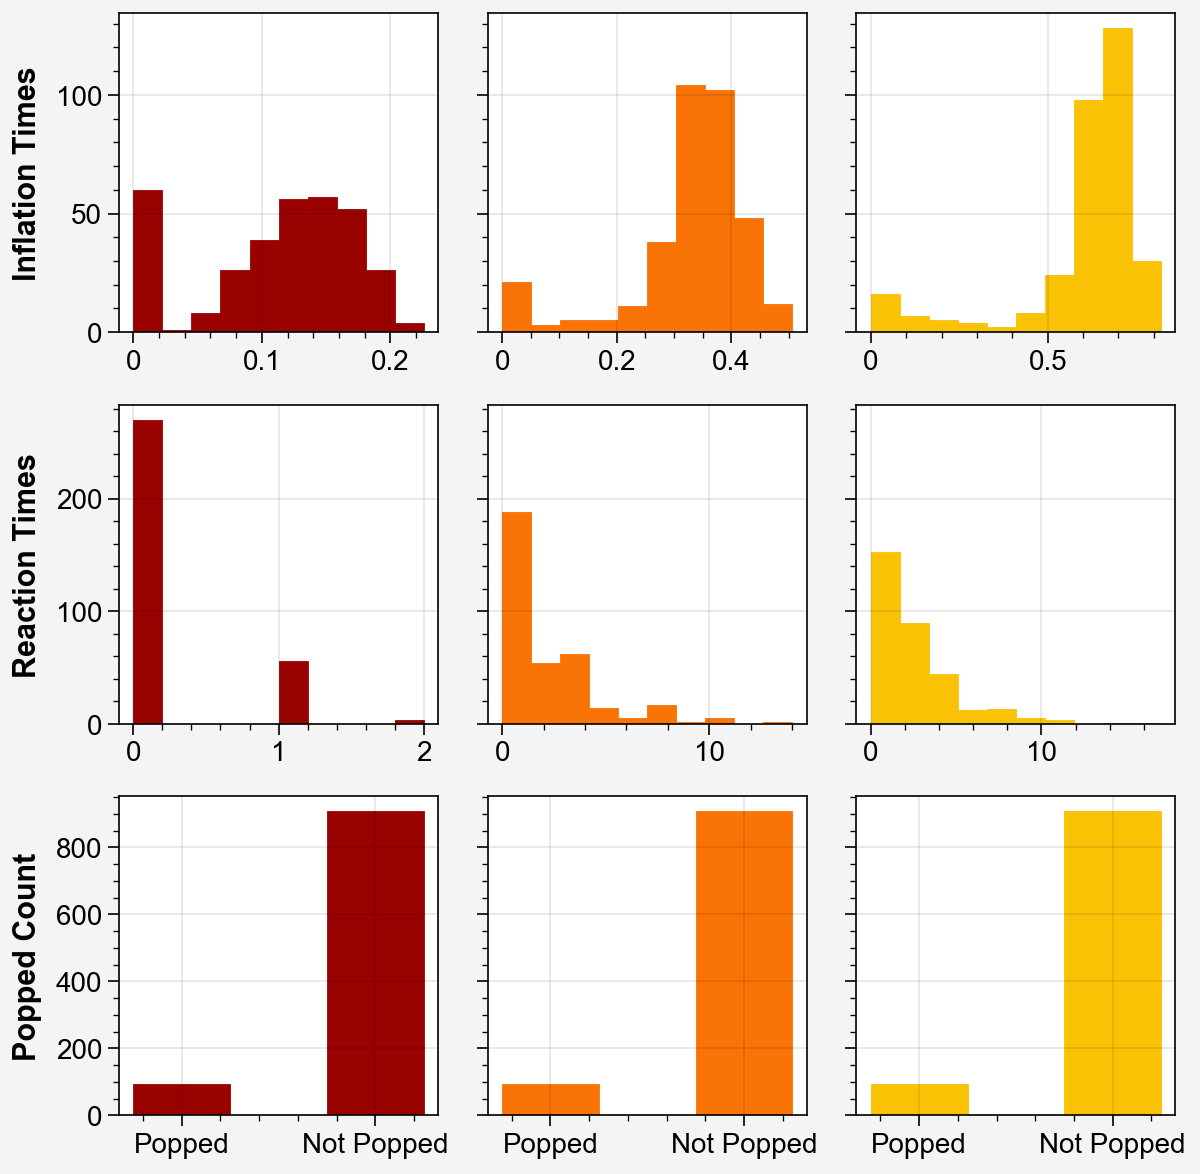

In [92]:
model, (obs_rms, ret_rms) = torch.load('../saved_checkpoints/behav/behav_t0/20.pt')
res = evalu(model, obs_rms, num_episodes=1000, deterministic=False)
plot_3color_it_rt(res, metrics=['size', 'rt', 'popped'])

SubplotGrid(nrows=2, ncols=3, length=6)

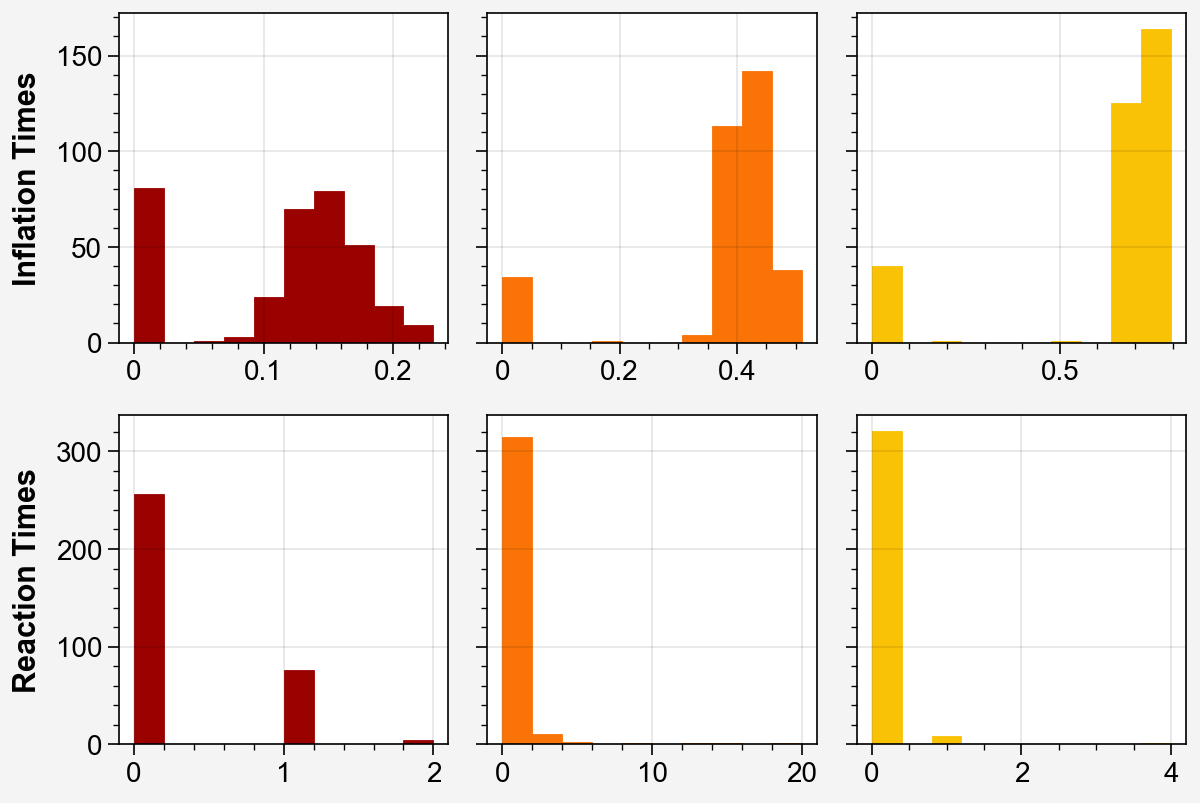

In [4]:
model, (obs_rms, ret_rms) = torch.load('../saved_checkpoints/behav/behav_t0/100.pt')
res = evalu(model, obs_rms, num_episodes=1000, deterministic=False)
plot_3color_it_rt(res)

SubplotGrid(nrows=3, ncols=3, length=9)

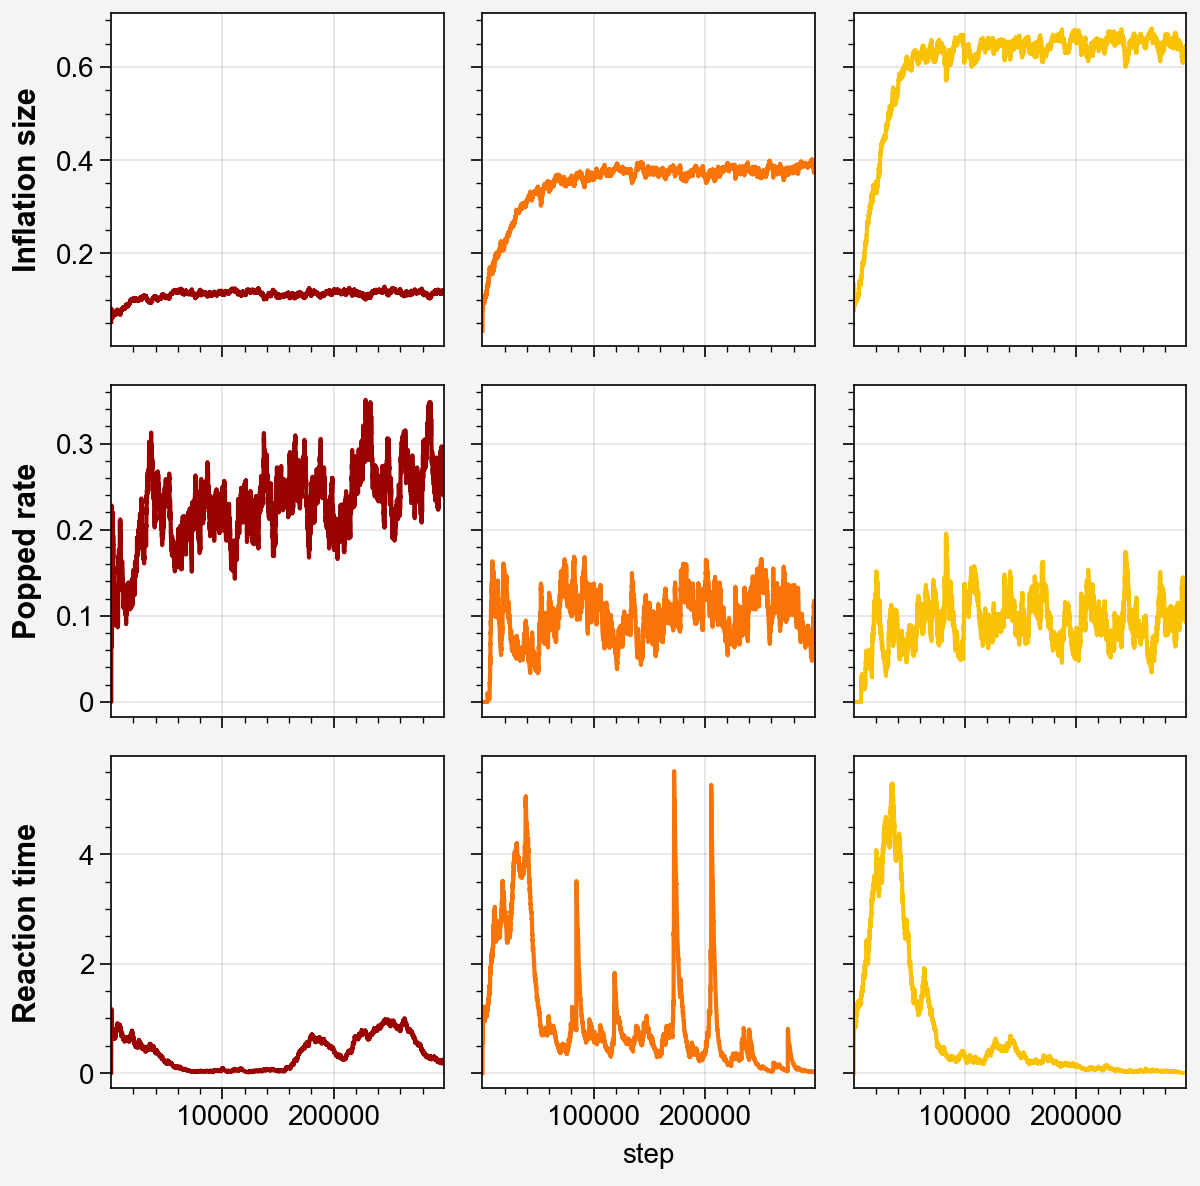

In [70]:
df = load_exp_df('behav/behav', trial_num=0)
plot_bart_behaviors(df, metrics=['size', 'popped', 'rt'])

In [95]:
fres = get_bart_res_eps(res, color=['red'], min_rt=2)
len(fres['obs'])

3

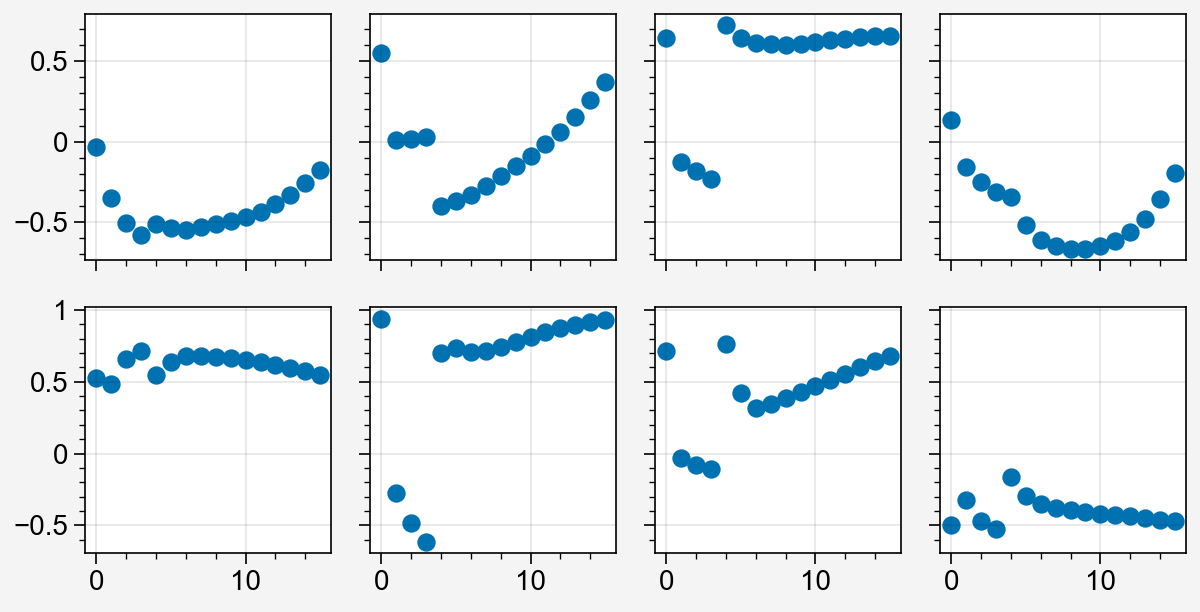

In [66]:
fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=6)
ep = 2
rnn_hxs = fres['rnn_hxs'][ep]
for i in range(8):
    ax[i].scatter(rnn_hxs[:, i])

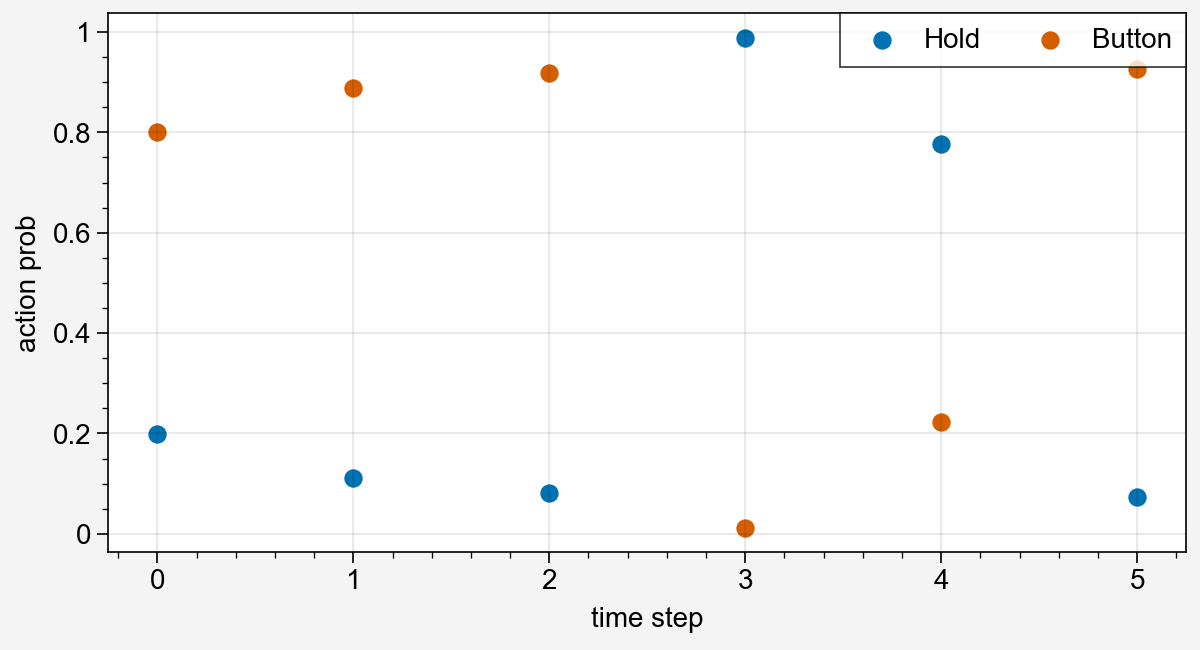

In [96]:
fig, ax = pplt.subplots(refaspect=2, figwidth=6)
ep = 0
aps = fres['action_probs'][ep]
labels = ['Hold', 'Button']
for i in range(2):
    ax.scatter(aps[:, i], label=labels[i])
ax.format(ylabel='action prob', xlabel='time step')
ax.legend()

# MetaBart

## Initial Visualizations

In [4]:
evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=10)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


SubplotGrid(nrows=3, ncols=3, length=9)

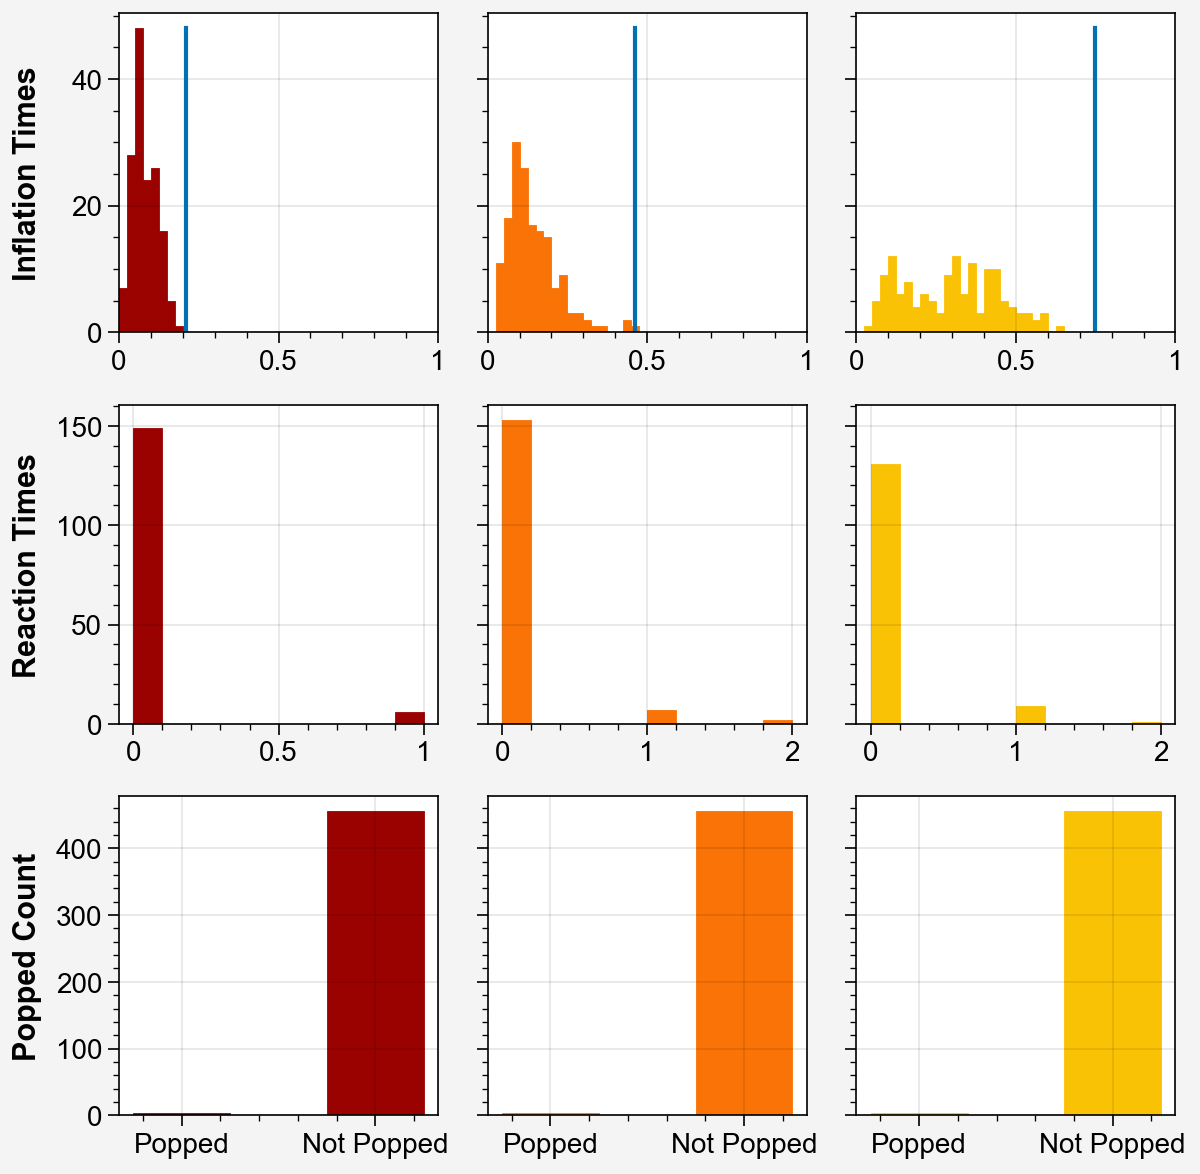

In [5]:
model, (obs_rms, ret_rms) = torch.load('../saved_checkpoints/meta/meta_t0/20.pt')
res = evalu(model, obs_rms, deterministic=False)
plot_3color_meta_ep(res, metrics=['size', 'rt', 'popped'], ep_num=3)

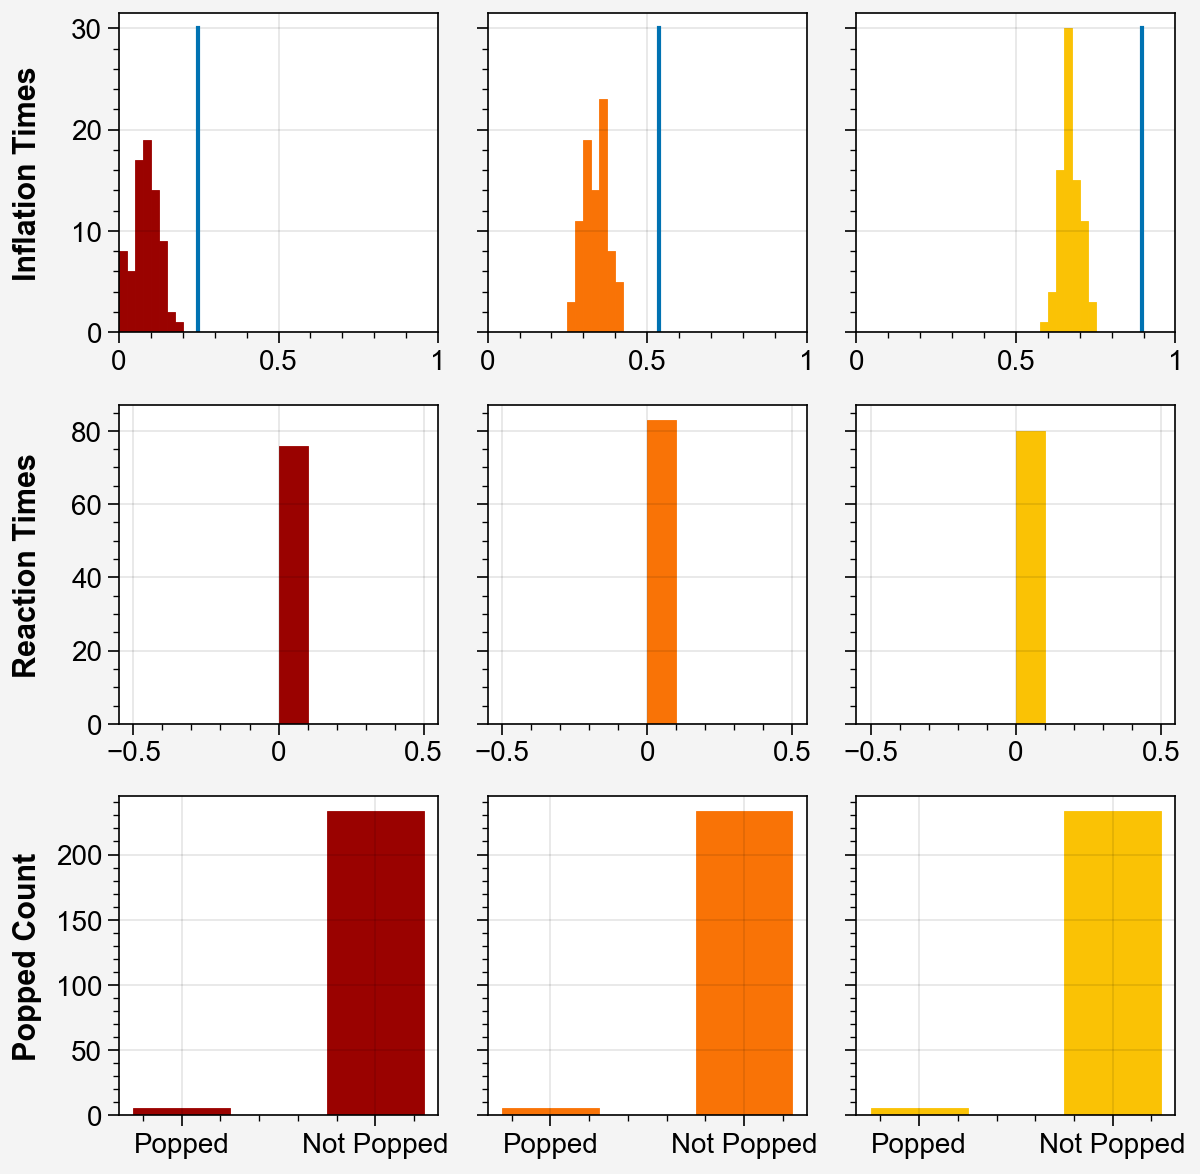

In [57]:
ax = plot_3color_meta_ep(res, metrics=['size', 'rt', 'popped'], ep_num=5)

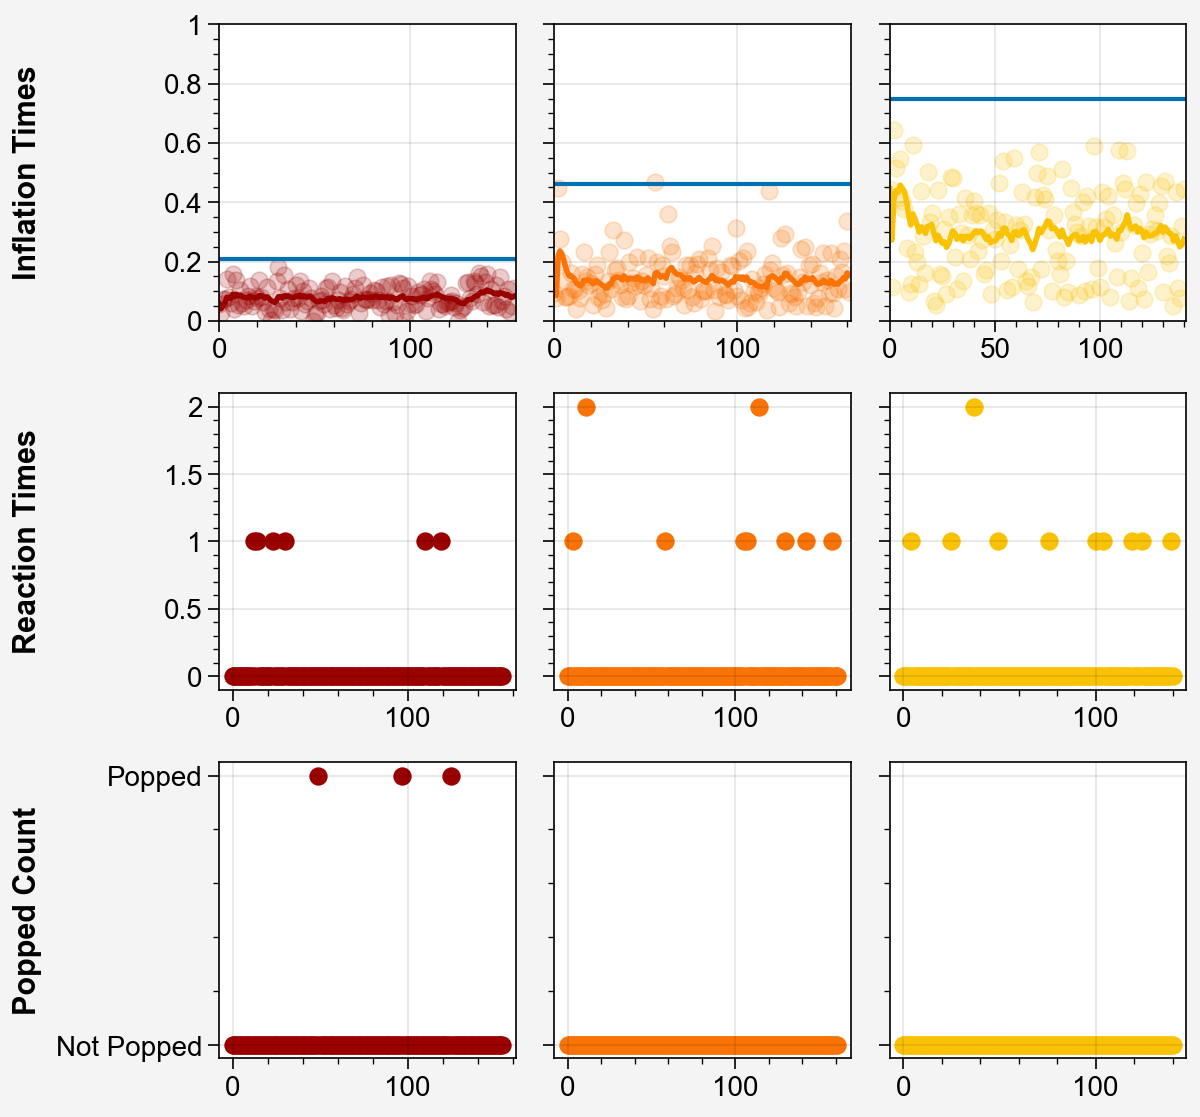

In [6]:
plot_meta_it_progression(res, ep_num=3)

## Meta Uniform

In [8]:
%run bart_behavior_analysis
%run model_evaluation

In [2]:
evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=10, env_kwargs={'meta_setup': 1, 'colors_used': 3})


c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


SubplotGrid(nrows=3, ncols=3, length=9)

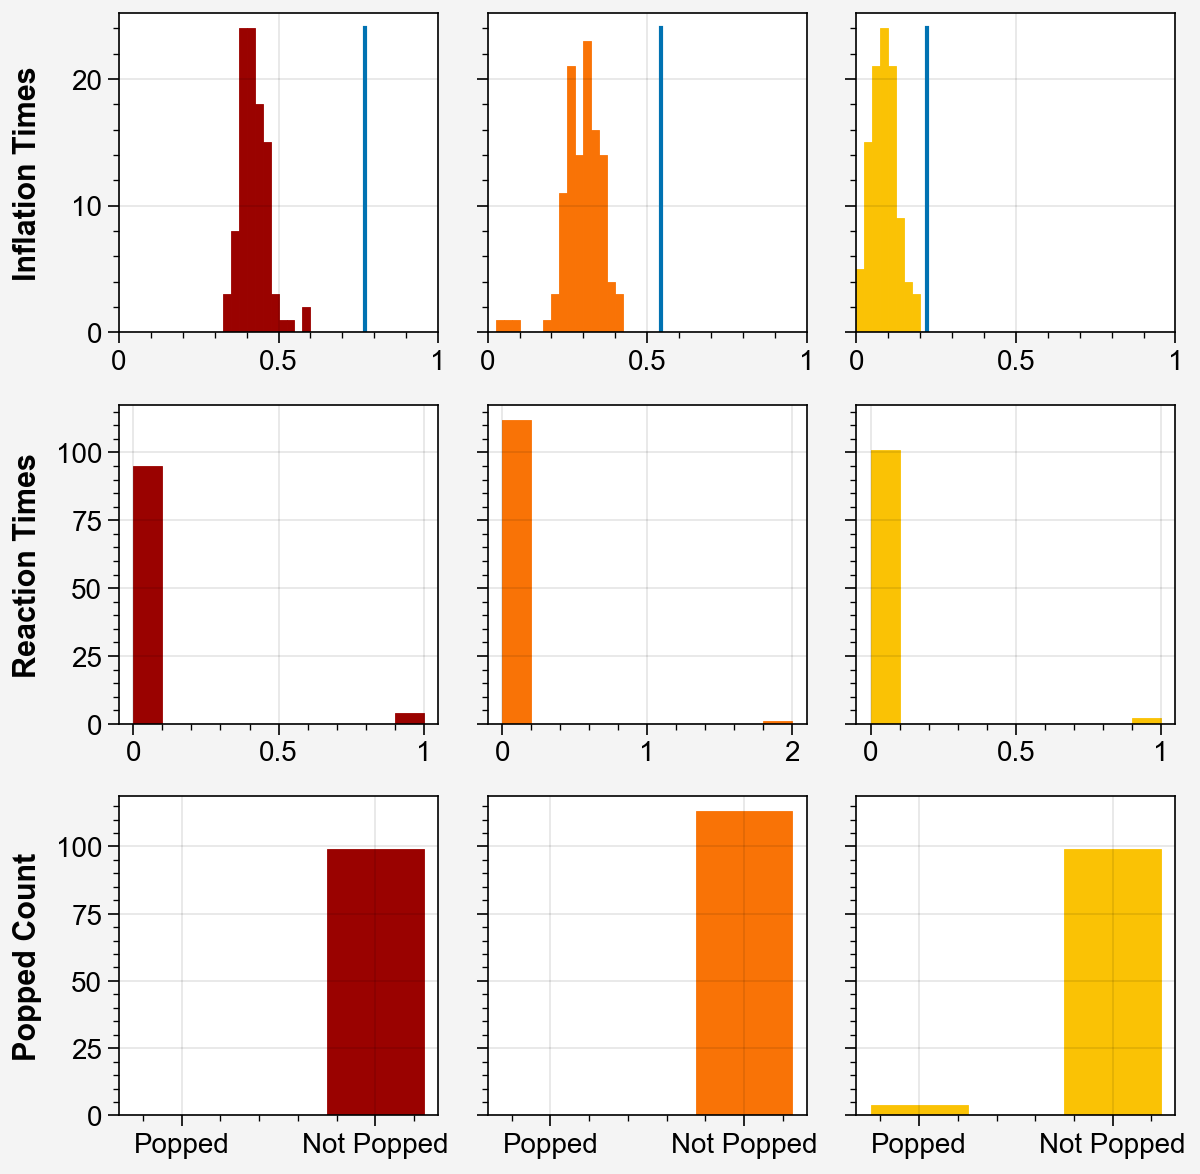

In [5]:
model, (obs_rms, ret_rms) = torch.load('../saved_checkpoints/meta/meta_uni_t0/80.pt')
res = evalu(model, obs_rms, deterministic=False, num_episodes=3)
plot_3color_meta_ep(res, metrics=['size', 'rt', 'popped'], ep_num=0)

## 1 Color, fixed balloon size

In this section we explore the ability of agents trained under different conditions to optimally learn the meta condition. After noticing some agents would have a fixed mean regardless of meta condition (especially when meta condition is high), we tested them with a fixed balloon mean of around 0.7 to see which agents could use the higher condition

In [84]:
evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'inflate_noise': 0, 'pop_noise': 0,
                            'rew_structure': 1, 'max_steps': 1000}, seed=1,
                deterministic=False)

fix_size_evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'inflate_noise': 0, 'pop_noise': 0,
                            'rew_structure': 1, 'max_steps': 1000,
                            'num_balloons': 50, 'fix_sizes': [0, 0.7, 0]}, seed=1,
                deterministic=False)

In [40]:
chks = np.arange(0, 250, 10)
exp_types = ['1c', '1c1p']
exp_chks = [np.arange(0, 250, 10), np.arange(0, 130, 10)]
all_mean_diffs = {}
for i, e in enumerate(exp_types):
    chks = exp_chks[i]
    all_mean_diffs[e] = []
    for t in range(3):
        t_mean_diffs = []
        for chk in chks:
            model, (obs_rms, ret_rms) = torch.load(f'../saved_checkpoints/meta/meta_{e}_t{t}/{chk}.pt')
            res = fix_size_evalu(model, obs_rms)
            t_mean_diffs.append(get_meta_mean_diffs(res)[0][1])
        all_mean_diffs[e].append(t_mean_diffs)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\Desktop\Work\github\bart_ppo\write_and_test\bart_behavior_analysis.py:245: RuntimeWarning: Mean of empty slice.
  it_mean = unpopped_its[unpopped_colors == j].mean()
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


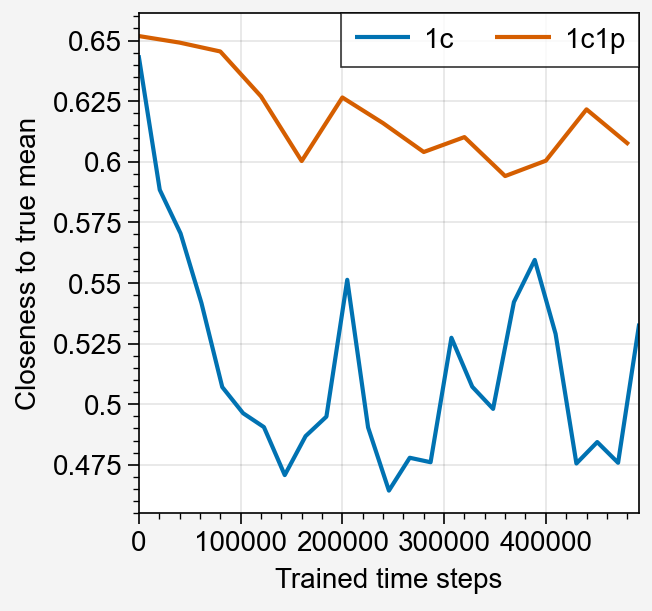

In [41]:
fig, ax = pplt.subplots()
mults = [128*16, 4000]
for i, e in enumerate(exp_types):
    chks = exp_chks[i]
    mult = mults[i]
    ax.plot(chks*mult, np.mean(all_mean_diffs[e], axis=0), label=str(e))
    
ax.format(xlabel='Trained time steps', ylabel='Closeness to true mean')
ax.legend()

In [175]:
all_mean_diffs = {}
all_exp_variants = [
    'easyr0n30', 'easyr0n50', 'easyr0n70',
    'easyr0', 'easyr1', 'easyr2', 'easyr3', 'easyr4', 'easyr5',
    'easyr4b256', 'easyr4b512', 
    'r4n50', 'r0n50', 'easyr4n50',
    'r4',
    'r0n50b128', 'r0n50b256', 'r0n50b512',
    'easyr0n50b128', 'easyr0n50b256', 'easyr0n50b512',
    'r0n30b128', 'r0n30b256', 'r0n30b512',
]

for i, exp_type in enumerate(tqdm(all_exp_variants)):
    
    batch_size = 128 #default
    batch_re = re.search('b\d+', exp_type)
    if batch_re:
        batch_size = int(batch_re[0][1:])
    chks = {
        128: np.arange(0, 490, 40),
        256: np.arange(0, 250, 20),
        512: np.arange(0, 130, 10),
    }[batch_size]
    # Special case for easyr\d: only 500k steps trained
    if exp_type in ['easyr0', 'easyr1', 'easyr2', 'easyr3']:
        chks = np.arange(0, 250, 20)
    
    print(exp_type, chks)
    if exp_type in all_mean_diffs:
        continue
    all_mean_diffs[exp_type] = []
    for t in range(3):
        t_mean_diffs = []
        for chk in chks:
            exp_name = f'meta_{exp_type}_{t}'
            model, (obs_rms, ret_rms) = torch.load(f'../saved_checkpoints/meta/{exp_name}/{chk}.pt')
            res = fix_size_evalu(model, obs_rms)
            t_mean_diffs.append(get_meta_mean_diffs(res)[0][1])
        all_mean_diffs[exp_type].append(t_mean_diffs)
        
pickle.dump(all_mean_diffs, open('data/meta1c_07fixed_mean_diffs', 'wb'))

100%|██████████| 21/21 [00:00<00:00, 8595.72it/s]

easyr0n30 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
easyr0n50 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
easyr0n70 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
easyr0 [  0  20  40  60  80 100 120 140 160 180 200 220 240]
easyr1 [  0  20  40  60  80 100 120 140 160 180 200 220 240]
easyr2 [  0  20  40  60  80 100 120 140 160 180 200 220 240]
easyr3 [  0  20  40  60  80 100 120 140 160 180 200 220 240]
easyr4 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
easyr5 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
easyr4b256 [  0  20  40  60  80 100 120 140 160 180 200 220 240]
easyr4b512 [  0  10  20  30  40  50  60  70  80  90 100 110 120]
r4n50 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
r0n50 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
easyr4n50 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
r4 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
r0n50b128 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
r0n50b2

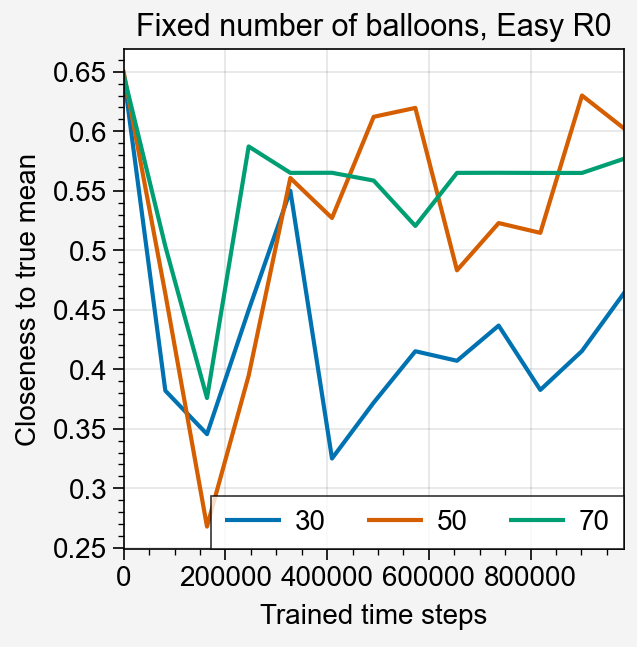

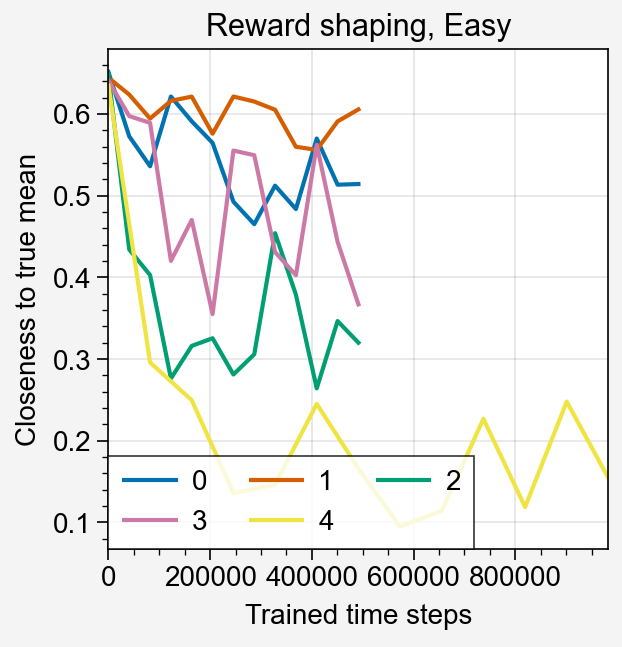

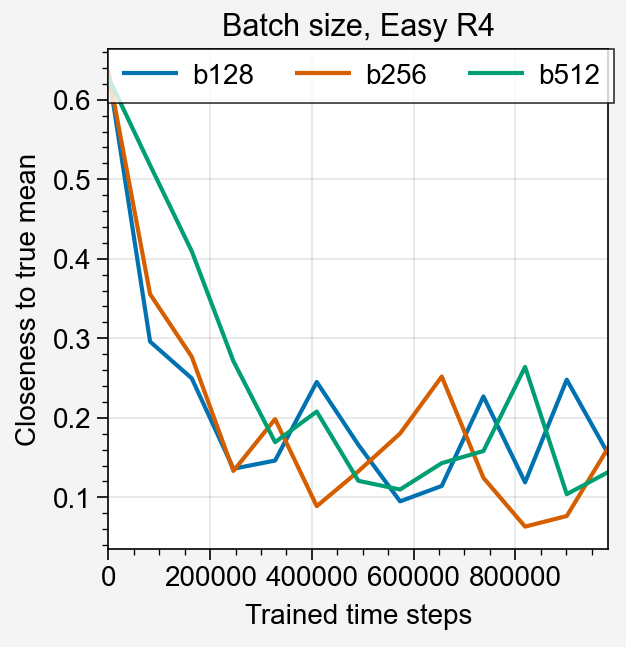

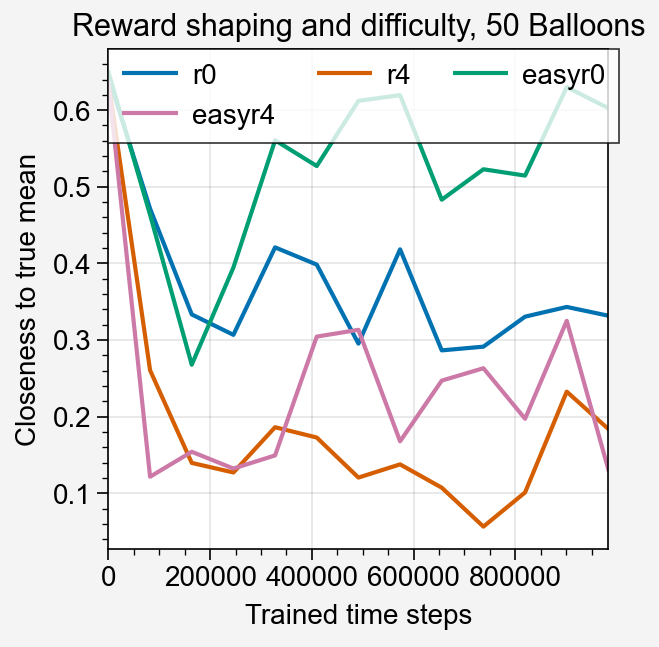

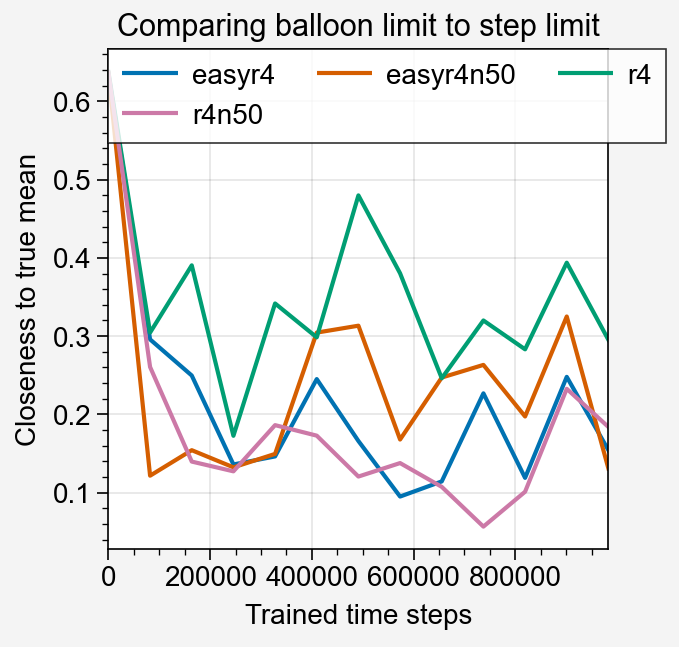

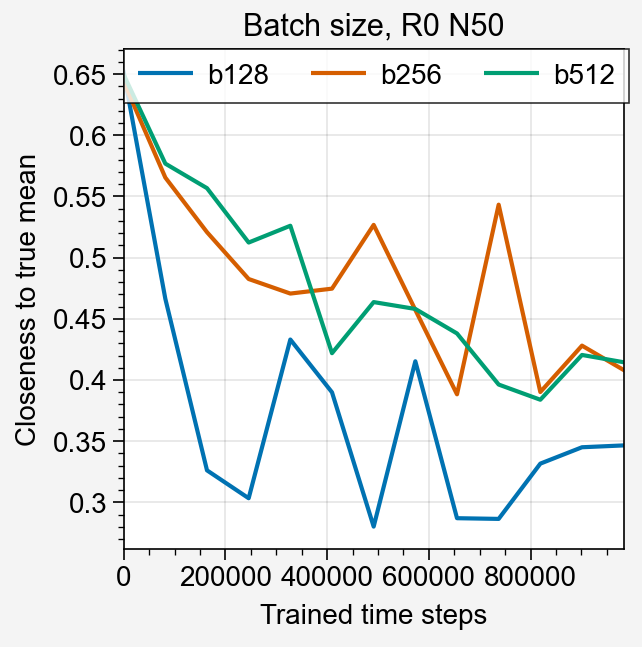

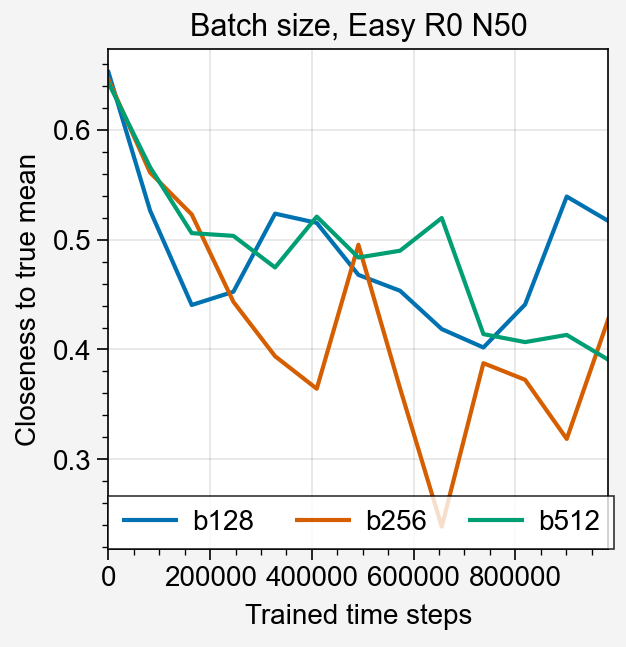

In [173]:
all_mean_diffs = pickle.load(open('data/meta1c_07fixed_mean_diffs', 'rb'))
comparisons = {
    'num_balloons': {
        'title': 'Fixed number of balloons, Easy R0',
        'exp_types': ['easyr0n30', 'easyr0n50', 'easyr0n70'],
        'labels': [30, 50, 70]
    },
    'reward_shaping': {
        'title': 'Reward shaping, Easy',
        'exp_types': ['easyr0', 'easyr1', 'easyr2', 'easyr3', 'easyr4'],
        'labels': [0, 1, 2, 3, 4],
    },
    'easyr4batch': {
        'title': 'Batch size, Easy R4',
        'exp_types': ['easyr4', 'easyr4b256', 'easyr4b512'], 
        'labels': ['b128', 'b256', 'b512']
    },
    'num_balloons_rew': {
        'title': 'Reward shaping and difficulty, 50 Balloons',
        'exp_types': ['r0n50', 'r4n50', 'easyr0n50', 'easyr4n50'],
        'labels': ['r0', 'r4', 'easyr0', 'easyr4']
    },
    'num_balloons_comp': {
        'title': 'Comparing balloon limit to step limit',
        'exp_types': ['easyr4', 'easyr4n50', 'r4', 'r4n50'],
        'labels': ['easyr4', 'easyr4n50', 'r4', 'r4n50'],
    },
    'n50_batch': {
        'title': 'Batch size, R0 N50',
        'exp_types': ['r0n50b128', 'r0n50b256', 'r0n50b512',],
        'labels': ['b128', 'b256', 'b512']
    },
    'easyn50_batch': {
        'title': 'Batch size, Easy R0 N50',
        'exp_types': ['easyr0n50b128', 'easyr0n50b256', 'easyr0n50b512',],
        'labels': ['b128', 'b256', 'b512']
    },
    'n30_batch': {
        'title': 'Batch size, R0 N30',
        'exp_types': ['r0n30b128', 'r0n30b256', 'r0n30b512',],
        'labels': ['b128', 'b256', 'b512']
    },
}

for key in comparisons:
    fig, ax = pplt.subplots()
    exp_types = comparisons[key]['exp_types']
    labels = comparisons[key]['labels']

    for i, exp_type in enumerate(exp_types):
        batch_size = 128 #default
        batch_re = re.search('b\d+', exp_type)
        if batch_re:
            batch_size = int(batch_re[0][1:])
        chks = {
            128: np.arange(0, 490, 40),
            256: np.arange(0, 250, 20),
            512: np.arange(0, 130, 10),
        }[batch_size]
        x = chks*batch_size*16
        if exp_type in ['easyr0', 'easyr1', 'easyr2', 'easyr3']:
            x = np.arange(0, 250, 20)*128*16
        
        ax.plot(x, np.mean(all_mean_diffs[exp_type], axis=0), label=str(labels[i]))
        
    ax.format(xlabel='Trained time steps', ylabel='Closeness to true mean',
              title=comparisons[key]['title'])
    ax.legend()

## Showing effects on return of limiting by balloons or time steps

Looking at theoretical returns of inflating to a certain size. The idea is that for a balloon with larger potential, this shows that when using a fixed number of balloons rather than fixed number of time steps, the number of balloons agent would lose out more by not optimizing than the time steps agent

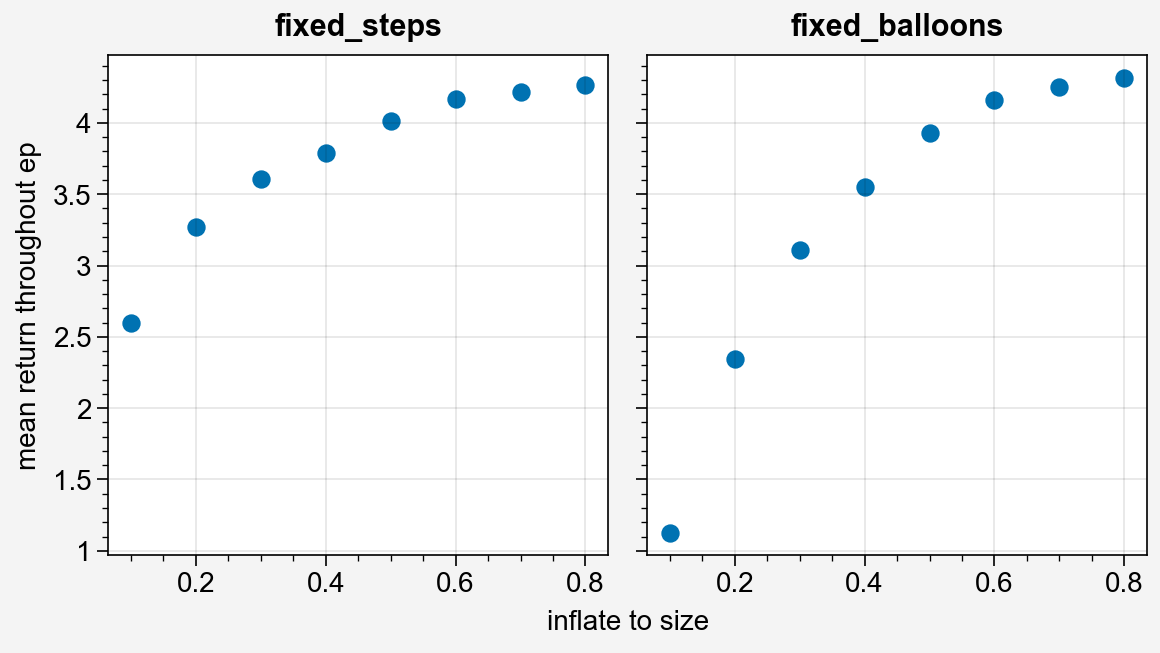

In [106]:
sizes = np.arange(0.1, 0.9, 0.1)
mean_returns = {
    'fixed_steps': [],
    'fixed_balloons': [],
}
gamma = 0.99

for key in mean_returns:
    rewards = []
    mr = []
    for size in sizes:
        step_per_balloon = int((size // 0.05) + 1)
        if key == 'fixed_steps':
            num_steps = 450
        else:
            num_steps = step_per_balloon * 30
        for i in range(num_steps):
            if i % (step_per_balloon) == 0 and i != 0:
                rewards.append(size)
            else:
                rewards.append(0)
        # print(np.mean(rewards), num_steps, size)

        reversed_return = []
        for r in rewards[::-1]:
            if len(reversed_return) == 0:
                reversed_return.append(r)
            else:
                reversed_return.append(r + gamma*reversed_return[-1])

        mr.append(np.mean(reversed_return))
    mean_returns[key] = mr


fig, ax = pplt.subplots(ncols=2)
for i, key in enumerate(mean_returns):
    ax[i].scatter(sizes, mean_returns[key], label=key)
ax.format(xlabel='inflate to size', ylabel='mean return throughout ep',
          toplabels=list(mean_returns.keys()))


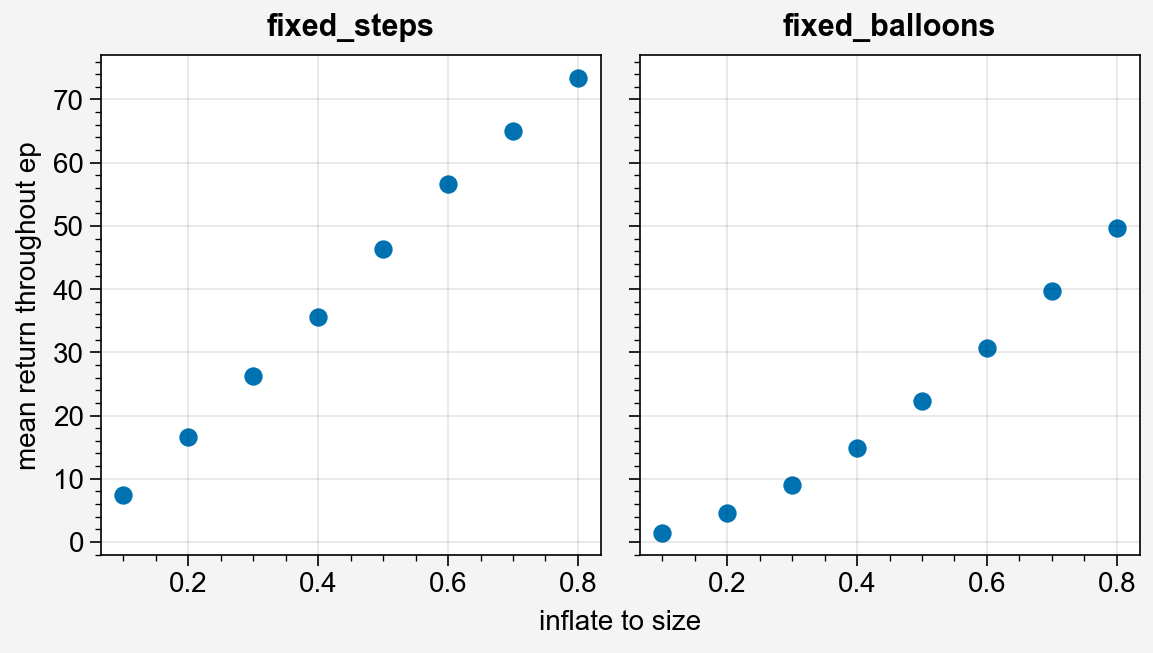

In [105]:
sizes = np.arange(0.1, 0.9, 0.1)
mean_returns = {
    'fixed_steps': [],
    'fixed_balloons': [],
}
gamma = 0.9999

for key in mean_returns:
    rewards = []
    mr = []
    for size in sizes:
        step_per_balloon = int((size // 0.05) + 1)
        if key == 'fixed_steps':
            num_steps = 450
        else:
            num_steps = step_per_balloon * 30
        for i in range(num_steps):
            if i % (step_per_balloon) == 0 and i != 0:
                rewards.append(size)
            else:
                rewards.append(0)
        # print(np.mean(rewards), num_steps, size)

        reversed_return = []
        for r in rewards[::-1]:
            if len(reversed_return) == 0:
                reversed_return.append(r)
            else:
                reversed_return.append(r + gamma*reversed_return[-1])

        mr.append(np.mean(reversed_return))
    mean_returns[key] = mr


fig, ax = pplt.subplots(ncols=2)
for i, key in enumerate(mean_returns):
    ax[i].scatter(sizes, mean_returns[key], label=key)
ax.format(xlabel='inflate to size', ylabel='mean return throughout ep',
          toplabels=list(mean_returns.keys()))


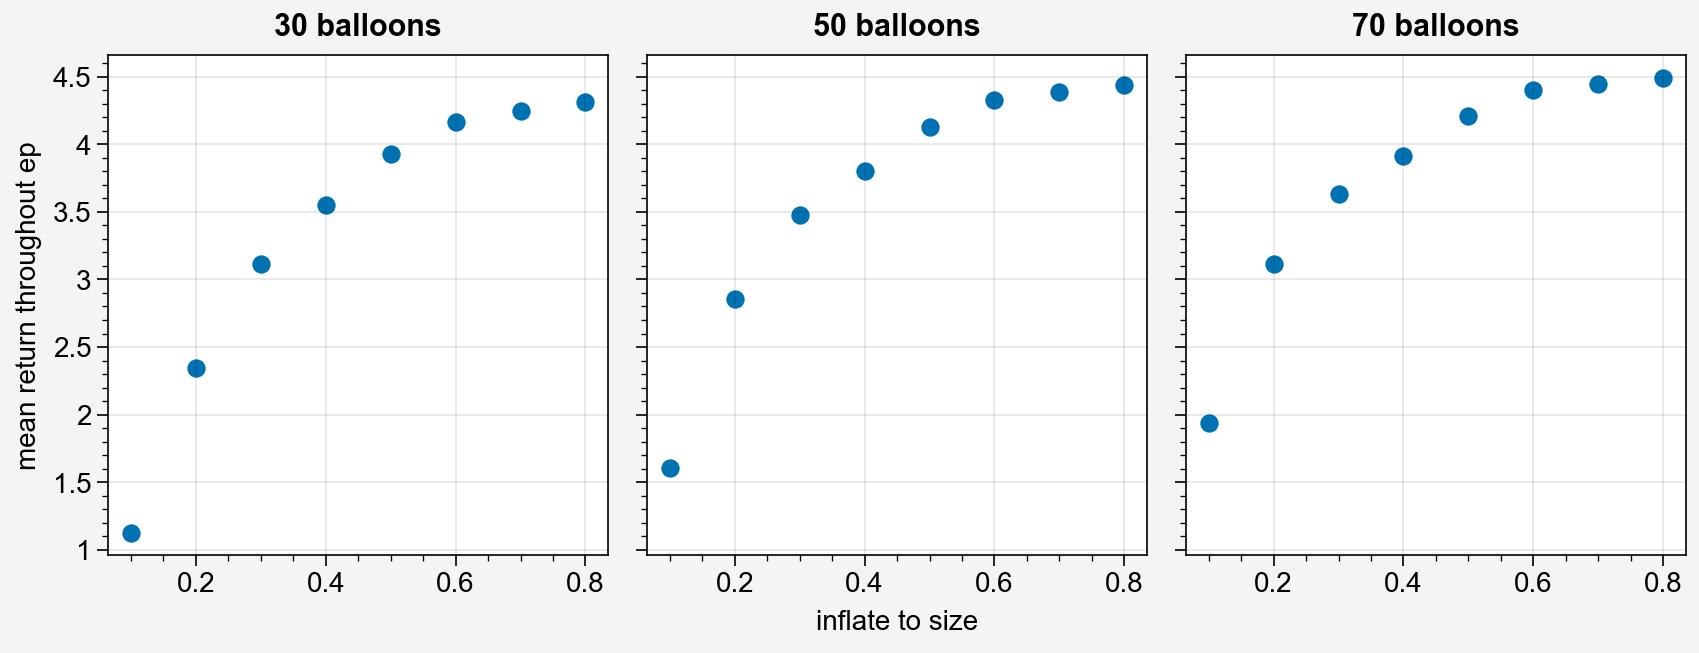

In [108]:
sizes = np.arange(0.1, 0.9, 0.1)
num_balloons = [30, 50, 70]
mean_returns = {}
gamma = 0.99

for n in num_balloons:
    rewards = []
    mr = []
    for size in sizes:
        step_per_balloon = int((size // 0.05) + 1)
        num_steps = step_per_balloon * n
        for i in range(num_steps):
            if i % (step_per_balloon) == 0 and i != 0:
                rewards.append(size)
            else:
                rewards.append(0)

        reversed_return = []
        for r in rewards[::-1]:
            if len(reversed_return) == 0:
                reversed_return.append(r)
            else:
                reversed_return.append(r + gamma*reversed_return[-1])

        mr.append(np.mean(reversed_return))
    mean_returns[n] = mr


fig, ax = pplt.subplots(ncols=3)
for i, key in enumerate(mean_returns):
    ax[i].scatter(sizes, mean_returns[key], label=key)
ax.format(xlabel='inflate to size', ylabel='mean return throughout ep',
          toplabels=[f'{n} balloons' for n in num_balloons])


## 1 Color, varying meta conditions

In [ ]:
evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=5, 
                env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 1000, 'num_balloons': 30}, seed=1,
                deterministic=False)

fix_size_evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=5, 
                env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'rew_structure': 1, 'num_balloons': 100,
                            'fix_sizes': [0, [0.2, 0.4, 0.6, 0.8, 1.0, 0], 0]}, 
                seed=1,
                deterministic=False)
fix_size_easy_evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=5, 
                env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'rew_structure': 1, 'num_balloons': 100,
                            'inflate_noise': 0, 'pop_noise': 0,
                            'fix_sizes': [0, [0.2, 0.4, 0.6, 0.8, 1.0, 0], 0]}, 
                seed=1,
                deterministic=False)

In [ ]:
model, (obs_rms, ret_rms) = torch.load(f'../saved_checkpoints/meta/meta_r4n50_2/480.pt')
# res = evalu(model, obs_rms)
res = fix_size_evalu(model, obs_rms)
# res = fix_size_easy_evalu(model, obs_rms)

In [ ]:
plot_ncolor_meta_ep(res, num_colors=1, ep_num=2)

In [ ]:
plot_ncolor_meta_progression(res, num_colors=1, ep_num=3)

In [38]:
# all_mean_diffs = {}
# all_self_diffs = {}
# all_pop_rates = {}

all_exp_variants = [
    'easyr0n30', 'easyr0n50', 'easyr0n70',
    'easyr0', 'easyr1', 'easyr2', 'easyr3', 'easyr4', 'easyr5',
    'easyr4b256', 'easyr4b512', 
    'r4n50', 'r0n50', 'easyr4n50',
    'r4',
    'r0n50b128', 'r0n50b256', 'r0n50b512',
    'easyr0n50b128', 'easyr0n50b256', 'easyr0n50b512',
    'r0n30b128', 'r0n30b256', 'r0n30b512',
]

for i, exp_type in enumerate(tqdm(all_exp_variants)):
    
    batch_size = 128 #default
    batch_re = re.search('b\d+', exp_type)
    if batch_re:
        batch_size = int(batch_re[0][1:])
    chks = {
        128: np.arange(0, 490, 40),
        256: np.arange(0, 250, 20),
        512: np.arange(0, 130, 10),
    }[batch_size]
    # Special case for easyr\d: only 500k steps trained
    if exp_type in ['easyr0', 'easyr1', 'easyr2', 'easyr3']:
        chks = np.arange(0, 250, 20)
    
    print(exp_type, chks)
    if exp_type in all_mean_diffs:
        continue
    all_mean_diffs[exp_type] = []
    all_self_diffs[exp_type] = []
    all_pop_rates[exp_type] = []
    for t in range(3):
        t_mean_diffs = []
        t_self_diffs = []
        t_pop_rates = []
        for chk in chks:
            exp_name = f'meta_{exp_type}_{t}'
            model, (obs_rms, ret_rms) = torch.load(f'../saved_checkpoints/meta/{exp_name}/{chk}.pt')
            res = fix_size_evalu(model, obs_rms)
            
            meta_mean_diffs = np.array(get_meta_mean_diffs(res, colors_used=1)).reshape(-1)
            self_mean_diffs = get_meta_self_mean_diff(res, colors_used=1)[1].reshape(-1)
            pop_rate = np.array(get_pop_rates(res, colors_used=1)).reshape(-1)
            t_mean_diffs.append(meta_mean_diffs)
            t_self_diffs.append(self_mean_diffs)
            t_pop_rates.append(pop_rate)
            
        all_mean_diffs[exp_type].append(t_mean_diffs)
        all_self_diffs[exp_type].append(t_self_diffs)
        all_pop_rates[exp_type].append(t_pop_rates)
pickle.dump({
    'mean_diffs': all_mean_diffs,
    'self_diffs': all_self_diffs,
    'pop_rates': all_pop_rates,
}, open('data/meta1c_progressive_fixed_mean_diffs', 'wb'))

  0%|          | 0/24 [00:00<?, ?it/s]c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


easyr0n30 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
easyr0n50 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
easyr0n70 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
easyr0 [  0  20  40  60  80 100 120 140 160 180 200 220 240]
easyr1 [  0  20  40  60  80 100 120 140 160 180 200 220 240]
easyr2 [  0  20  40  60  80 100 120 140 160 180 200 220 240]
easyr3 [  0  20  40  60  80 100 120 140 160 180 200 220 240]
easyr4 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
easyr5 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
easyr4b256 [  0  20  40  60  80 100 120 140 160 180 200 220 240]
easyr4b512 [  0  10  20  30  40  50  60  70  80  90 100 110 120]
r4n50 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
r0n50 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
easyr4n50 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
r4 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
r0n50b128 [  0  40  80 120 160 200 240 280 320 360 400 440 480]
r0n50b2

100%|██████████| 24/24 [01:01<00:00,  2.57s/it]


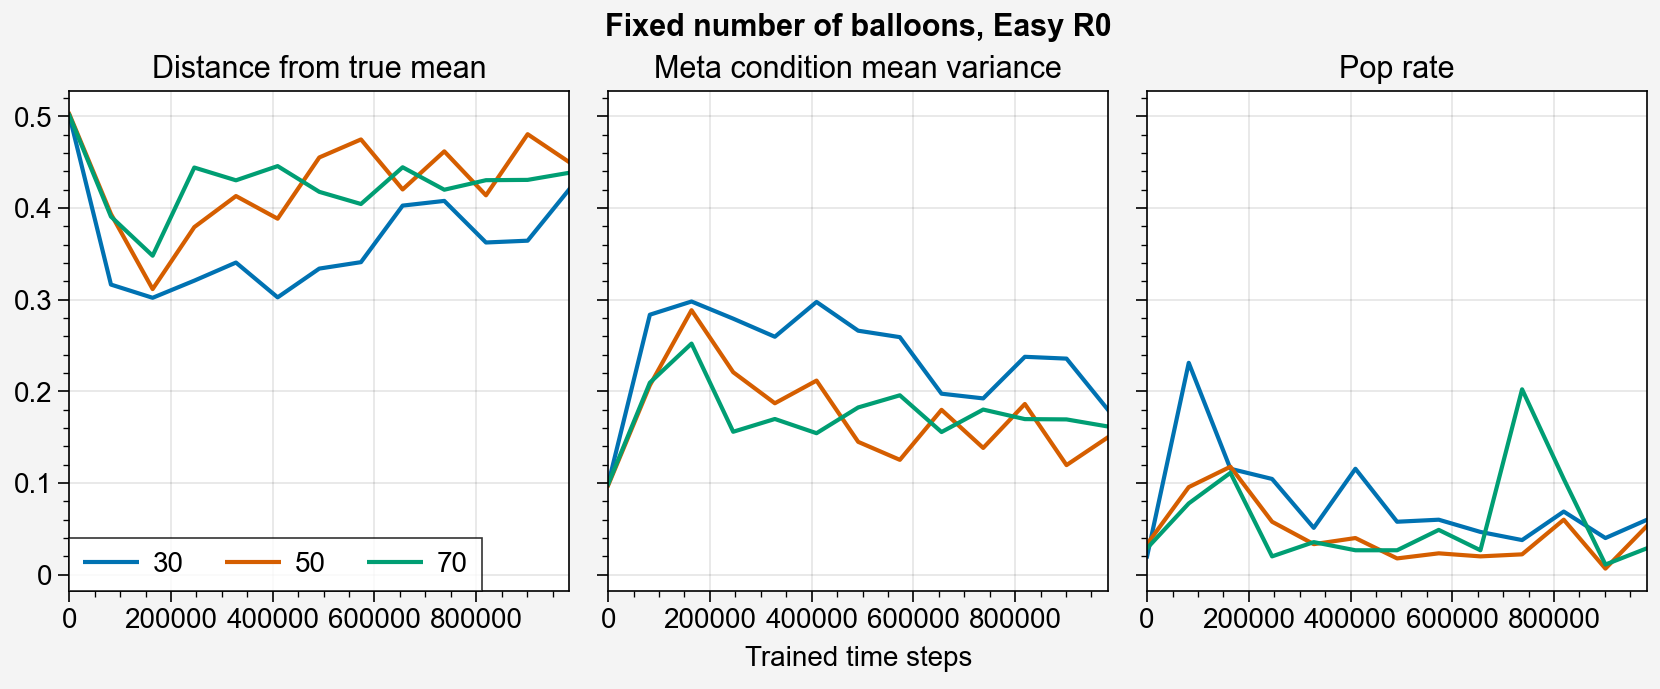

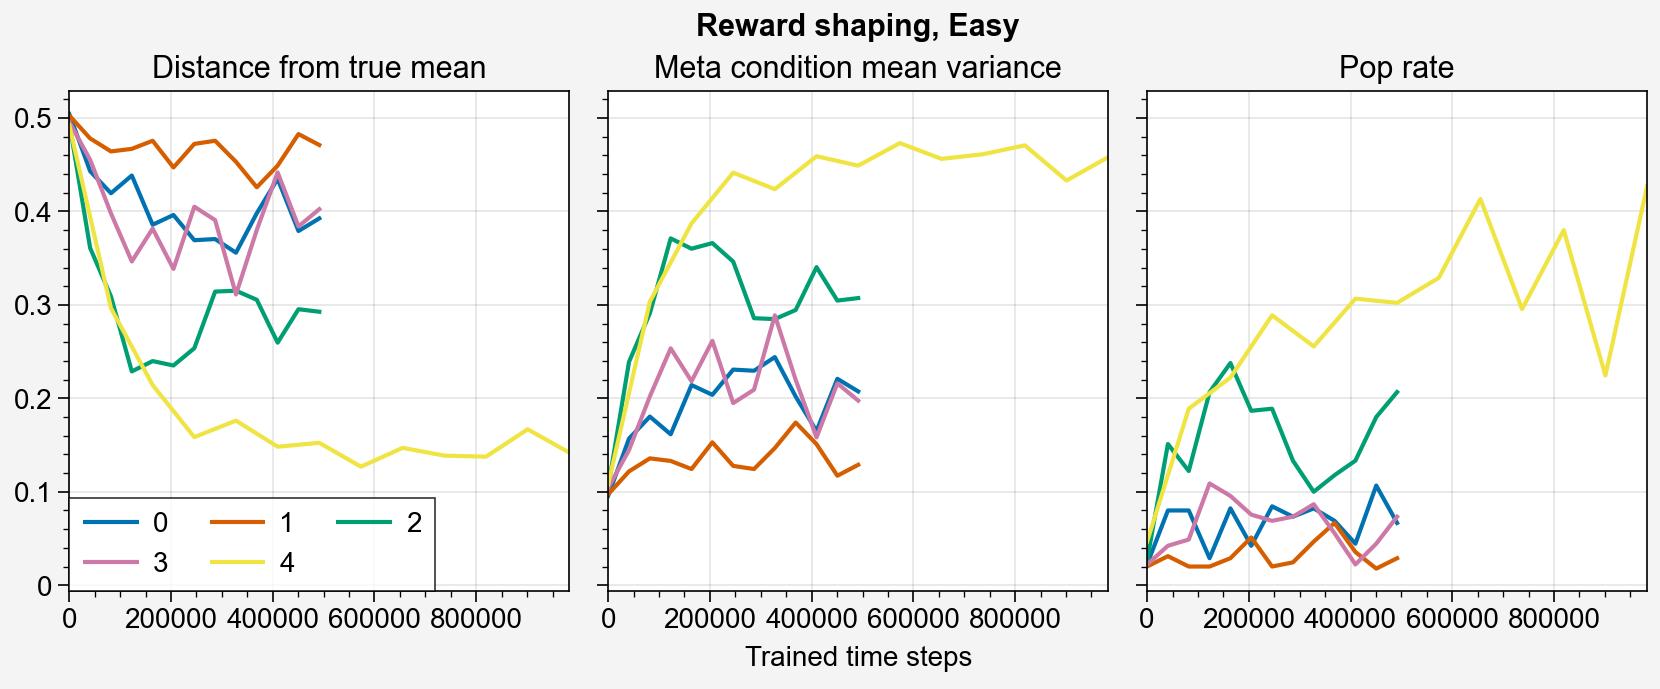

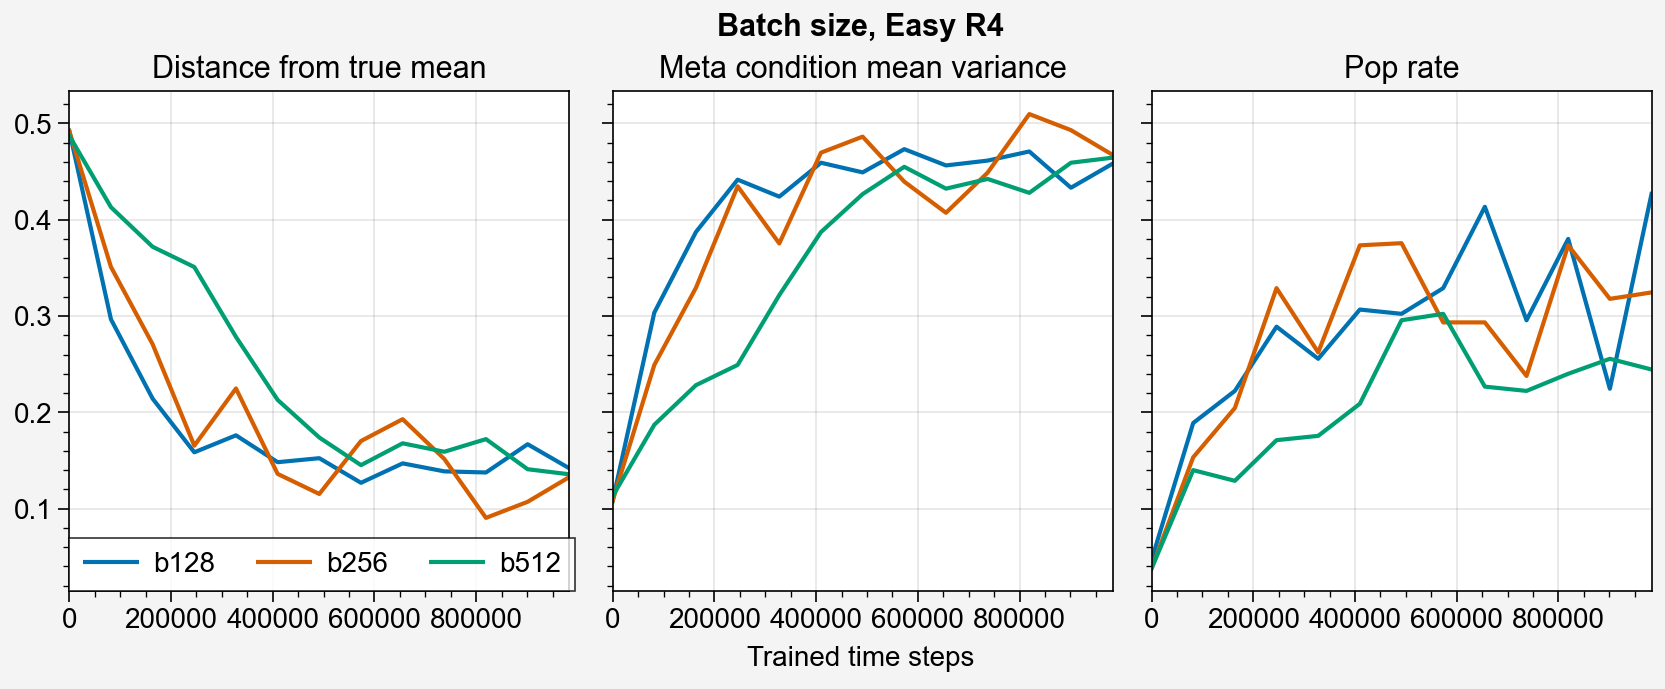

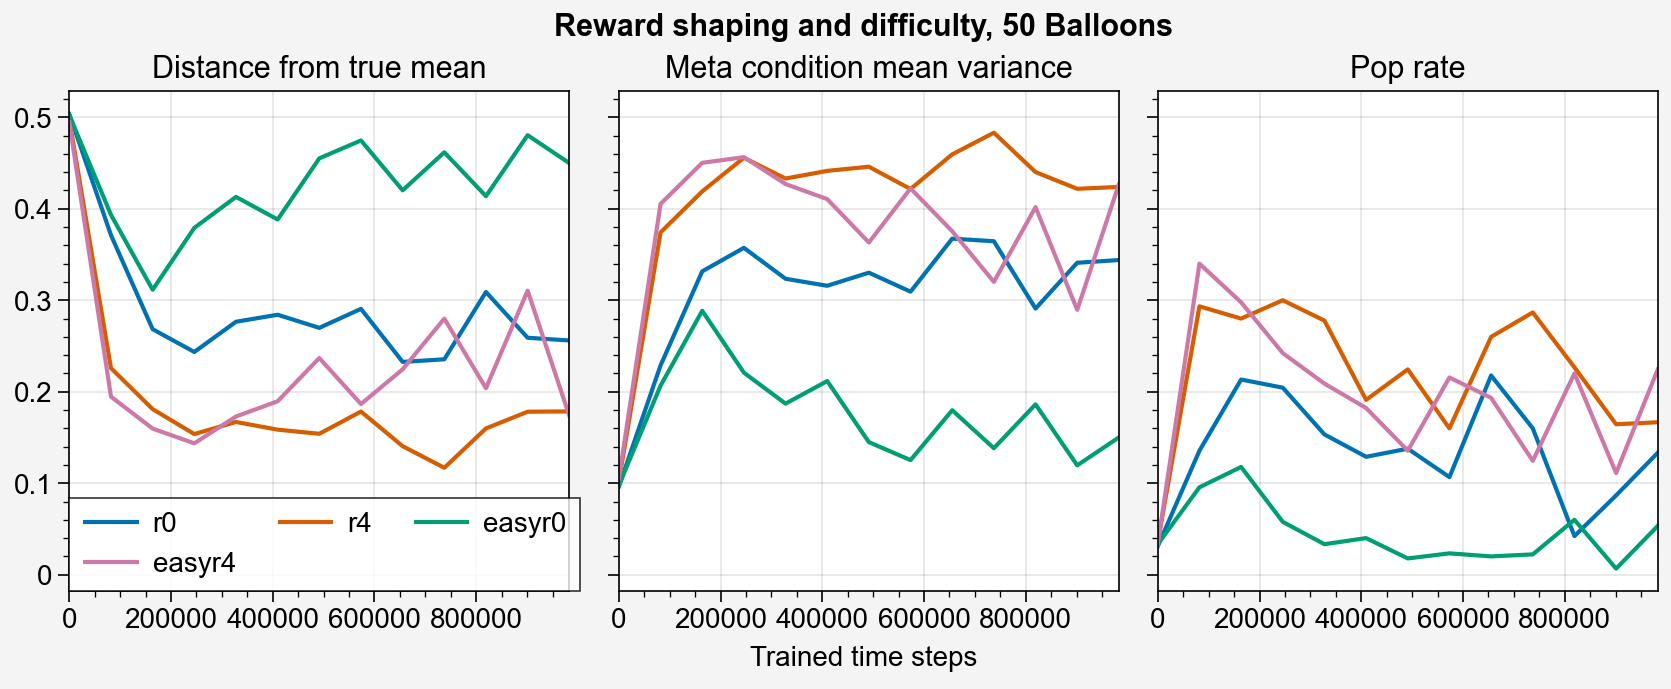

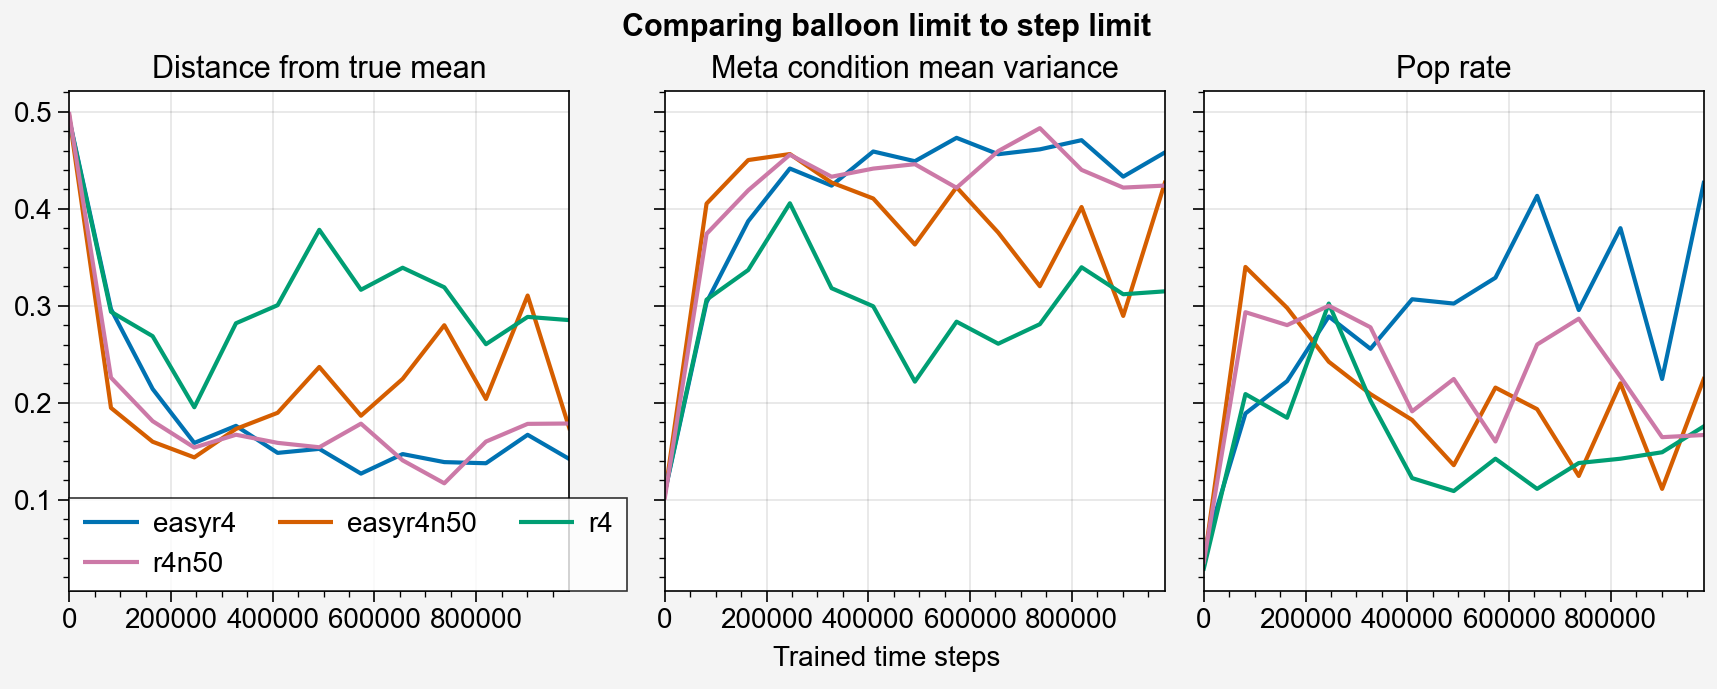

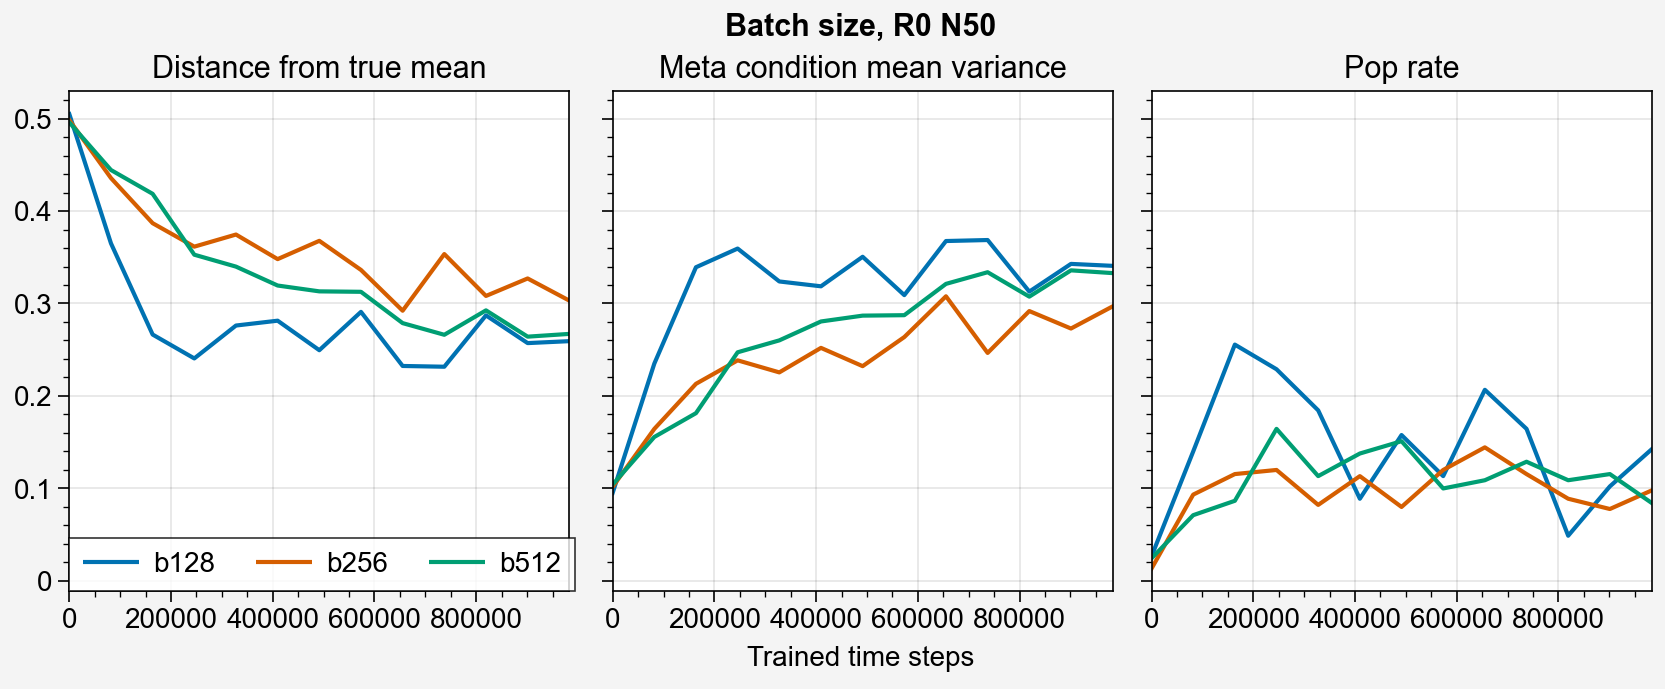

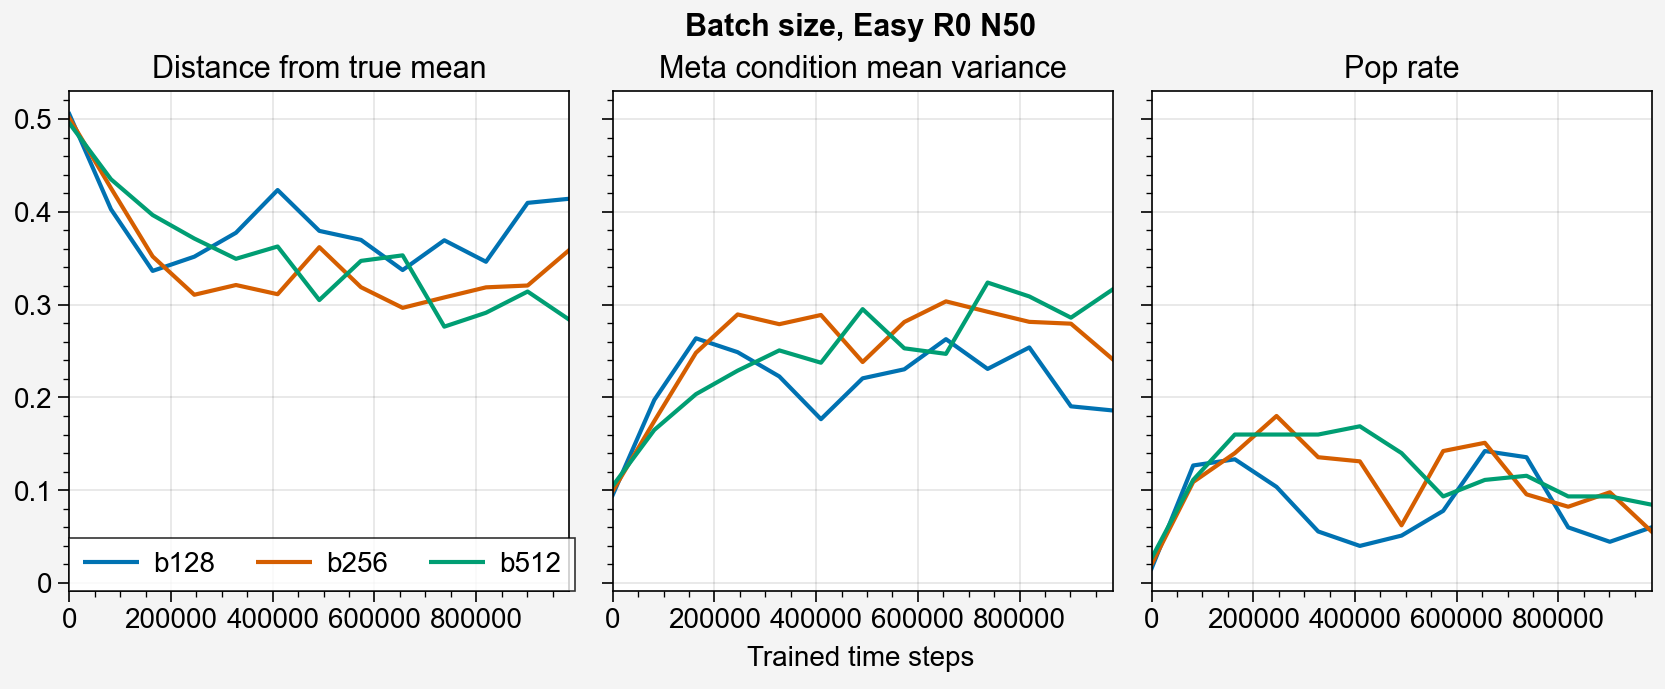

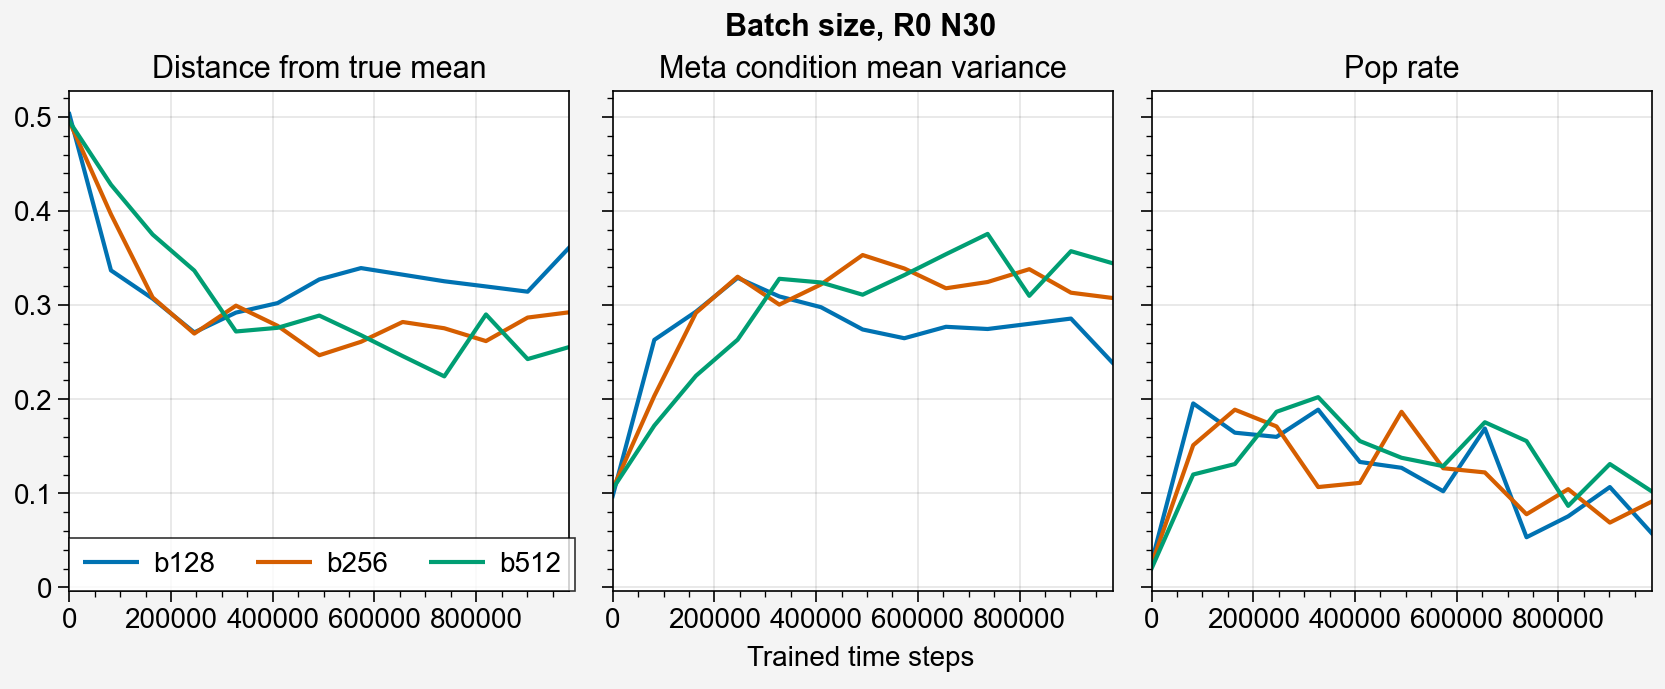

In [39]:
progressive_data = pickle.load(open('data/meta1c_progressive_fixed_mean_diffs', 'rb'))
comparisons = {
    'num_balloons': {
        'title': 'Fixed number of balloons, Easy R0',
        'exp_types': ['easyr0n30', 'easyr0n50', 'easyr0n70'],
        'labels': [30, 50, 70]
    },
    'reward_shaping': {
        'title': 'Reward shaping, Easy',
        'exp_types': ['easyr0', 'easyr1', 'easyr2', 'easyr3', 'easyr4'],
        'labels': [0, 1, 2, 3, 4],
    },
    'easyr4batch': {
        'title': 'Batch size, Easy R4',
        'exp_types': ['easyr4', 'easyr4b256', 'easyr4b512'], 
        'labels': ['b128', 'b256', 'b512']
    },
    'num_balloons_rew': {
        'title': 'Reward shaping and difficulty, 50 Balloons',
        'exp_types': ['r0n50', 'r4n50', 'easyr0n50', 'easyr4n50'],
        'labels': ['r0', 'r4', 'easyr0', 'easyr4']
    },
    'num_balloons_comp': {
        'title': 'Comparing balloon limit to step limit',
        'exp_types': ['easyr4', 'easyr4n50', 'r4', 'r4n50'],
        'labels': ['easyr4', 'easyr4n50', 'r4', 'r4n50'],
    },
    'n50_batch': {
        'title': 'Batch size, R0 N50',
        'exp_types': ['r0n50b128', 'r0n50b256', 'r0n50b512',],
        'labels': ['b128', 'b256', 'b512']
    },
    'easyn50_batch': {
        'title': 'Batch size, Easy R0 N50',
        'exp_types': ['easyr0n50b128', 'easyr0n50b256', 'easyr0n50b512',],
        'labels': ['b128', 'b256', 'b512']
    },
    'n30_batch': {
        'title': 'Batch size, R0 N30',
        'exp_types': ['r0n30b128', 'r0n30b256', 'r0n30b512',],
        'labels': ['b128', 'b256', 'b512']
    },
}

plot_type_titles = {
    'mean_diffs': 'Distance from true mean',
    'self_diffs': 'Meta condition variance',
    'pop_rates': 'Pop rate',
}
plot_type_titles = [
    'Distance from true mean',
    'Meta condition mean variance',
    'Pop rate'
]

for key in comparisons:
    fig, ax = pplt.subplots(ncols=3)
    exp_types = comparisons[key]['exp_types']
    labels = comparisons[key]['labels']

    for i, exp_type in enumerate(exp_types):
        batch_size = 128 #default
        batch_re = re.search('b\d+', exp_type)
        if batch_re:
            batch_size = int(batch_re[0][1:])
        chks = {
            128: np.arange(0, 490, 40),
            256: np.arange(0, 250, 20),
            512: np.arange(0, 130, 10),
        }[batch_size]
        x = chks*batch_size*16
        if exp_type in ['easyr0', 'easyr1', 'easyr2', 'easyr3']:
            x = np.arange(0, 250, 20)*128*16
        for j, plot_type in enumerate(progressive_data.keys()):
            data = np.array(progressive_data[plot_type][exp_type])
            y = data.mean(axis=2).mean(axis=0)
            ax[j].plot(x, y, label=str(labels[i]))
            ax[j].format(title=plot_type_titles[j])
    ax.format(xlabel='Trained time steps',
              suptitle=comparisons[key]['title'])
    ax[0].legend()

In [11]:

progressive_data = pickle.load(open('data/meta1c_progressive_fixed_mean_diffs', 'rb'))

In [23]:
np.array(progressive_data['self_diffs']['easyr0n30']).mean(axis=2).mean(axis=0)

array([0.09909386, 0.2835695 , 0.29798397, 0.27927682, 0.25953298,
       0.29750841, 0.26612436, 0.25910207, 0.19743178, 0.19230089,
       0.2376656 , 0.23569097, 0.17961439])

## Long term adaptability tests

### Visualizations

In [79]:
evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=5, 
                env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 1000, 'num_balloons': 30}, seed=1,
                deterministic=False)

fix_size_evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=5, 
                env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'rew_structure': 1, 'num_balloons': 100,
                            'fix_sizes': [0, [0.2, 0.4, 0.6, 0.8, 1.0, 0], 0]}, 
                seed=1,
                deterministic=False)
fix_size_easy_evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=5, 
                env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'rew_structure': 1, 'num_balloons': 100,
                            'inflate_noise': 0, 'pop_noise': 0,
                            'fix_sizes': [0, [0.2, 0.4, 0.6, 0.8, 1.0, 0], 0]}, 
                seed=1,
                deterministic=False)
max_size_evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'rew_structure': 1, 'num_balloons': 200,
                            'fix_sizes': [0, 1.0, 0]}, 
                seed=1,
                deterministic=False)

In [65]:
all_mean_diffs = {}
all_self_diffs = {}
all_pop_rates = {}

all_exp_variants = [
    'easyr0n50b512g3', 'easyr0n50b512g4', 
    'easyr4n50b512g3', 'easyr4n50b512g4', 
    'r0n50b512g3', 'r0n50b512g4', 
    'r4n50b512g3', 'r4n50b512g4', 
]

for i, exp_type in enumerate(tqdm(all_exp_variants)):
    
    batch_size = 128 #default
    batch_re = re.search('b\d+', exp_type)
    if batch_re:
        batch_size = int(batch_re[0][1:])
    chks = {
        128: np.arange(0, 490, 40),
        256: np.arange(0, 250, 20),
        512: np.arange(0, 130, 10),
    }[batch_size]
    # Special case for easyr\d: only 500k steps trained
    if exp_type in ['easyr0', 'easyr1', 'easyr2', 'easyr3']:
        chks = np.arange(0, 250, 20)
    
    print(exp_type, chks)
    if exp_type in all_mean_diffs:
        continue
    all_mean_diffs[exp_type] = []
    all_self_diffs[exp_type] = []
    all_pop_rates[exp_type] = []
    for t in range(3):
        t_mean_diffs = []
        t_self_diffs = []
        t_pop_rates = []
        for chk in chks:
            exp_name = f'meta_{exp_type}_{t}'
            model, (obs_rms, ret_rms) = torch.load(f'../saved_checkpoints/meta/{exp_name}/{chk}.pt')
            res = fix_size_evalu(model, obs_rms)
            
            meta_mean_diffs = np.array(get_meta_mean_diffs(res, colors_used=1)).reshape(-1)
            self_mean_diffs = get_meta_self_mean_diff(res, colors_used=1)[1].reshape(-1)
            pop_rate = np.array(get_pop_rates(res, colors_used=1)).reshape(-1)
            t_mean_diffs.append(meta_mean_diffs)
            t_self_diffs.append(self_mean_diffs)
            t_pop_rates.append(pop_rate)
            
        all_mean_diffs[exp_type].append(t_mean_diffs)
        all_self_diffs[exp_type].append(t_self_diffs)
        all_pop_rates[exp_type].append(t_pop_rates)
pickle.dump({
    'mean_diffs': all_mean_diffs,
    'self_diffs': all_self_diffs,
    'pop_rates': all_pop_rates,
}, open('data/meta1cg_progressive_fixed_mean_diffs', 'wb'))

  0%|          | 0/8 [00:00<?, ?it/s]

easyr0n50b512g3 [  0  10  20  30  40  50  60  70  80  90 100 110 120]


 12%|█▎        | 1/8 [01:55<13:30, 115.75s/it]

easyr0n50b512g4 [  0  10  20  30  40  50  60  70  80  90 100 110 120]


 25%|██▌       | 2/8 [03:58<12:00, 120.09s/it]

easyr4n50b512g3 [  0  10  20  30  40  50  60  70  80  90 100 110 120]


 38%|███▊      | 3/8 [06:36<11:26, 137.32s/it]

easyr4n50b512g4 [  0  10  20  30  40  50  60  70  80  90 100 110 120]


c:\Users\14and\Desktop\Work\github\bart_ppo\write_and_test\bart_behavior_analysis.py:362: RuntimeWarning: Mean of empty slice.
  it_mean = unpopped_its[unpopped_colors == j].mean()
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\14and\Desktop\Work\github\bart_ppo\write_and_test\bart_behavior_analysis.py:392: RuntimeWarning: Mean of empty slice.
  it_mean = unpopped_its[unpopped_colors == j].mean()
 50%|█████     | 4/8 [09:35<10:14, 153.73s/it]

r0n50b512g3 [  0  10  20  30  40  50  60  70  80  90 100 110 120]


 62%|██████▎   | 5/8 [12:37<08:11, 163.92s/it]

r0n50b512g4 [  0  10  20  30  40  50  60  70  80  90 100 110 120]


 75%|███████▌  | 6/8 [15:32<05:35, 167.78s/it]

r4n50b512g3 [  0  10  20  30  40  50  60  70  80  90 100 110 120]


 88%|████████▊ | 7/8 [18:03<02:42, 162.19s/it]

r4n50b512g4 [  0  10  20  30  40  50  60  70  80  90 100 110 120]


100%|██████████| 8/8 [21:15<00:00, 159.49s/it]


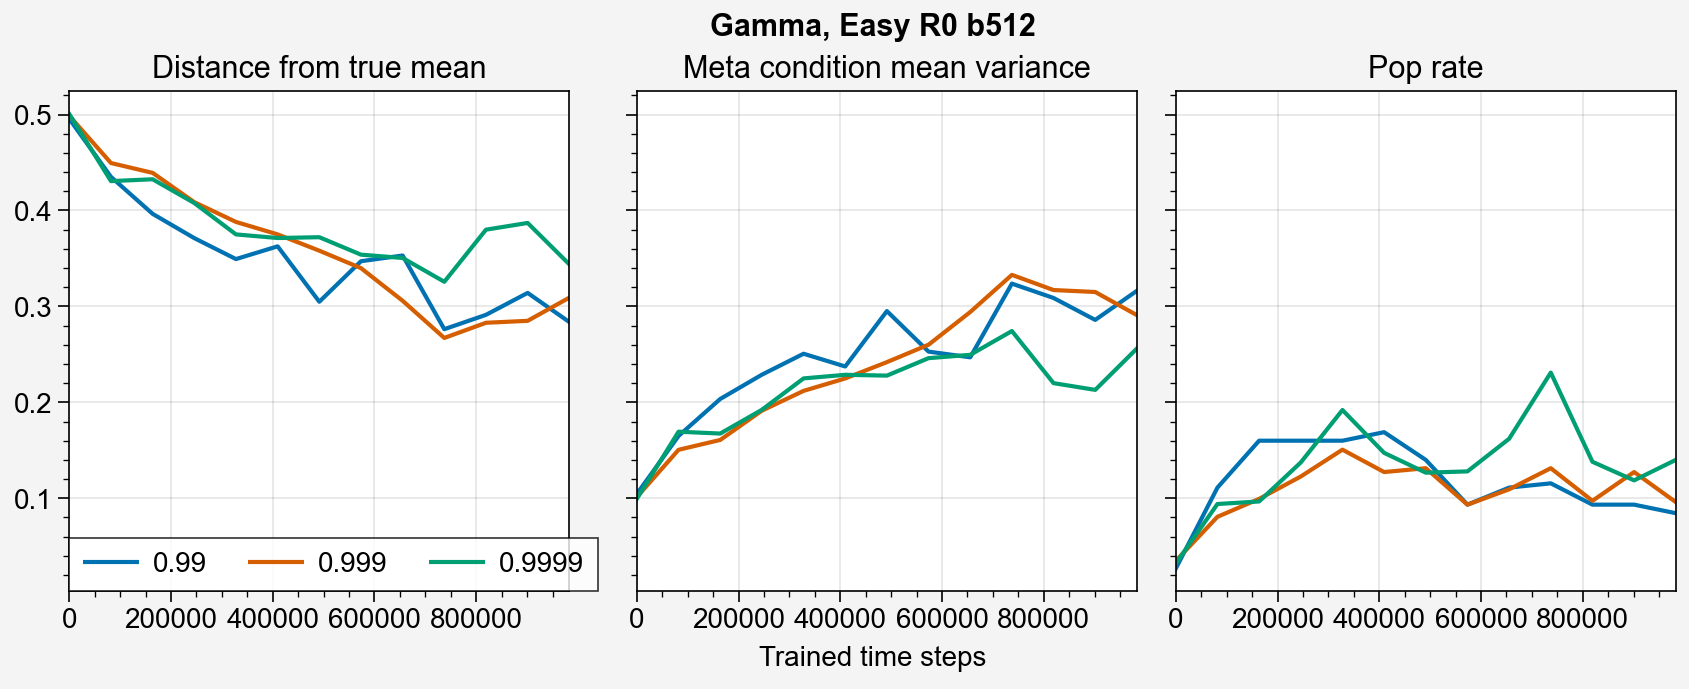

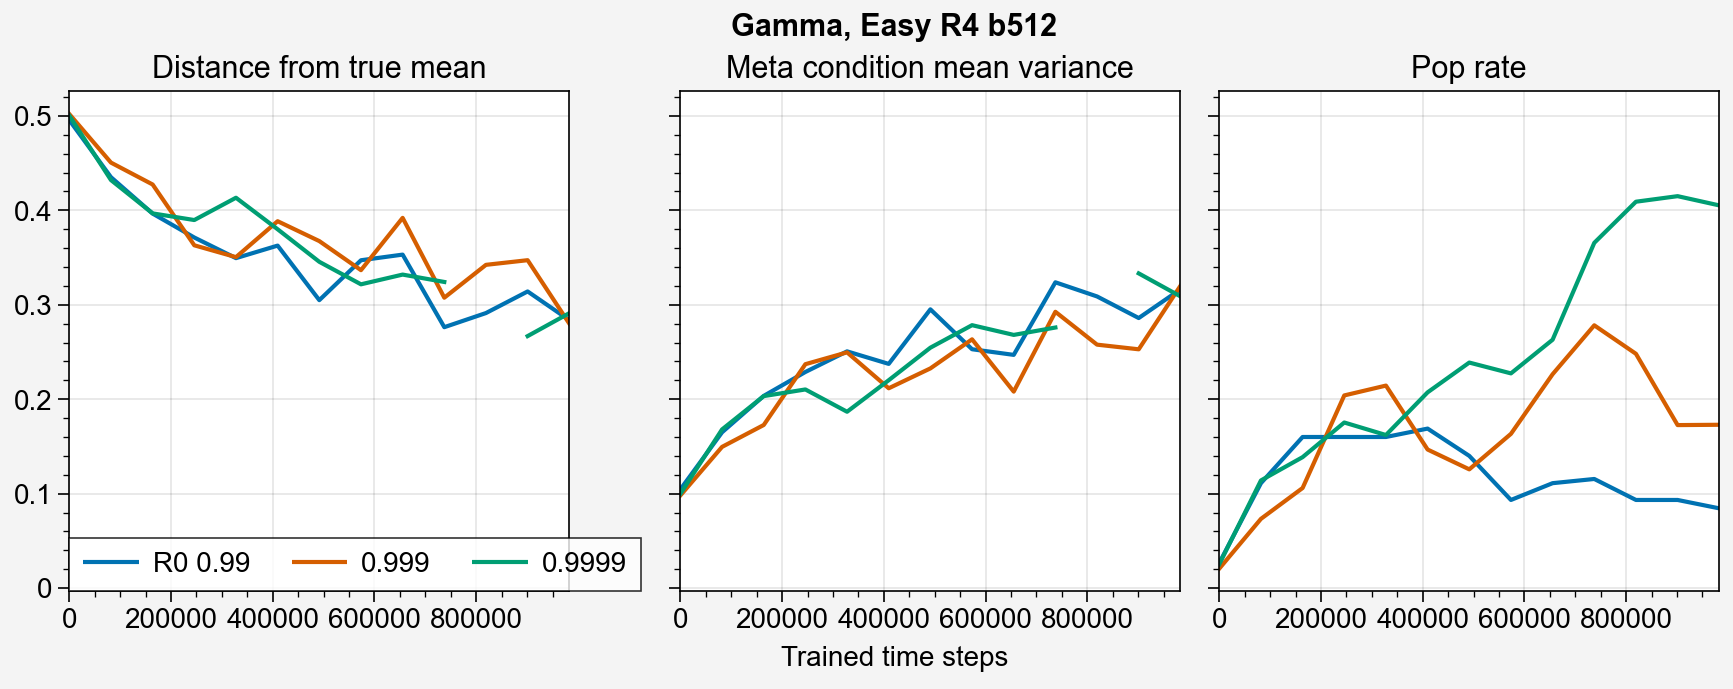

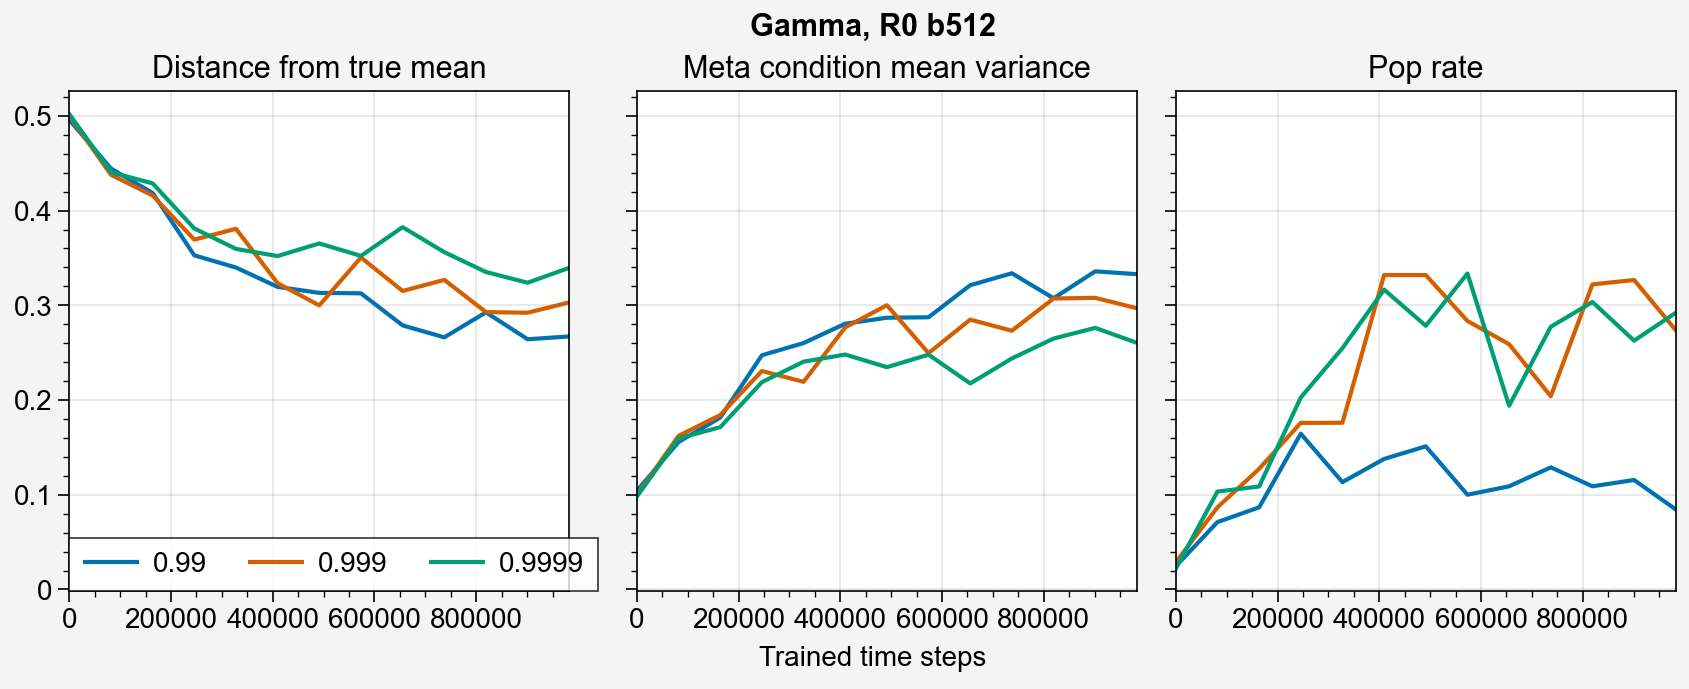

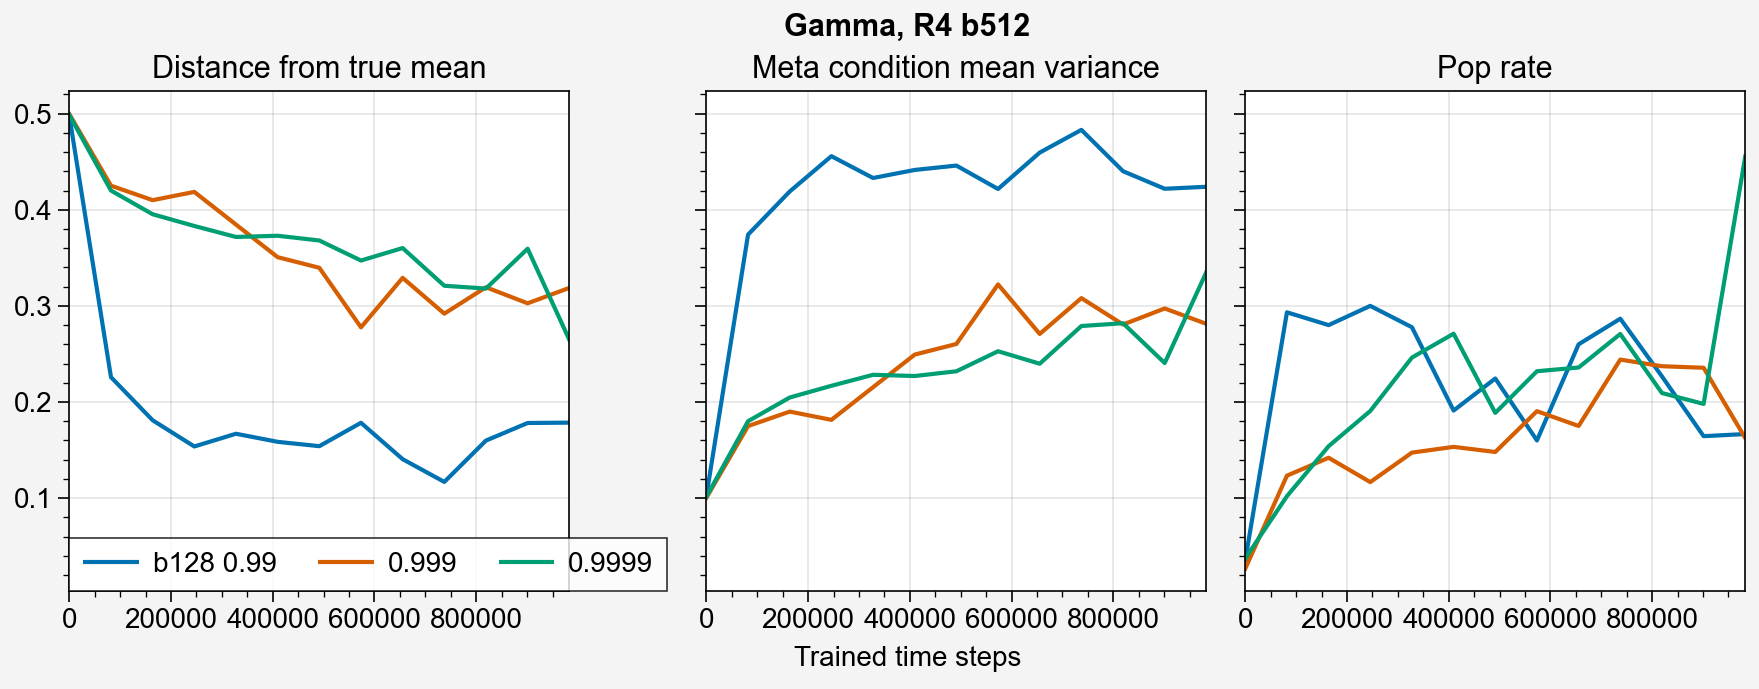

In [87]:
progressive_datag = pickle.load(open('data/meta1cg_progressive_fixed_mean_diffs', 'rb'))
progressive_data = pickle.load(open('data/meta1c_progressive_fixed_mean_diffs', 'rb'))
for key in progressive_data.keys():
    for sub in progressive_datag[key].keys():
        progressive_data[key][sub] = progressive_datag[key][sub]
comparisons = {
    'easyr0': {
        'title': 'Gamma, Easy R0 b512',
        'exp_types': ['easyr0n50b512', 'easyr0n50b512g3', 'easyr0n50b512g4'],
        'labels': ['0.99', '0.999', '0.9999']
    },
    'easyr4': {
        'title': 'Gamma, Easy R4 b512',
        'exp_types': ['easyr0n50b512', 'easyr4n50b512g3', 'easyr4n50b512g4'],
        'labels': ['R0 0.99', '0.999', '0.9999']
    },
    'r0': {
        'title': 'Gamma, R0 b512',
        'exp_types': ['r0n50b512', 'r0n50b512g3', 'r0n50b512g4'],
        'labels': ['0.99', '0.999', '0.9999']
    },
    'r4': {
        'title': 'Gamma, R4 b512',
        'exp_types': ['r4n50', 'r4n50b512g3', 'r4n50b512g4'],
        'labels': ['b128 0.99', '0.999', '0.9999']
    },
}

plot_type_titles = {
    'mean_diffs': 'Distance from true mean',
    'self_diffs': 'Meta condition variance',
    'pop_rates': 'Pop rate',
}
plot_type_titles = [
    'Distance from true mean',
    'Meta condition mean variance',
    'Pop rate'
]

for key in comparisons:
    fig, ax = pplt.subplots(ncols=3)
    exp_types = comparisons[key]['exp_types']
    labels = comparisons[key]['labels']

    for i, exp_type in enumerate(exp_types):
        batch_size = 128 #default
        batch_re = re.search('b\d+', exp_type)
        if batch_re:
            batch_size = int(batch_re[0][1:])
        chks = {
            128: np.arange(0, 490, 40),
            256: np.arange(0, 250, 20),
            512: np.arange(0, 130, 10),
        }[batch_size]
        x = chks*batch_size*16
        if exp_type in ['easyr0', 'easyr1', 'easyr2', 'easyr3']:
            x = np.arange(0, 250, 20)*128*16
        for j, plot_type in enumerate(progressive_data.keys()):
            data = np.array(progressive_data[plot_type][exp_type])
            y = data.mean(axis=2).mean(axis=0)
            ax[j].plot(x, y, label=str(labels[i]))
            ax[j].format(title=plot_type_titles[j])
    ax.format(xlabel='Trained time steps',
              suptitle=comparisons[key]['title'])
    ax[0].legend()

In [68]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta/meta_easyr4n50b512g3_0/60.pt')
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta/meta_r4n50b512g4_2/120.pt')
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta/meta_r4n50_1/120.pt')
res = fix_size_evalu(model, obs_rms)
# res = fix_size_easy_evalu(model, obs_rms)
# res = max_size_evalu(model, obs_rms)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this 

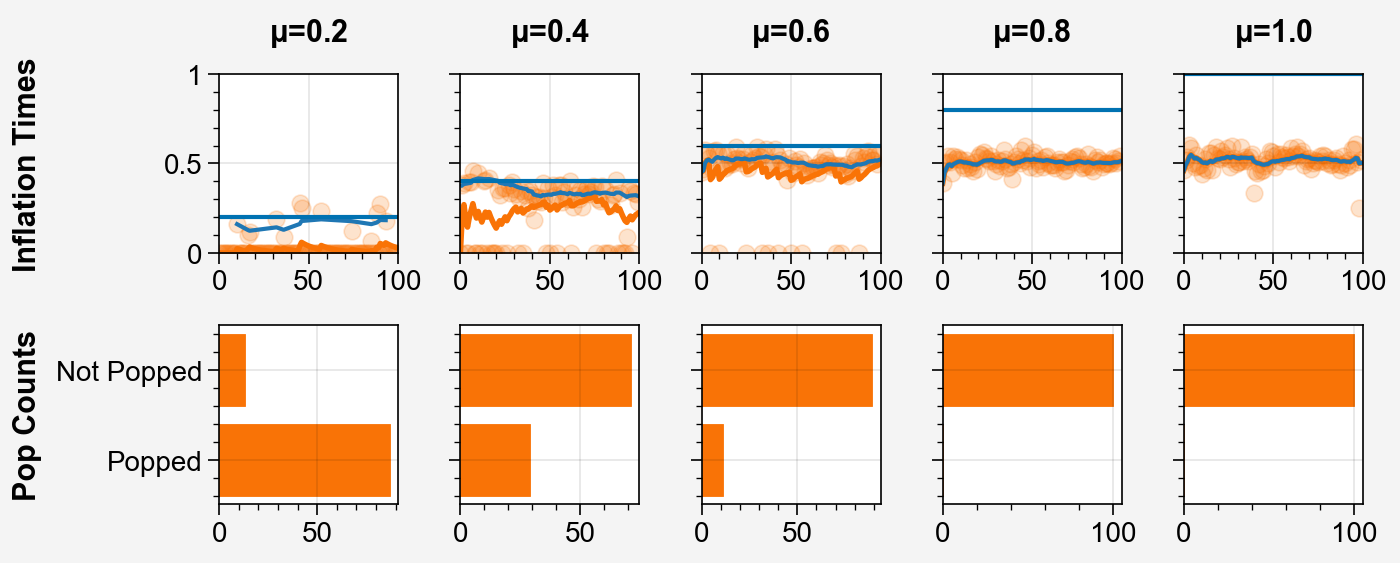

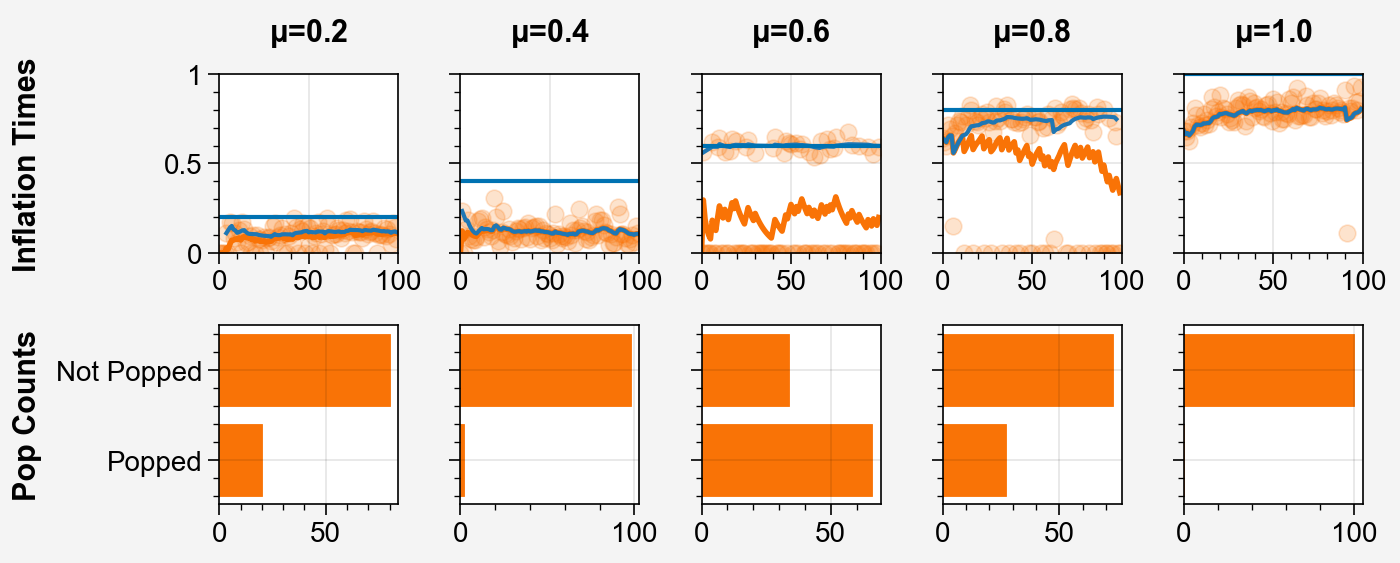

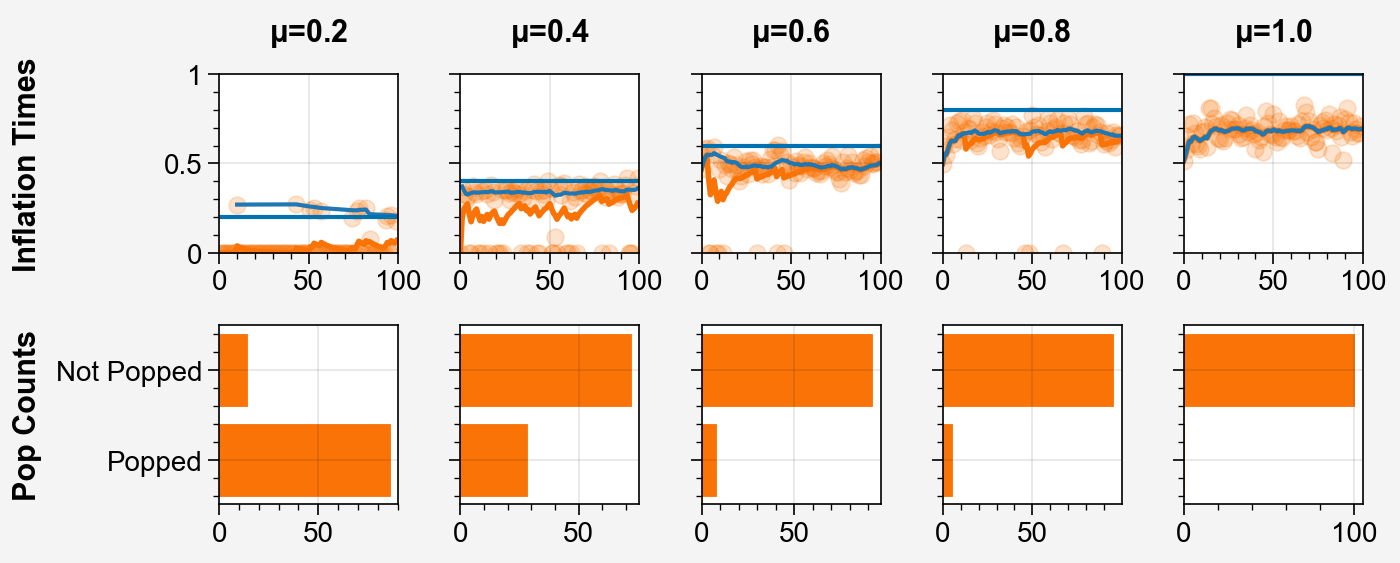

In [145]:
for t in range(3):
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta/meta_r4n50_{t}/120.pt')
    res = fix_size_evalu(model, obs_rms)
    plot_1color5fsize(res)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this 

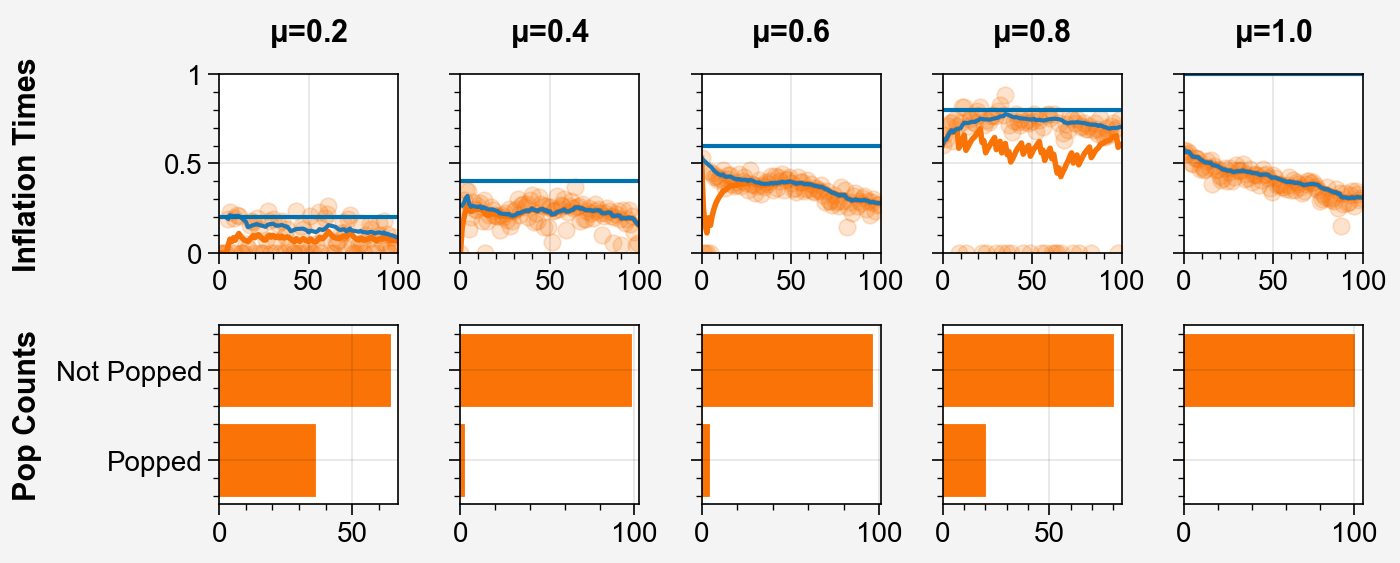

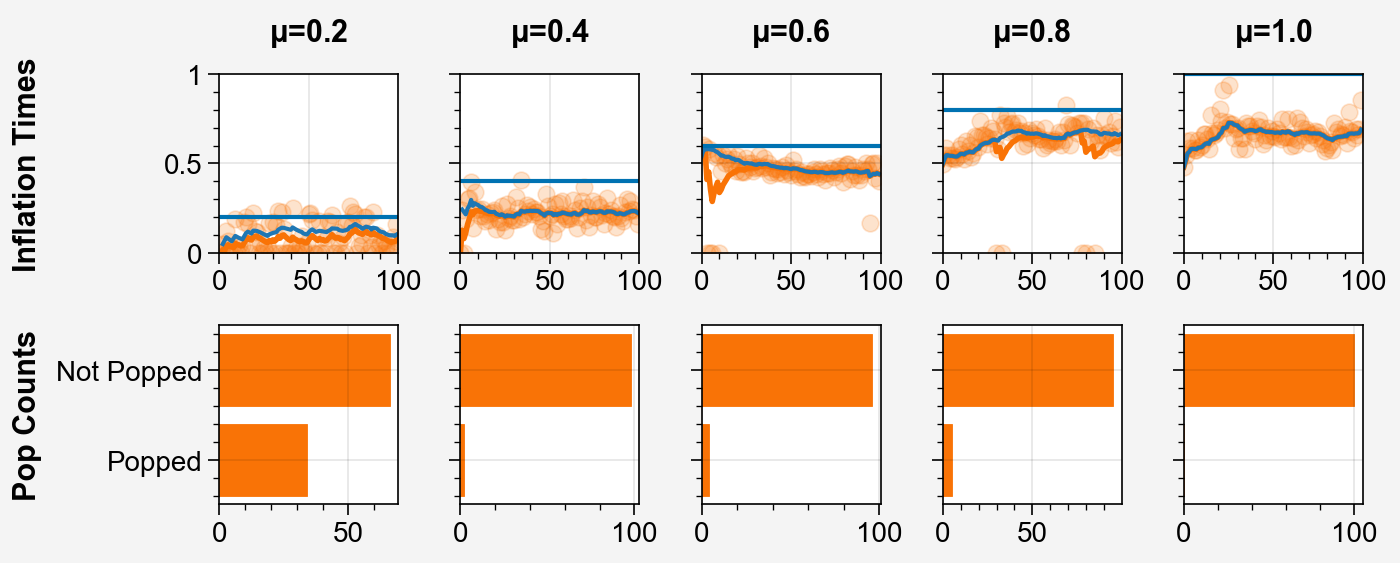

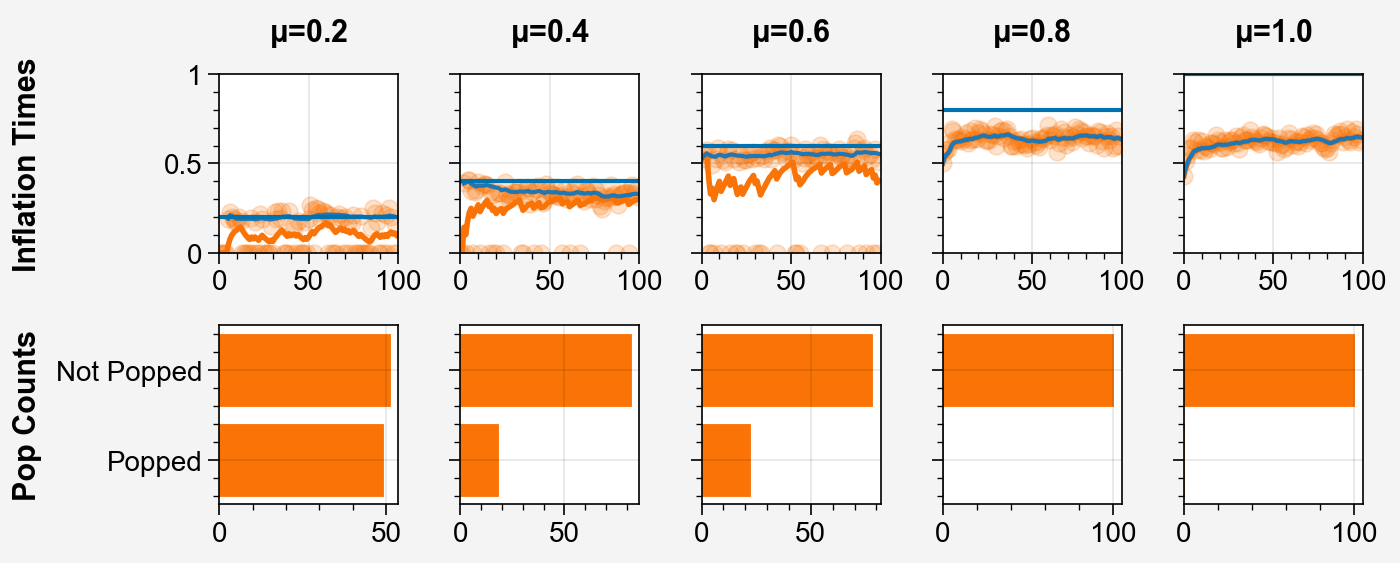

In [147]:
for t in range(3):
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta/meta_r4n50_{t}/480.pt')
    res = fix_size_evalu(model, obs_rms)
    plot_1color5fsize(res)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this 

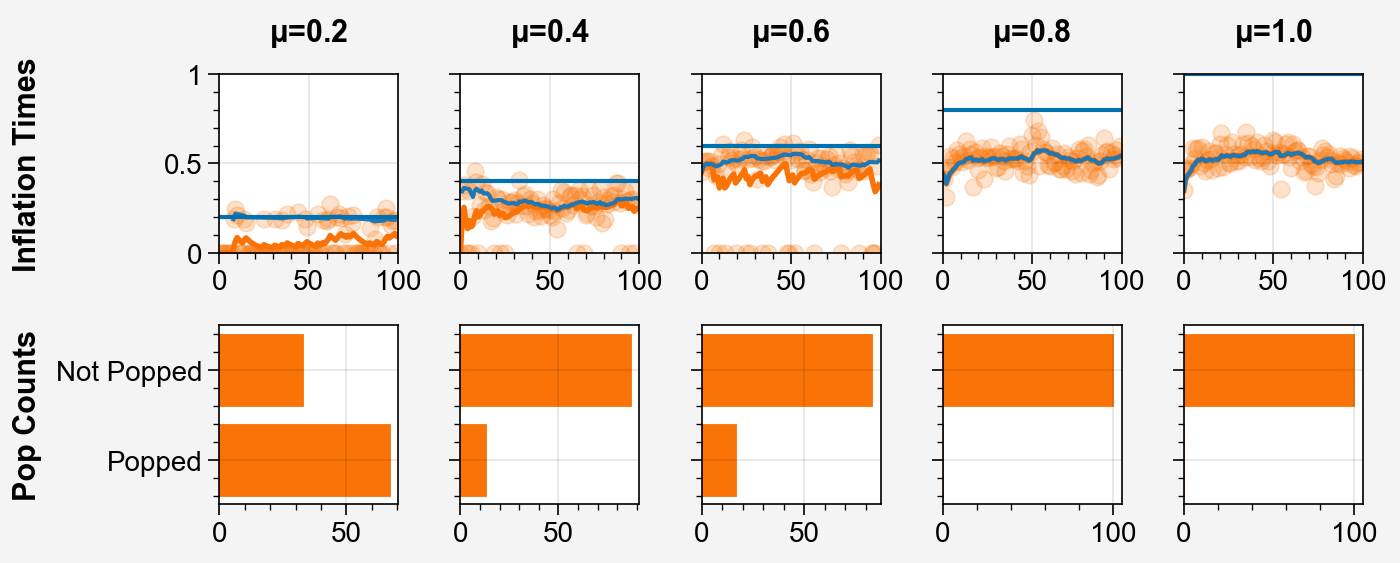

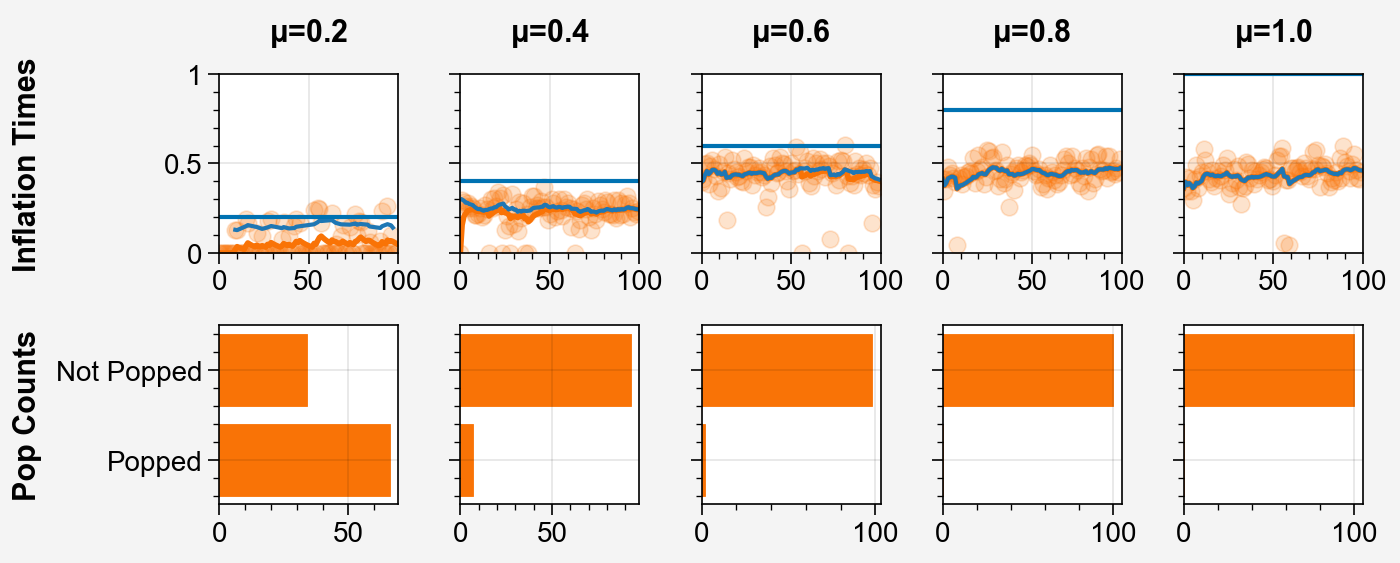

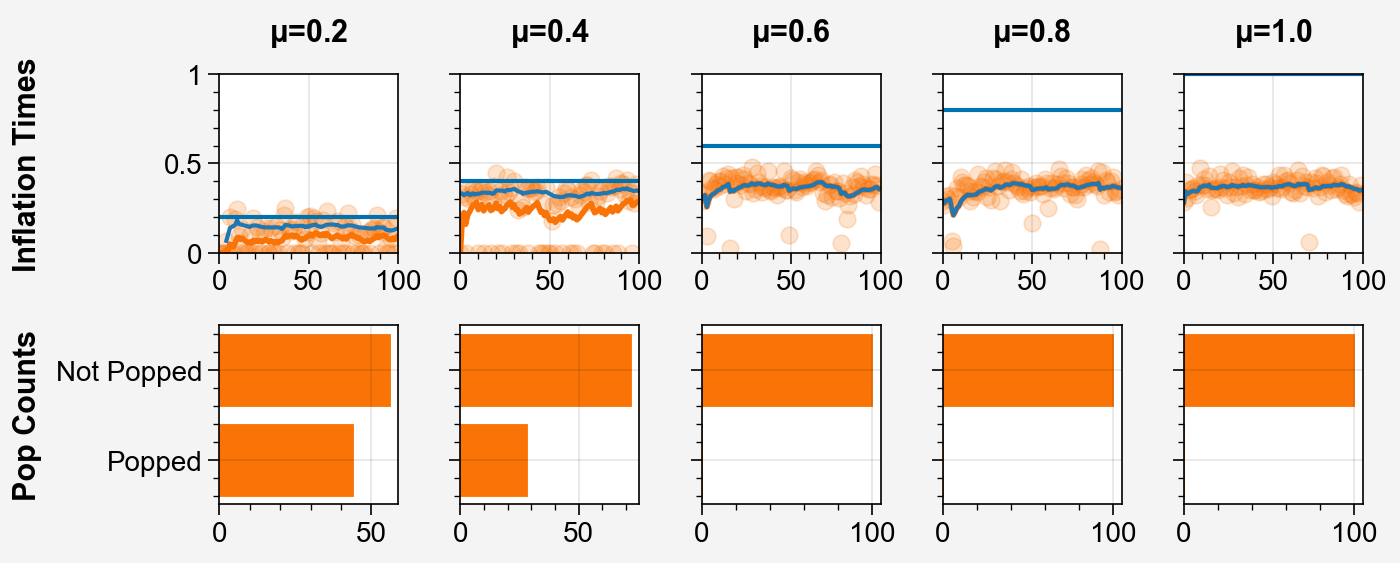

In [5]:
for t in range(3):
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta/meta_r0n50_{t}/120.pt')
    res = fix_size_evalu(model, obs_rms)
    plot_1color5fsize(res)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this 

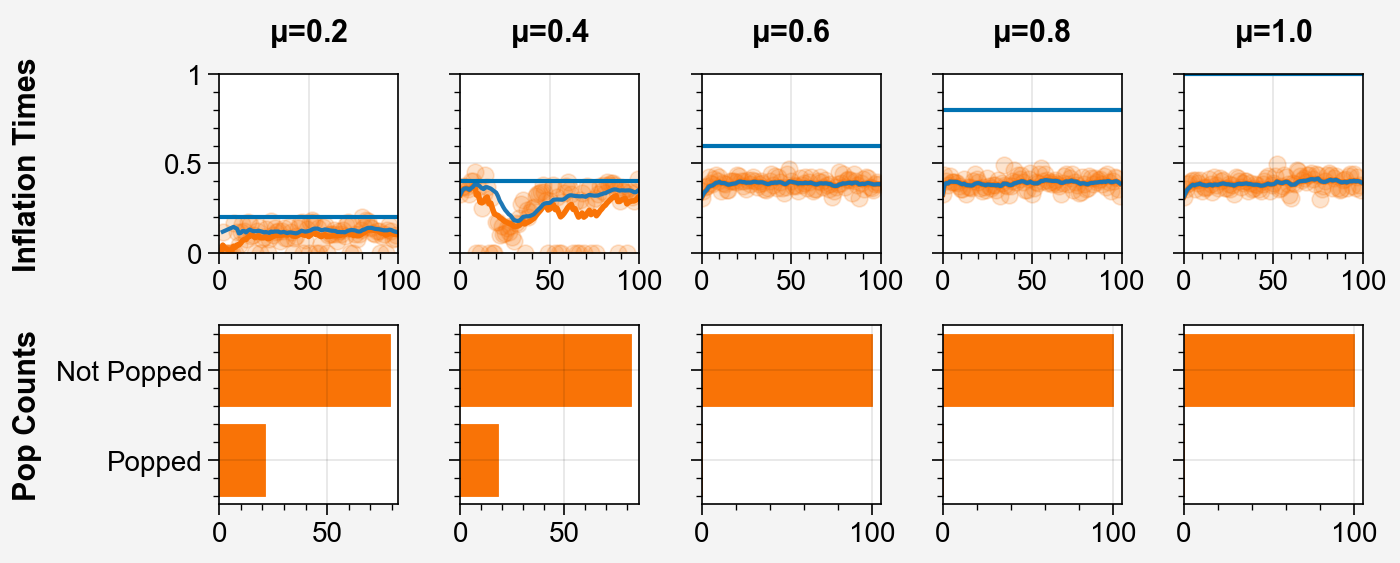

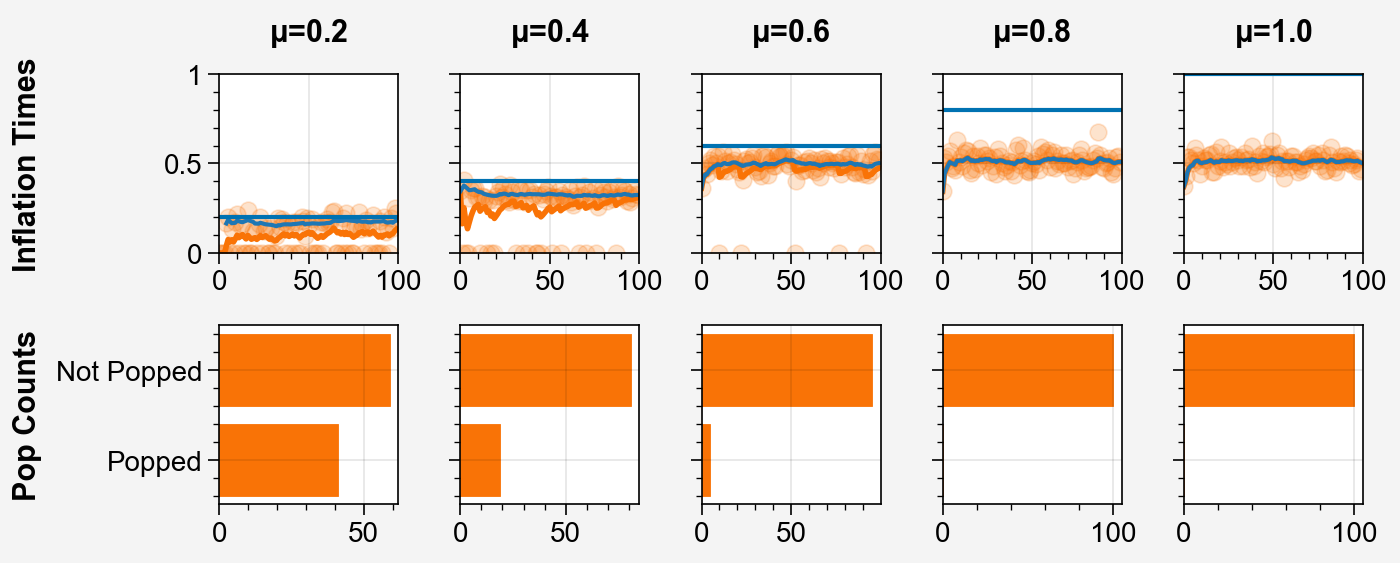

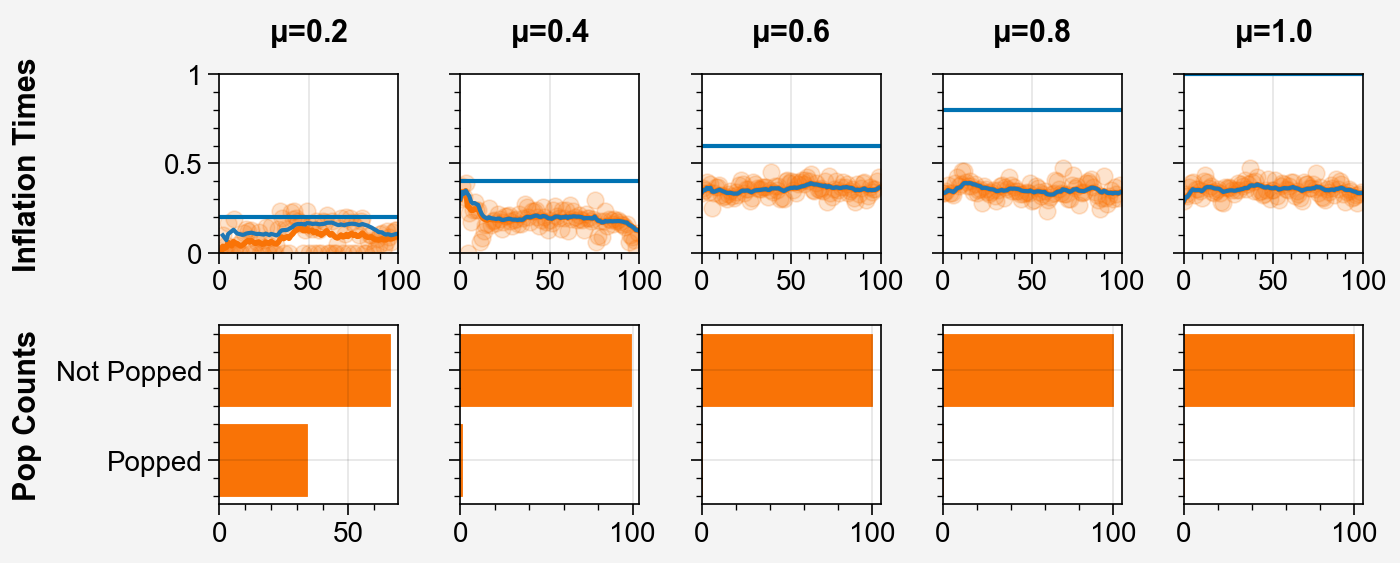

In [148]:
for t in range(3):
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta/meta_r0n50_{t}/480.pt')
    res = fix_size_evalu(model, obs_rms)
    plot_1color5fsize(res)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this 

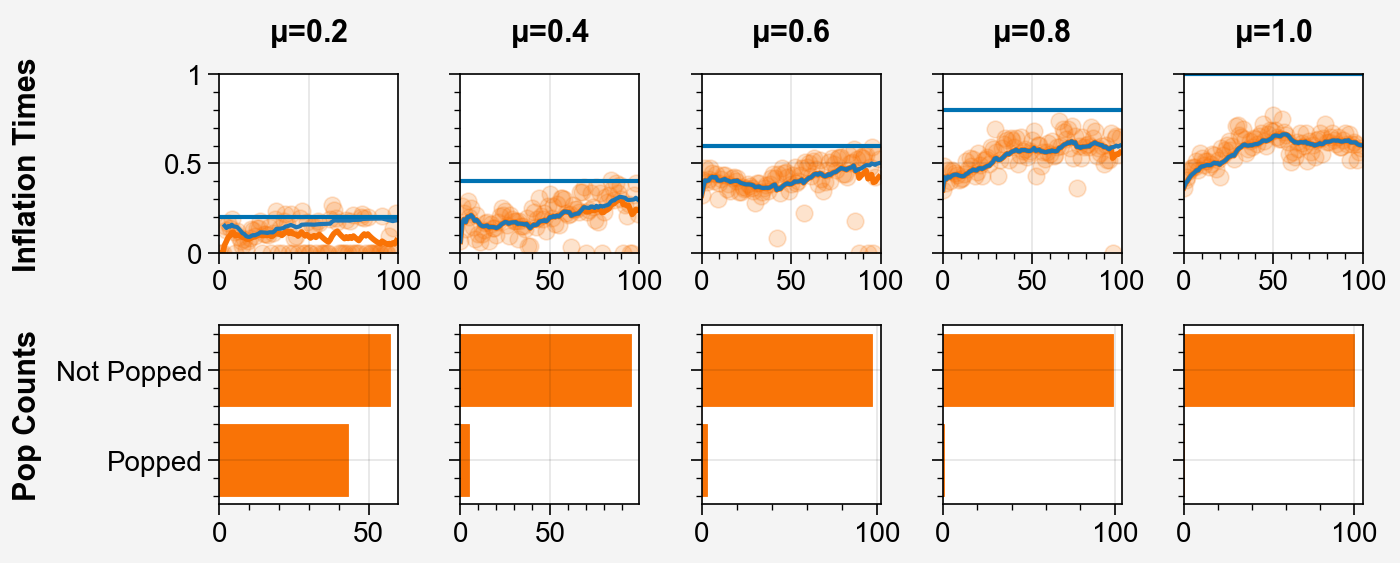

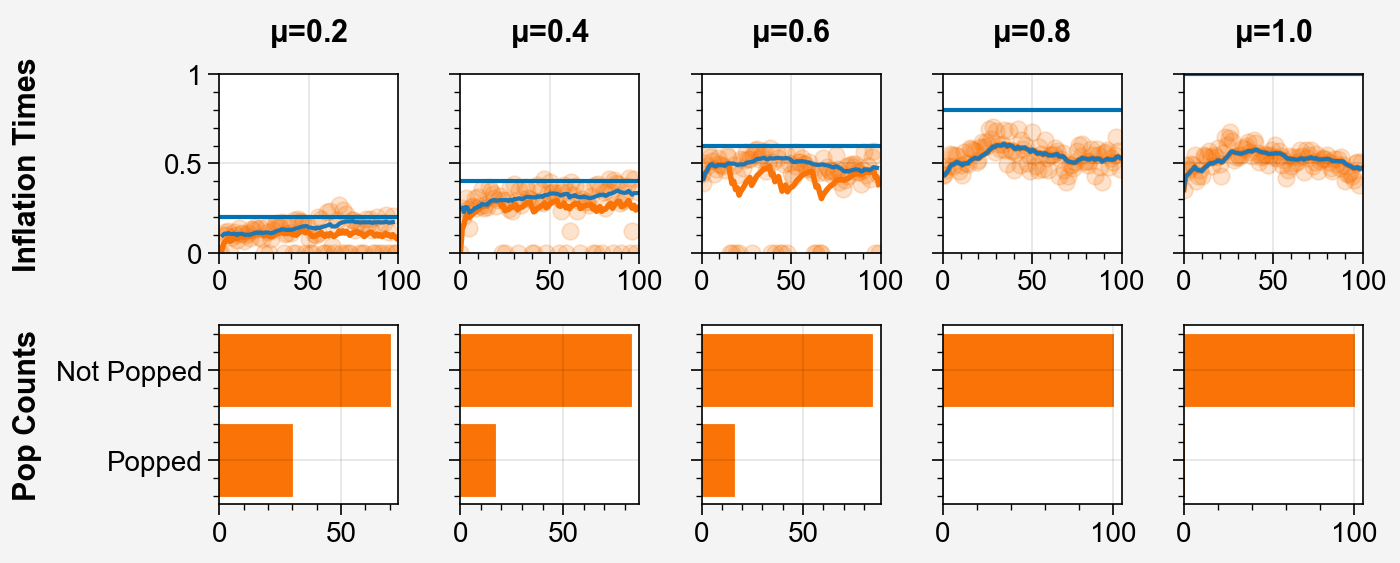

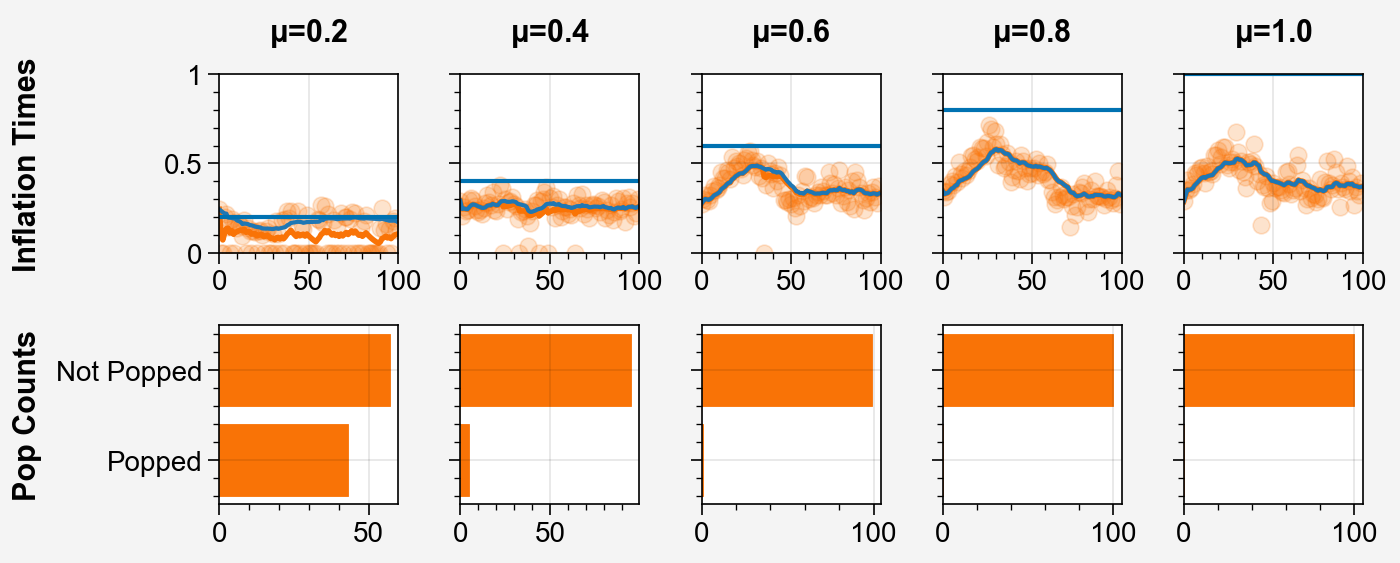

In [32]:
for t in range(3):
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta/meta_r0n30b512_{t}/120.pt')
    res = fix_size_evalu(model, obs_rms)
    plot_1color5fsize(res)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this 

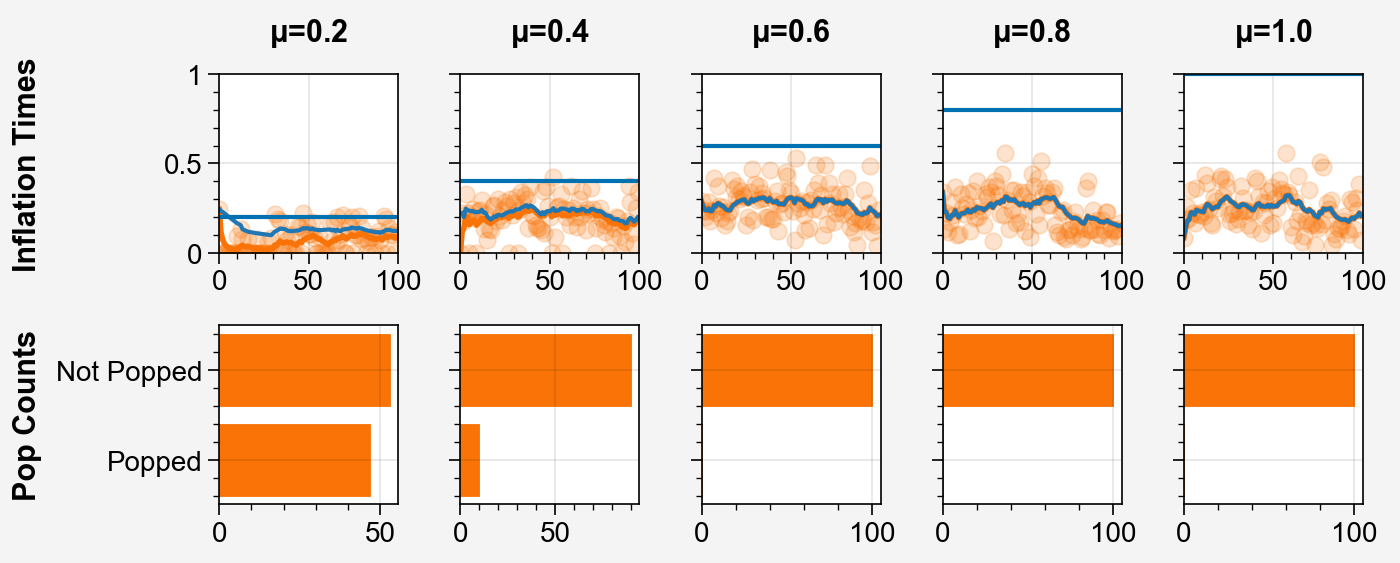

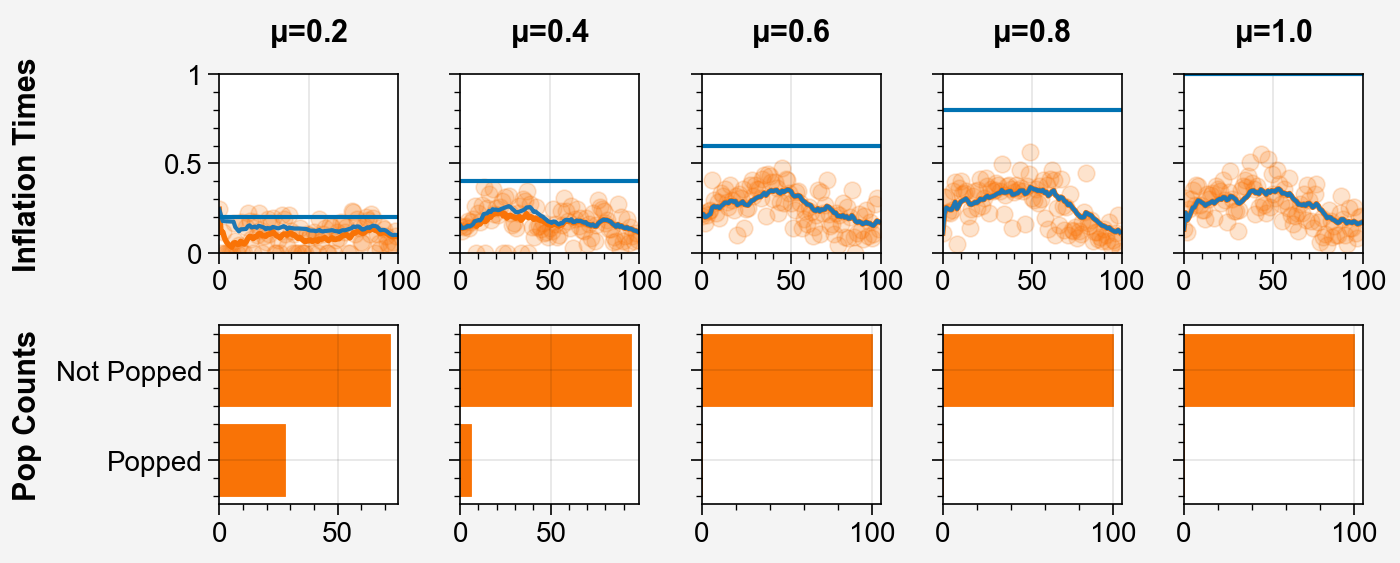

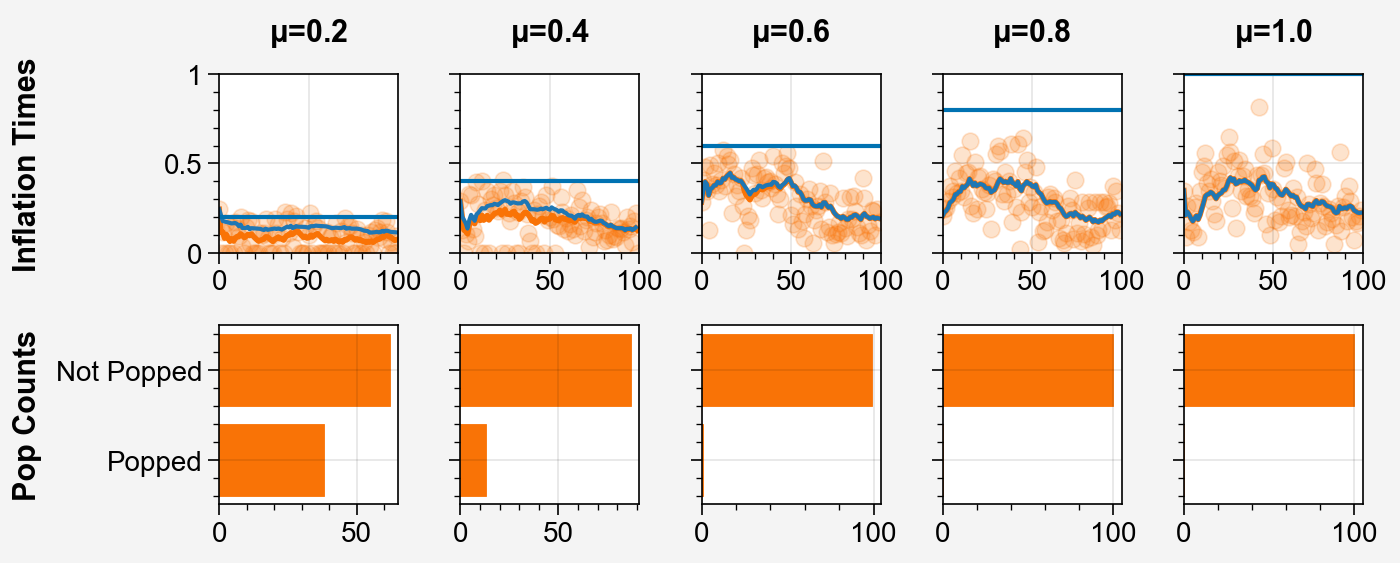

In [34]:
for t in range(3):
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta/meta_r0n50b512_{t}/40.pt')
    res = fix_size_evalu(model, obs_rms)
    plot_1color5fsize(res)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this 

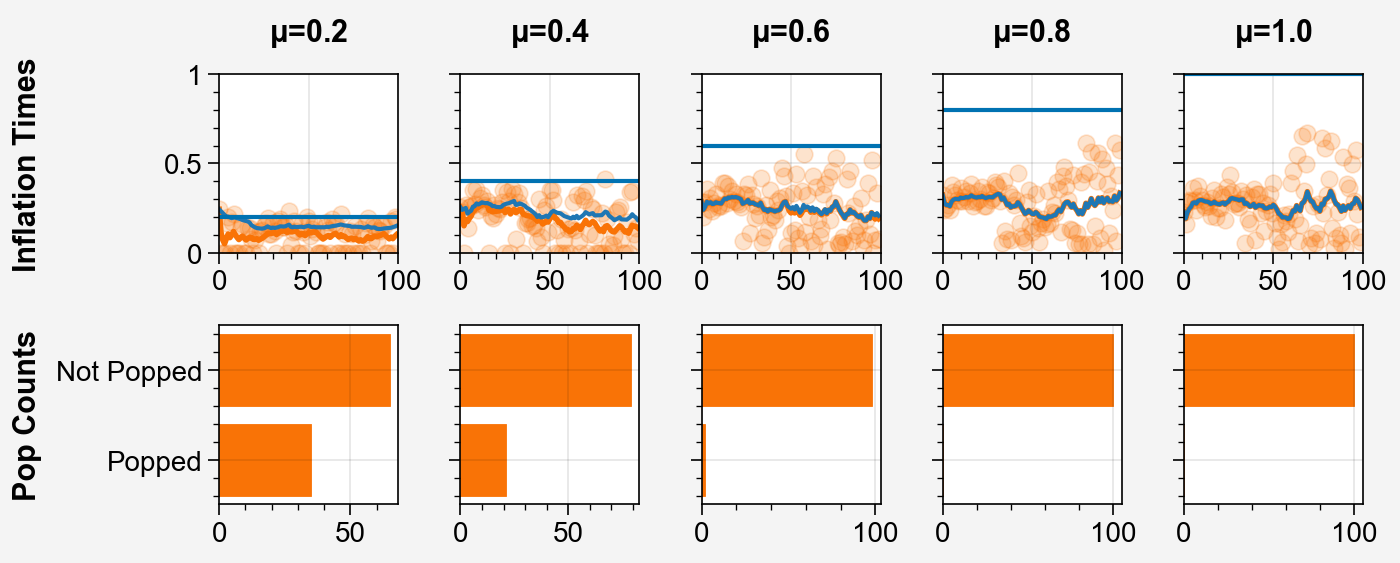

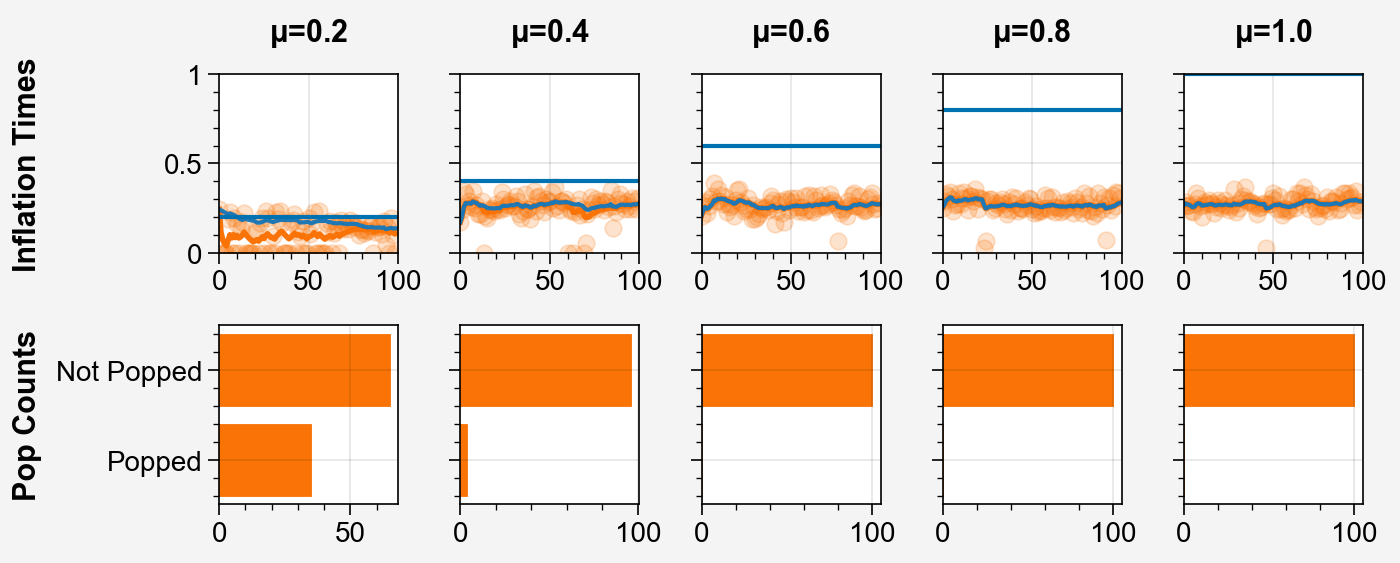

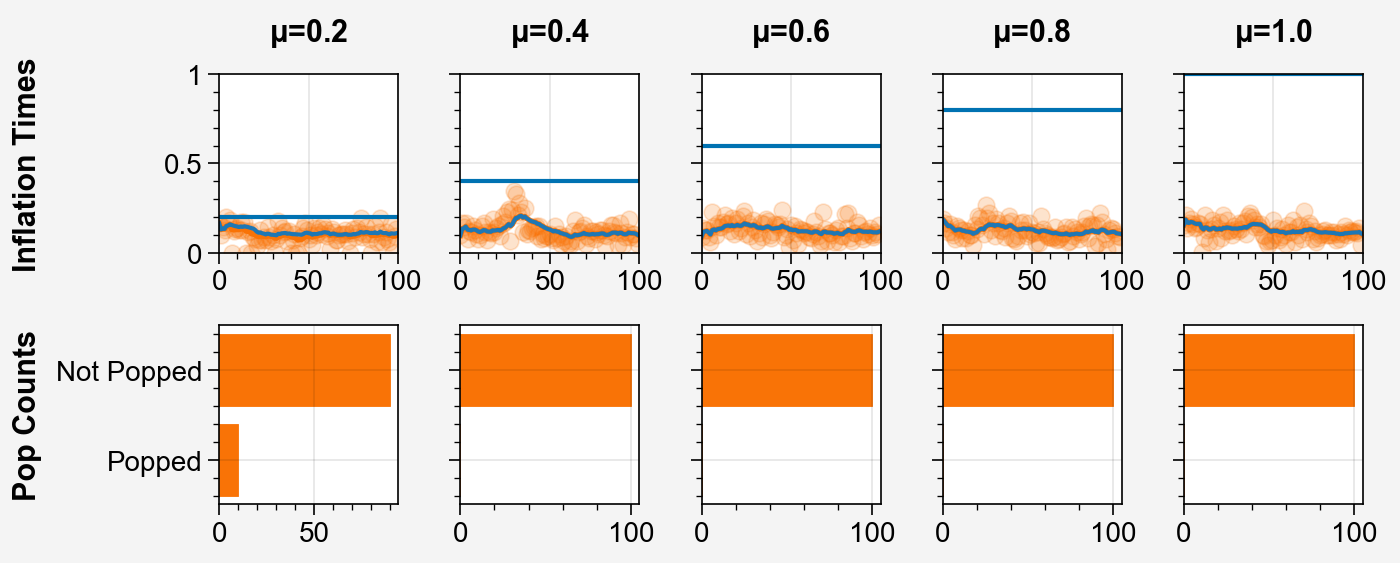

In [36]:
for t in range(3):
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta/meta_r0n50b256_{t}/120.pt')
    res = fix_size_evalu(model, obs_rms)
    plot_1color5fsize(res)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this 

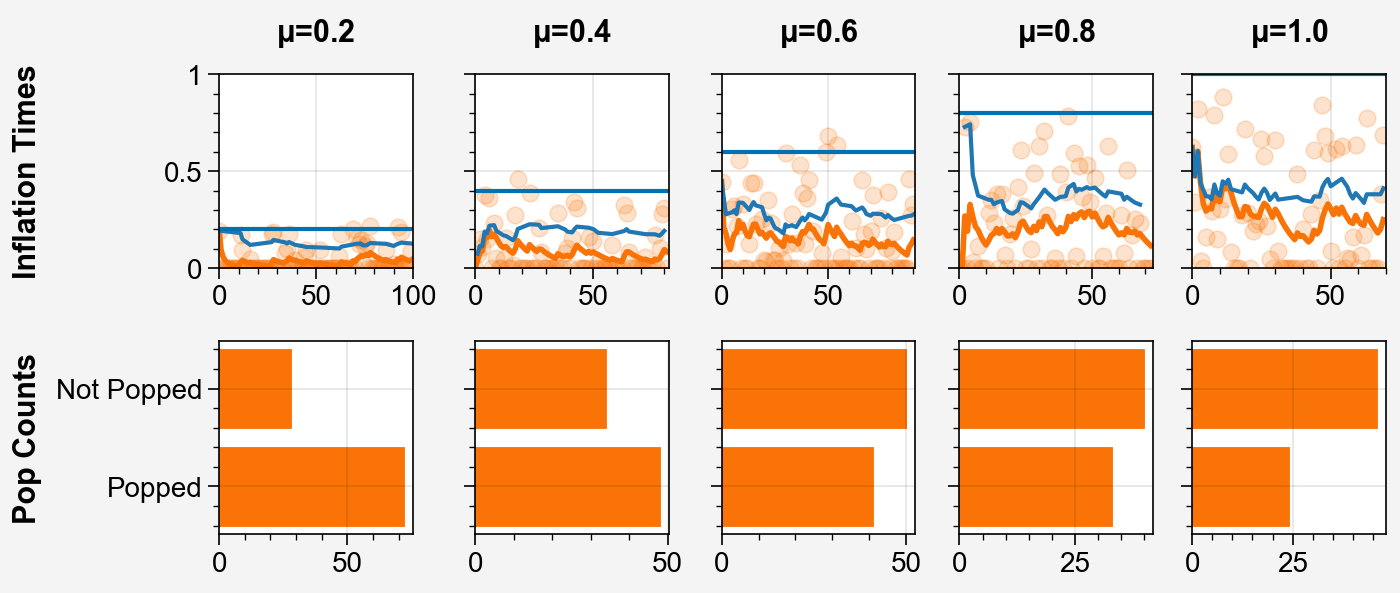

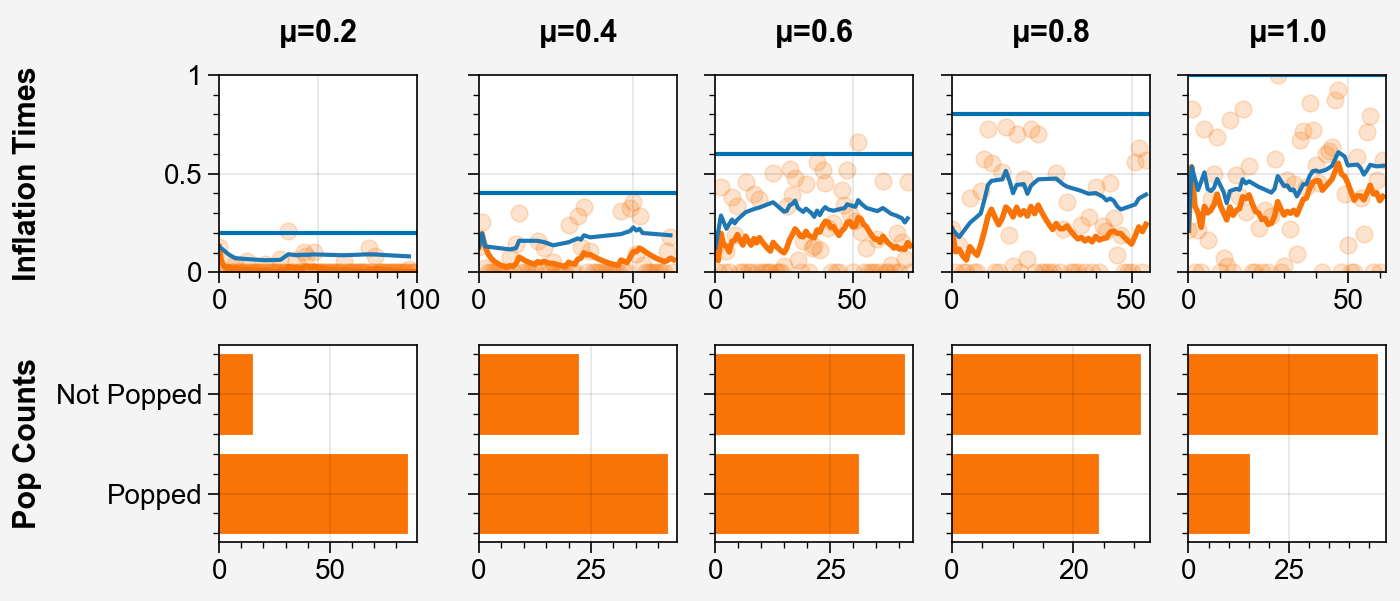

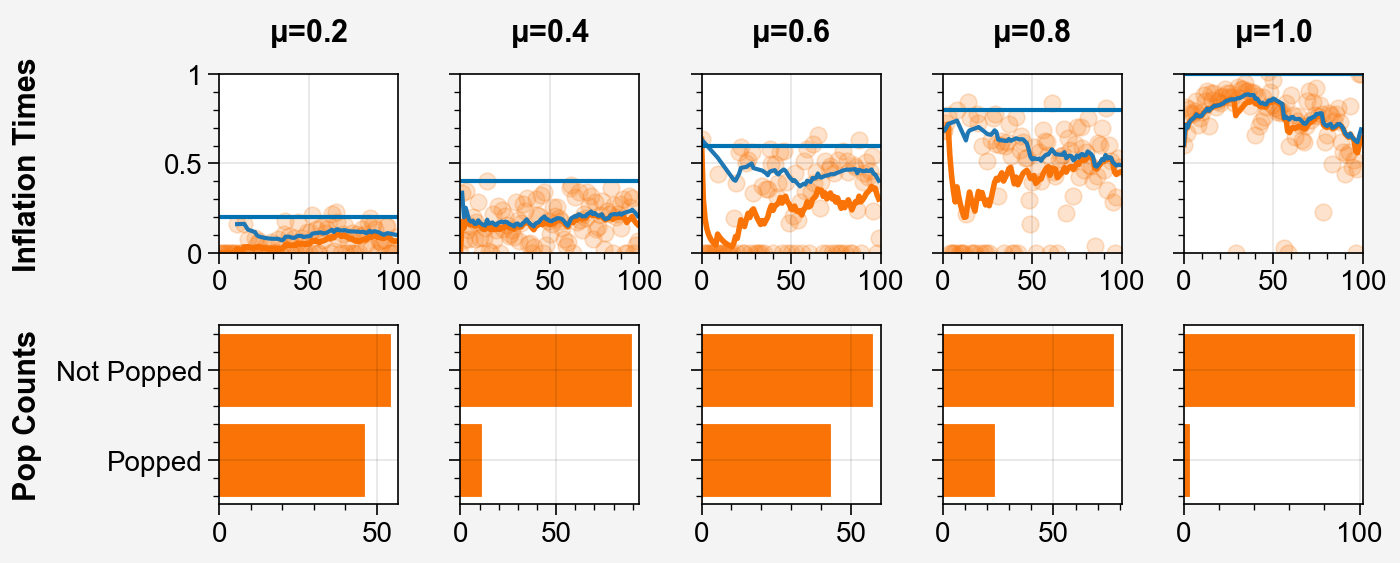

In [4]:
for t in range(3):
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta/meta_r4n50b512g4_{t}/120.pt')
    res = fix_size_evalu(model, obs_rms)
    plot_1color5fsize(res)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this 

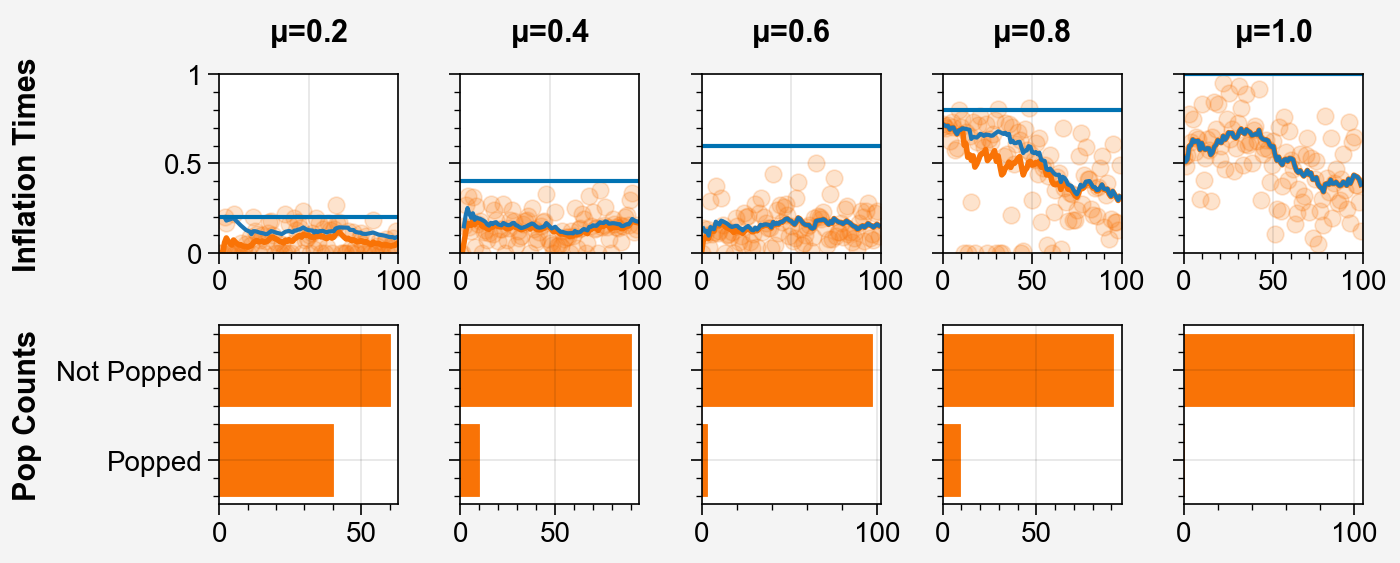

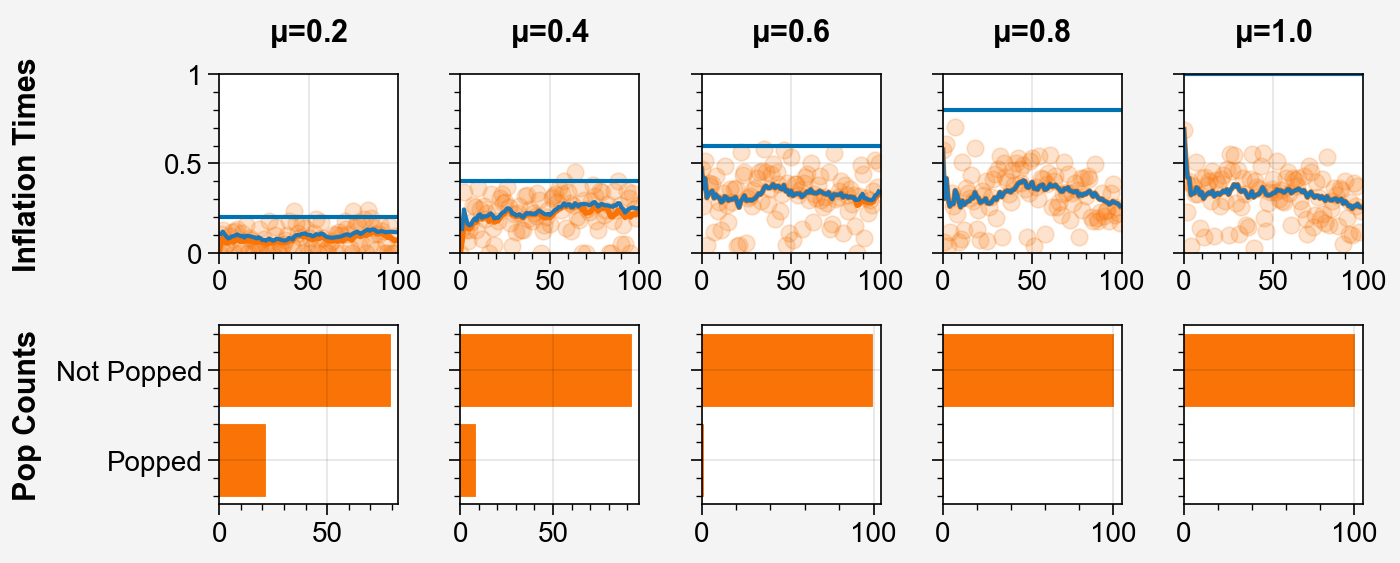

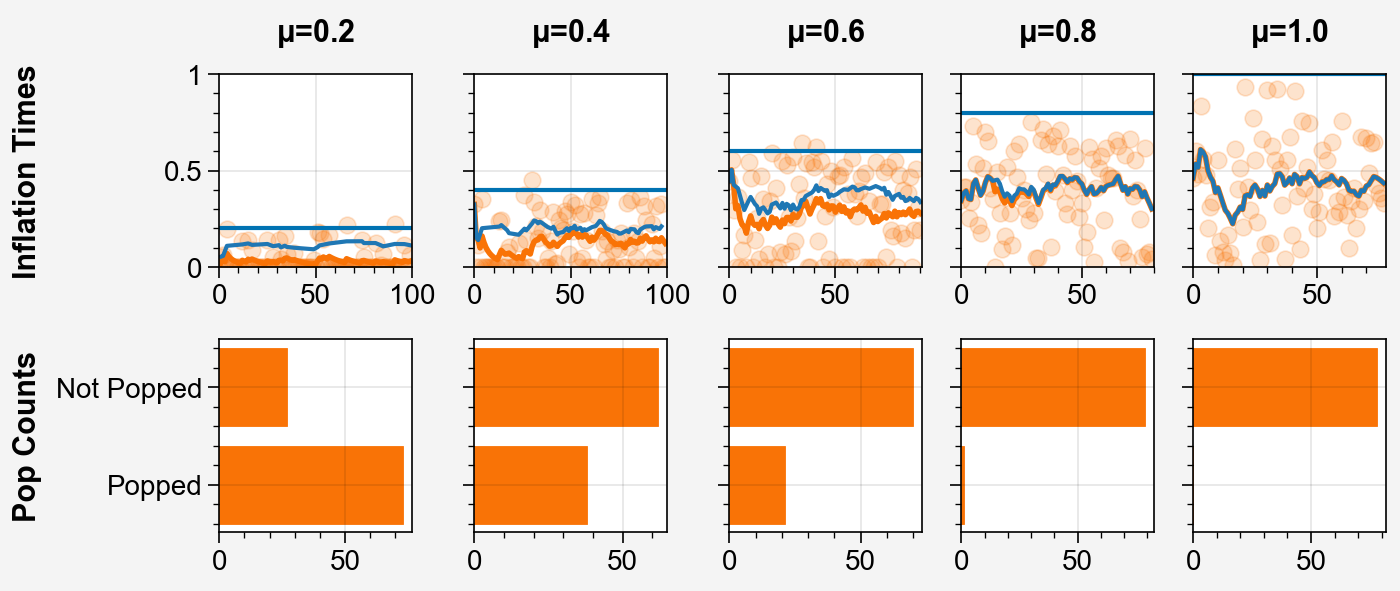

In [8]:
for t in range(3):
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta/meta_r4n50b512g3_{t}/120.pt')
    res = fix_size_evalu(model, obs_rms)
    plot_1color5fsize(res)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this 

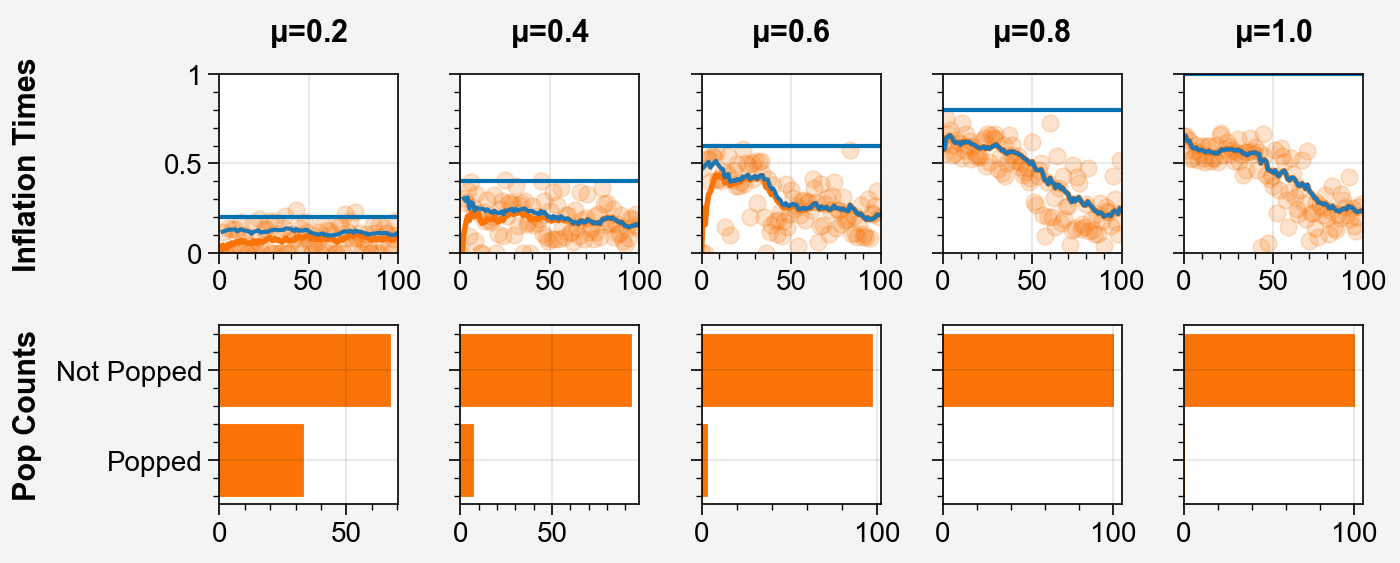

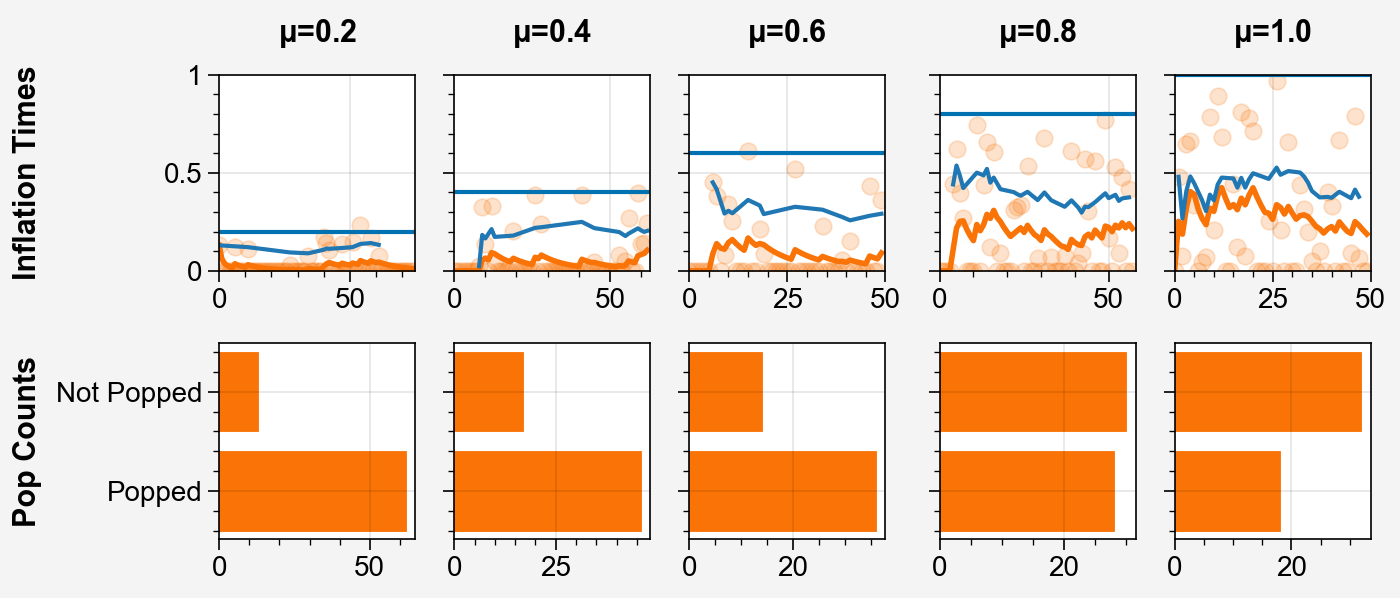

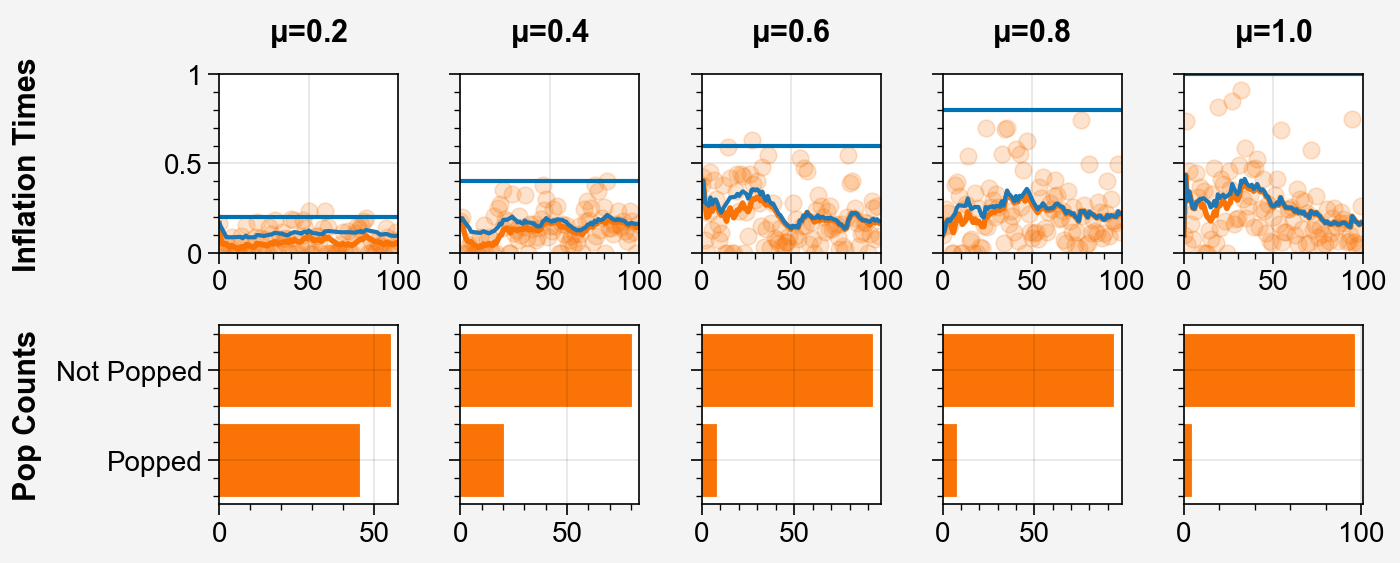

In [9]:
for t in range(3):
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta/meta_r0n50b512g4_{t}/120.pt')
    res = fix_size_evalu(model, obs_rms)
    plot_1color5fsize(res)

### Quantifying adaptability behavior

In [118]:
evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=13, 
                env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 1000, 'num_balloons': 100,
                            'fix_sizes': [0, [0.2, 0.25, 0.3, 0.35, 
                                              0.4, 0.45, 0.5, 0.55,
                                              0.6, 0.65, 0.7, 0.75, 
                                              0.8, 0.85, 0.9, 0.95, 1.0, 0], 0]}, 
                seed=1,
                deterministic=False)


fix_size_evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=5, 
                env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'rew_structure': 1, 'num_balloons': 100,
                            'fix_sizes': [0, [0.2, 0.4, 0.6, 0.8, 1.0, 0], 0]}, 
                seed=1,
                deterministic=False)

In [126]:
all_data = pickle.load(open('data/meta1c_progressive_pop_rates', 'rb'))
all_pop_rates = all_data['pop_rates']
all_mean_its = all_data['mean_its']
all_max_means = all_data['max_means']


In [128]:
# all_pop_rates = {}
# all_mean_its = {}
# all_max_means = {}

all_exp_variants = [
    'easyr0n30', 'easyr0n50', 'easyr0n70',
    'easyr0', 'easyr1', 'easyr2', 'easyr3', 'easyr4', 'easyr5',
    'easyr4b256', 'easyr4b512', 
    'r4n50', 'r0n50', 'easyr4n50',
    'r4',
    'r0n50b128', 'r0n50b256', 'r0n50b512',
    'easyr0n50b128', 'easyr0n50b256', 'easyr0n50b512',
    'r0n30b128', 'r0n30b256', 'r0n30b512',
    'easyr0n50b512g3', 'easyr0n50b512g4', 
    'easyr4n50b512g3', 'easyr4n50b512g4', 
    'r0n50b512g3', 'r0n50b512g4', 
    'r4n50b512g3', 'r4n50b512g4', 
    'r0g995', 'r4g995'
]

for i, exp_type in enumerate(tqdm(all_exp_variants)):
    
    batch_size = 128 #default
    batch_re = re.search('b\d+', exp_type)
    if batch_re:
        batch_size = int(batch_re[0][1:])
    chks = {
        128: np.arange(0, 490, 40),
        256: np.arange(0, 250, 20),
        512: np.arange(0, 130, 10),
    }[batch_size]
    # Special case for easyr\d: only 500k steps trained
    if exp_type in ['easyr0', 'easyr1', 'easyr2', 'easyr3']:
        chks = np.arange(0, 250, 20)
    
    # print(exp_type, chks)
    if exp_type in all_pop_rates:
        continue
    all_pop_rates[exp_type] = []
    all_mean_its[exp_type] = []
    all_max_means[exp_type] = []
    for t in range(3):
        t_pop_rates = []
        t_mean_its = []
        t_max_means = []

        for chk in chks:
            exp_name = f'meta_{exp_type}_{t}'

            model, (obs_rms, ret_rms) = torch.load(f'../saved_checkpoints/meta/{exp_name}/{chk}.pt')
            res = evalu(model, obs_rms)
            tested_means = [d[1] for d in res['data']['balloon_means']] 
            pop_rates = []
            mean_it = []
            for i in range(len(tested_means)):
                popped = np.array(res['data']['popped'][i])
                it = np.array(res['data']['last_size'][i])
                pop_rates.append(np.mean(popped))
                mean_it.append(np.mean(it[~popped]))
            max_mean = np.mean(res['data']['last_size'][-1])
            
            t_pop_rates.append(pop_rates)
            t_mean_its.append(mean_it)
            t_max_means.append(max_mean)
        all_pop_rates[exp_type].append(t_pop_rates)
        all_mean_its[exp_type].append(t_mean_its)
        all_max_means[exp_type].append(t_max_means)

    pickle.dump({
        'pop_rates': all_pop_rates,
        'mean_its': all_mean_its,
        'max_means': all_max_means,
    }, open('data/meta1c_progressive_pop_rates', 'wb'))

  0%|          | 0/34 [00:00<?, ?it/s]c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 34/34 [18:10<00:00, 32.08s/it]


In [107]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta/meta_r0n50_1/480.pt')
res = evalu(model, obs_rms)
# fixed_res = fix_size_evalu(model, obs_rms)
# plot_1color5fsize(fixed_res)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


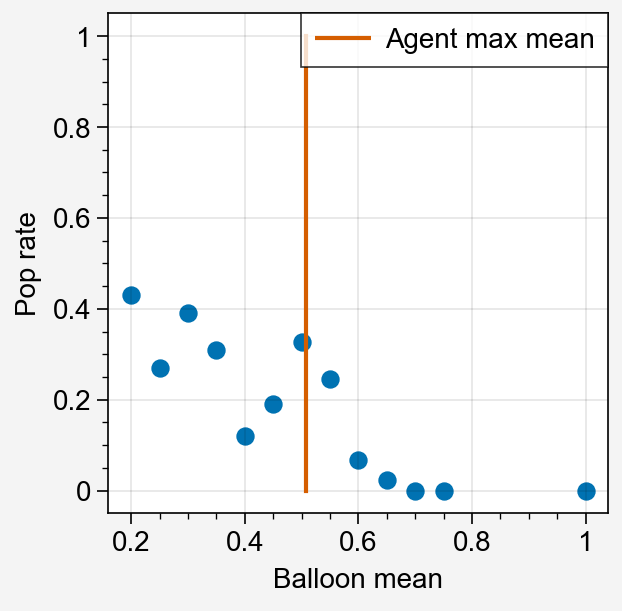

In [116]:
tested_means = [d[1] for d in res['data']['balloon_means']] 
pop_rates = []
mean_it = []
for i in range(len(tested_means)):
    popped = np.array(res['data']['popped'][i])
    it = np.array(res['data']['last_size'][i])
    pop_rates.append(np.mean(popped))
    mean_it.append(np.mean(it[~popped]))
max_mean = np.mean(res['data']['last_size'][-1])

fig, ax = pplt.subplots()
ax.scatter(tested_means, pop_rates)
ax.plot([max_mean, max_mean], [0, 1.0], label='Agent max mean')
ax.format(xlabel='Balloon mean', ylabel='Pop rate')
ax.legend(loc='ur')

In [74]:
pop_rates = []
for i in range(7):
    pop_rates.append(np.mean(res['data']['popped'][i]))
max_mean = np.mean(res['data']['last_size'][-1])

### Long term adaptability with rewards given

In [26]:
evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=5, 
                env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 1000, 'num_balloons': 30}, seed=1,
                deterministic=False)

fix_size_evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=5, 
                env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'rew_structure': 1, 'num_balloons': 100,
                            'fix_sizes': [0, [0.2, 0.4, 0.6, 0.8, 1.0, 0], 0],
                            'give_rew': True,}, 
                seed=1,
                deterministic=False)
fix_size_easy_evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=5, 
                env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'rew_structure': 1, 'num_balloons': 100,
                            'inflate_noise': 0, 'pop_noise': 0,
                            'fix_sizes': [0, [0.2, 0.4, 0.6, 0.8, 1.0, 0], 0],
                            'give_rew': True,}, 
                seed=1,
                deterministic=False)
max_size_evalu = partial(forced_action_evaluate, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs={'meta_setup': 1, 'colors_used': 1, 
                            'rew_structure': 1, 'num_balloons': 200,
                            'fix_sizes': [0, 1.0, 0],
                            'give_rew': True}, 
                seed=1,
                deterministic=False)

In [14]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta/meta_r0n50b256rew_1/200.pt')
res = fix_size_evalu(model, obs_rms)
# res = fix_size_easy_evalu(model, obs_rms)
# res = max_size_evalu(model, obs_rms)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


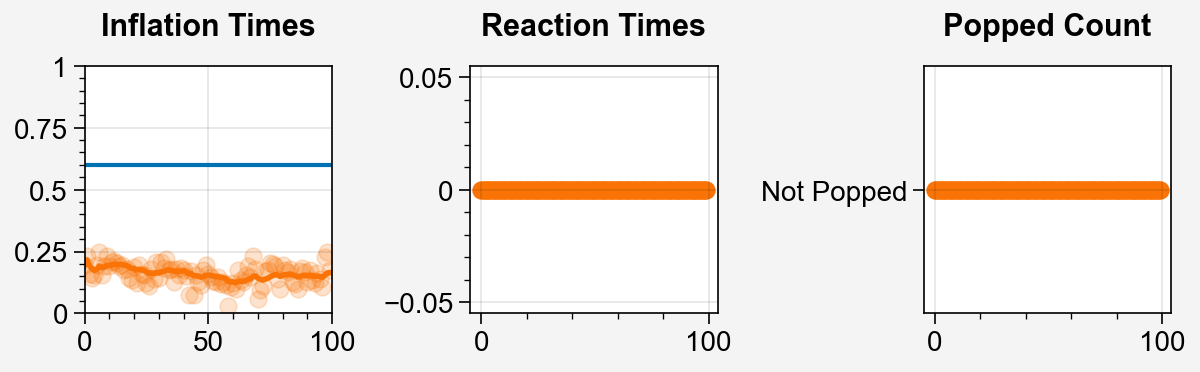

In [15]:
plot_ncolor_meta_progression(res, num_colors=1, ep_num=2)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this 

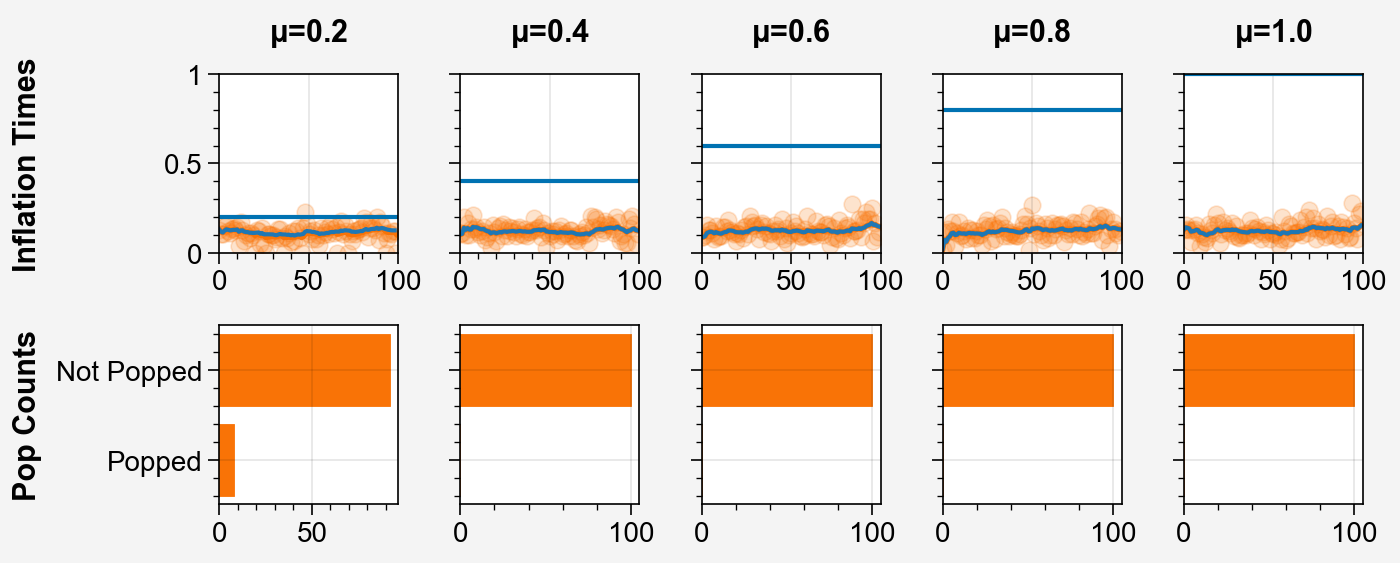

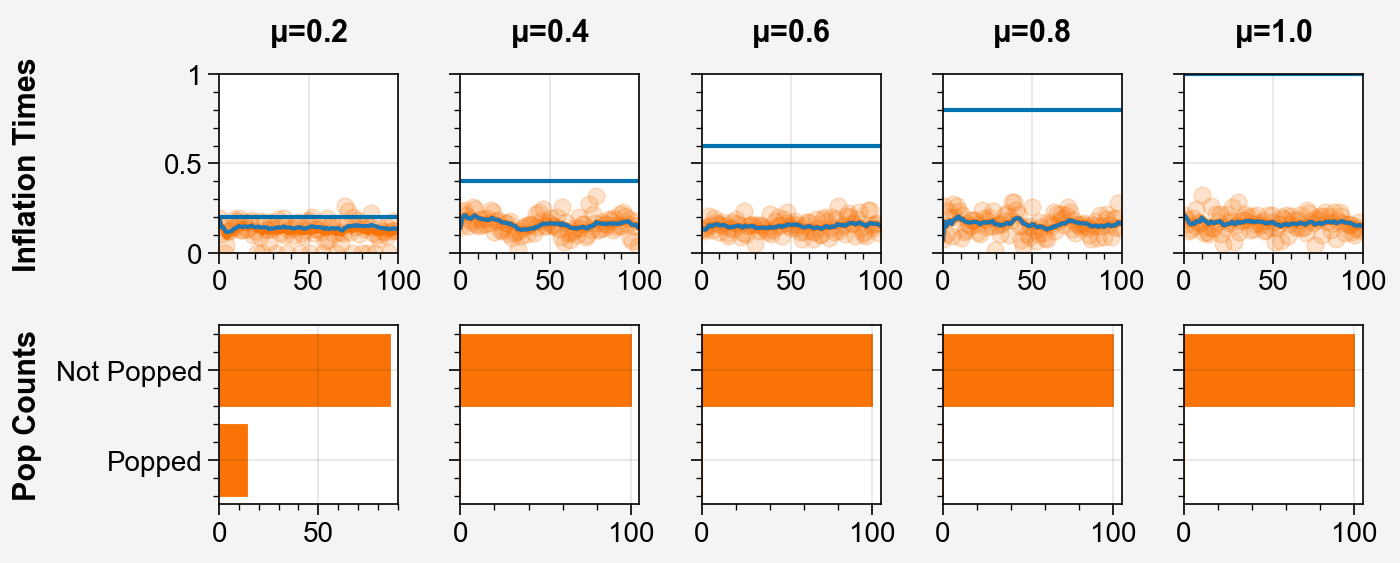

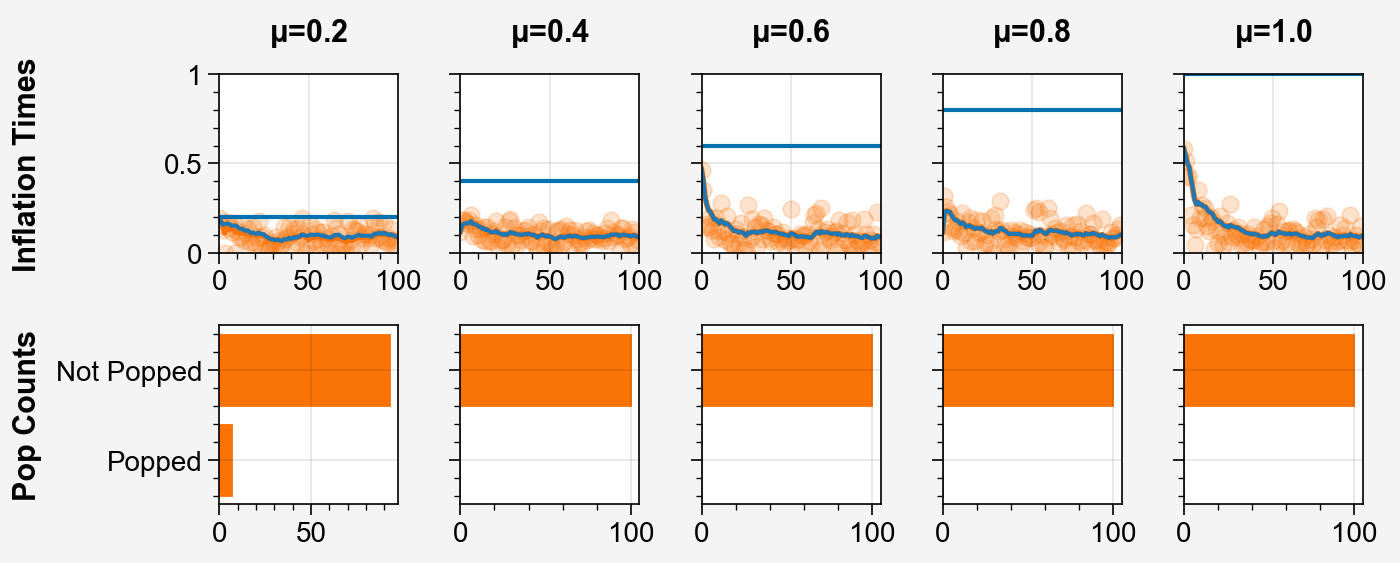

In [29]:
for t in range(3):
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta/meta_r0n50b256rew_{t}/40.pt')
    res = fix_size_evalu(model, obs_rms)
    plot_1color5fsize(res)